In [1]:
## DGE for each time point to control (only old mice)
## MA Script to find the error
import ma_codes as codes
from ma_codes import mysize, mymap, gray_red

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb

## Some Plotting Parameters
plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams.update({'font.size': 14})
plt.rcParams['pdf.fonttype'] = 42
sb.set_style("ticks")
rocket = sb.color_palette("rocket", as_cmap = True)

#pd.set_option("display.max_columns", 100)

#import diffxpy.api as de
#print(de.__version__)  ## before: v0.7.4

import diffxpy.api as de
print(de.__version__)  ## before: v0.7.4
sc.logging.print_version_and_date()

2024-08-14 16:31:08.594003: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-14 16:31:08.596513: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-14 16:31:08.603104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1723645868.613444 2220627 cuda_dnn.cc:8430] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1723645868.616675 2220627 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 16:31:08.625299: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

v0.7.4
Running Scanpy 1.10.2, on 2024-08-14 16:31.


In [2]:
import sparse
sparse.__version__

'0.9.1'

In [3]:
object_folder = "/media/HDD_1/Janine/Aging_SingleCell/data_objects/"

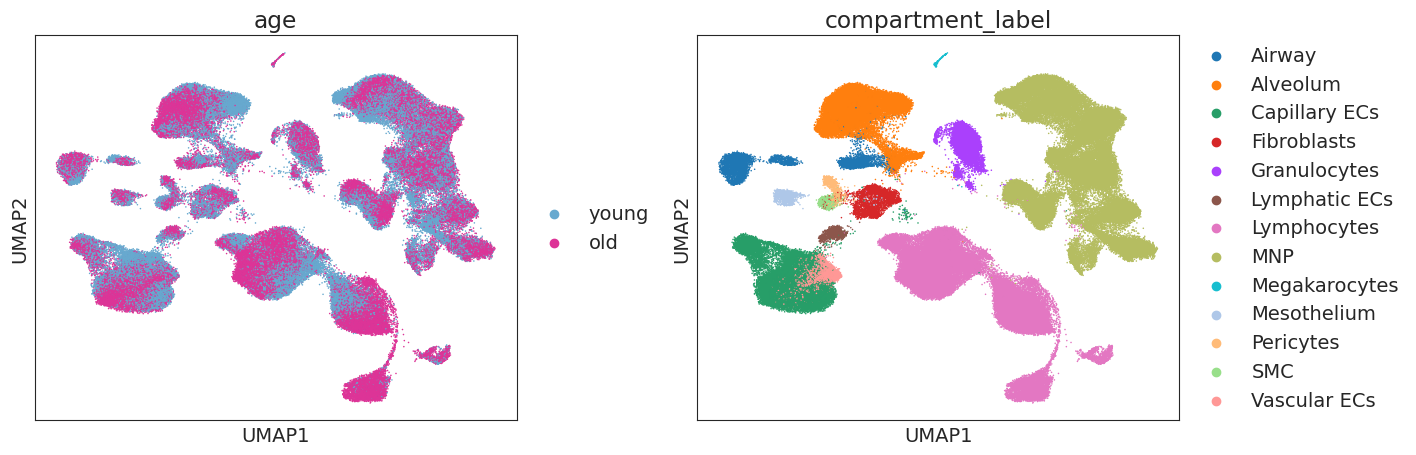

In [4]:
adata = sc.read(object_folder + "230111_Bleo_Ageing_annotated_final.h5ad", cache = False)
sc.pl.umap(adata, color = ["age", "compartment_label"], size = 5, wspace = 0.25)

In [5]:
adata

AnnData object with n_obs × n_vars = 160477 × 29814
    obs: 'age', 'barcode', 'batch', 'day', 'name', 'sex', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'doublet_scores', 'size_factors', 'S_score', 'G2M_score', 'phase', 'time_point', 'leiden_1', 'leiden_2', 'domain', 'cell_type', 'ct_level2', 'compartment_label', 'meta_label', 'age_treatment', 'age_day'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_colors', 'age_day_colors', 'age_treatment_colors', 'batch_colors', 'cell_type_colors', 'compartment_label_colors', 'ct_level2_colors', 'day_colors', 'dendrogram_cell_type', 'domain_colors', 'hvg', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'meta_label_colors', 'name_colors', 'neighbors', 'pca', 'sex_colors', 'time_point_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connect

In [6]:
### Scaling of counts is recommended for diffxpy
adata.obs["n_counts_scaled"] = adata.obs["n_counts"] / adata.obs["n_counts"].mean()

### Subset to only old mice

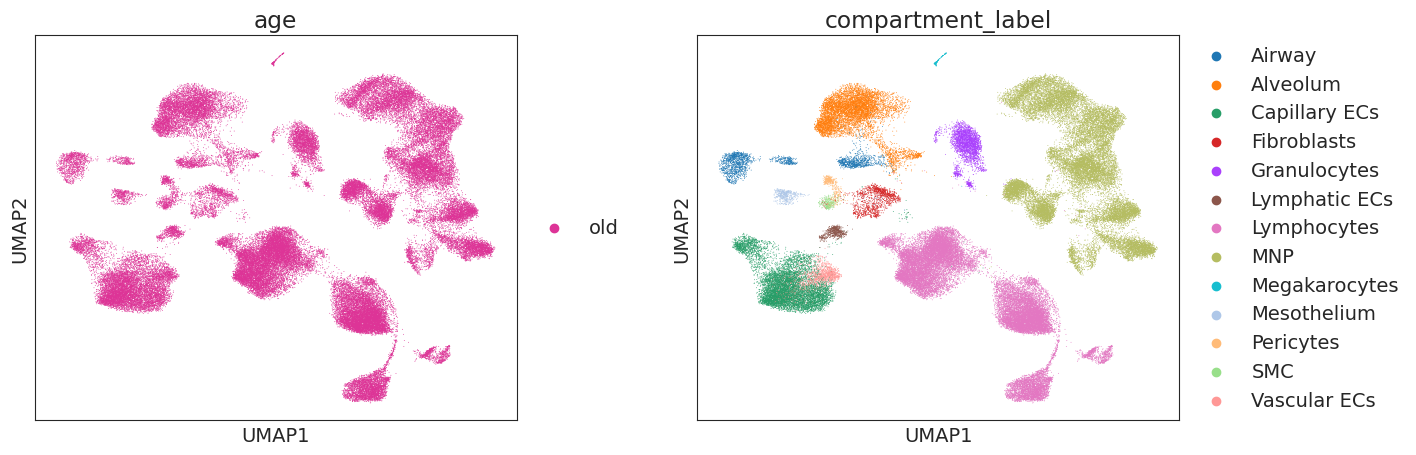

In [7]:
adata = adata[adata.obs.age == "old"].copy()
sc.pl.umap(adata, color = ["age", "compartment_label"], wspace = 0.25)

In [8]:
adata.obs.meta_label.value_counts()

meta_label
Macrophages       14372
T cells           12895
B cells            9499
Capillary ECs      8799
Alveolum           7199
DC                 6119
Monocytes          4102
Plasma cells       4099
Granulocytes       2887
Airway             2150
Vascular ECs       1493
Fibroblasts        1257
NK                  680
Lymphatic ECs       597
Mesothelium         488
Pericytes           446
SMC                 295
Megakaryocytes      107
Name: count, dtype: int64

In [9]:
list(adata.obs.meta_label.unique())

['Vascular ECs',
 'DC',
 'Capillary ECs',
 'Airway',
 'Macrophages',
 'Alveolum',
 'T cells',
 'Monocytes',
 'Plasma cells',
 'SMC',
 'B cells',
 'Fibroblasts',
 'NK',
 'Lymphatic ECs',
 'Mesothelium',
 'Pericytes',
 'Granulocytes',
 'Megakaryocytes']

### Write it into function finally

In [14]:
def dge(a, ct = "Airway", ct_label = "meta_label", condition = "treatment", ref = "control", 
        pct_thresh = 0.05, subset = ["control", "bleo"], min_cells = 10, do_return = None, 
        suffix = "", myofib = None):
    
    if myofib:
        cells = a.obs.loc[:, ct_label].isin(subset)
    else:
        cells = a.obs.loc[:, ct_label] == ct
    
    count = a[cells].obs.loc[:, condition].value_counts()
    if (len(count) < 2) or (count[0] < min_cells) or (count[1] < min_cells):
        print("Too few cells in one condition (%s)\n%s" %(ct, count))
        return
        
    ## As threshold, take 5% of all cells in cell type per group
    tab = pd.DataFrame(index = a.var_names)
    tab = codes.add_pct(a[cells], tab = tab, group_by = condition,
                        gene_label = "index", ids = subset)
    test_genes = tab[(tab.loc[:, "pct.%s" %subset[0]] > pct_thresh) | (tab.loc[:, "pct.%s" %subset[1]] > pct_thresh)].index

    if myofib:
        print("Running Myofibroblast Version")
        adata_raw = codes.generate_count_object(a[:, test_genes], condition = condition,
                                                cell_type_label = ct_label, cell_type = subset, 
                                                ref = ref, min_cells = 5, subset = subset)
    
    else:
        adata_raw = codes.generate_count_object(a[:, test_genes], condition = condition, 
                                                cell_type_label = ct_label, cell_type = [ct], 
                                                ref = ref, min_cells = 5, subset = subset)

    print("Started Diffxpy Calculation:\t%s" %codes.timestamp())

    de_test = de.test.wald(data = adata_raw.X, formula_loc = "~ 1 + %s" %condition,
                           factor_loc_totest = condition,
                           training_strategy = [{"max_steps": 100, "update_b_freq": 5,
                                                "ftol_b": 1e-8, "max_iter_b": 100}],
                           gene_names = adata_raw.var_names, sample_description = adata_raw.obs,
                           noise_model = "nb", size_factors = "n_counts_scaled")

    print("Finished Diffxpy Calculation:\t%s" %codes.timestamp())

    ## Export Table
    res = codes.tidy_table(de_test, a, cells = adata_raw.obs_names, ids = subset,
                           group_by = condition, qval_thresh = 1.0)


    filename = "diffxpy_%s_vs_%s_%s_%s%s.txt" %(subset[0], subset[1], ct.replace(" ", "_"), time.replace(" ", ""), suffix)
    print("Saving to %s\n" %filename)
    res.to_csv("%s%s" %(out_folder, filename), sep = "\t", index = False)
    
    if do_return:
        return res
    

In [15]:
cell_types = ['Alveolum','Airway','Macrophages','Monocytes','DC','B cells',
              'Plasma cells','T cells','NK','Granulocytes','Fibroblasts',
              'Pericytes','SMC','Mesothelium','Capillary ECs', 'Vascular ECs','Lymphatic ECs']

In [16]:
pd.crosstab(adata.obs.meta_label, adata.obs.age_day)

age_day         old_d0  old_d3  old_d10  old_d20  old_d30  old_d37
meta_label                                                        
Alveolum          4019    1259      552      505      304      560
Airway             769     229      265      413      195      279
Macrophages       2233    1093     2653     3868     2633     1892
Monocytes         1741     846      425      144      857       89
DC                1395     498     1395     1221      726      884
B cells           3481    1391     1686     1311      743      887
Plasma cells      1643     263      213      490      718      772
T cells           3599    1911     3029     2309     1162      885
NK                 297     194      104       22       46       17
Megakaryocytes      50      34       17        3        3        0
Granulocytes      1005    1106      287       75      334       80
Fibroblasts        297     159      188      347      148      118
Pericytes          155     113      109       33       19       17
SMC                115      64       42       39       19       16
Mesothelium        191      59       66       71       45       56
Capillary ECs     3075    1459     1736     1099      721      709
Vascular ECs       495     230      318      201      156       93
Lymphatic ECs      170      49       78      130       86       84

### day 3

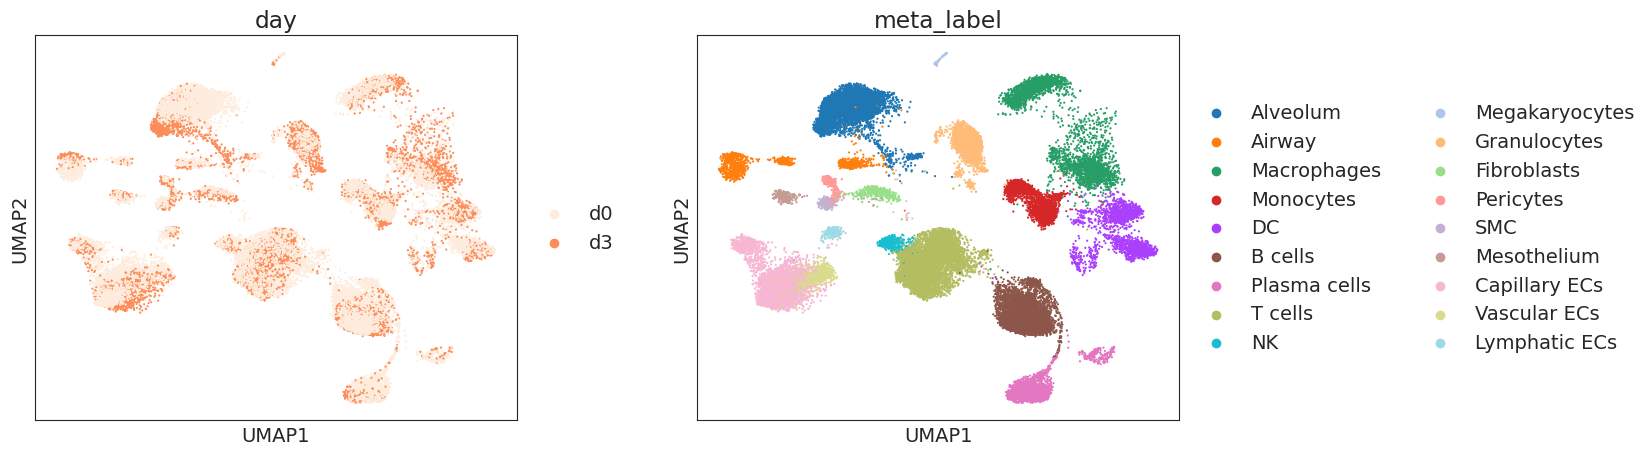

Alveolum - d3
(5278, 4499)


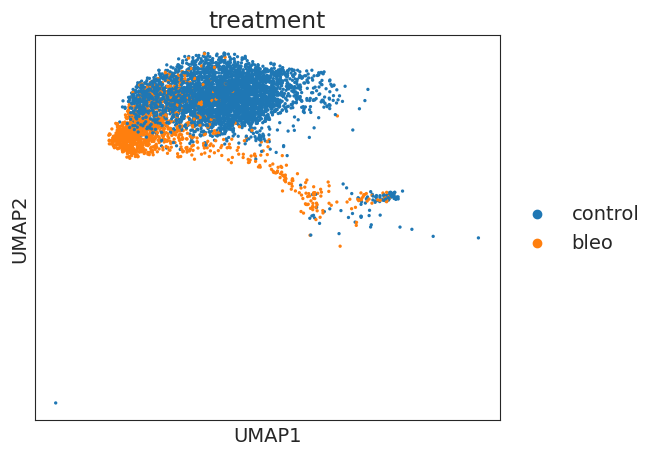

Started Diffxpy Calculation:	14-08-2024 16:46:06
training location model: True
training scale model: True
iter   0: ll=12694740.511301
iter   1: ll=11243074.288250, converged: 0.00% (loc: 0.22%, scale update: False), in 2.10sec
iter   2: ll=10914292.740463, converged: 0.00% (loc: 0.22%, scale update: False), in 2.00sec
iter   3: ll=10890415.680683, converged: 0.00% (loc: 0.22%, scale update: False), in 1.88sec
iter   4: ll=10889994.680658, converged: 0.00% (loc: 0.22%, scale update: False), in 2.12sec
iter   5: ll=10889990.696954, converged: 0.00% (loc: 0.40%, scale update: False), in 2.32sec
iter   6: ll=10292620.196942, converged: 0.00% (loc: 0.00%, scale update: True), in 27.84sec
iter   7: ll=10291455.949923, converged: 0.00% (loc: 0.09%, scale update: False), in 2.02sec
iter   8: ll=10291349.179487, converged: 0.00% (loc: 2.07%, scale update: False), in 1.97sec
iter   9: ll=10291343.712374, converged: 0.00% (loc: 15.27%, scale update: False), in 1.82sec
iter  10: ll=10291343.66441

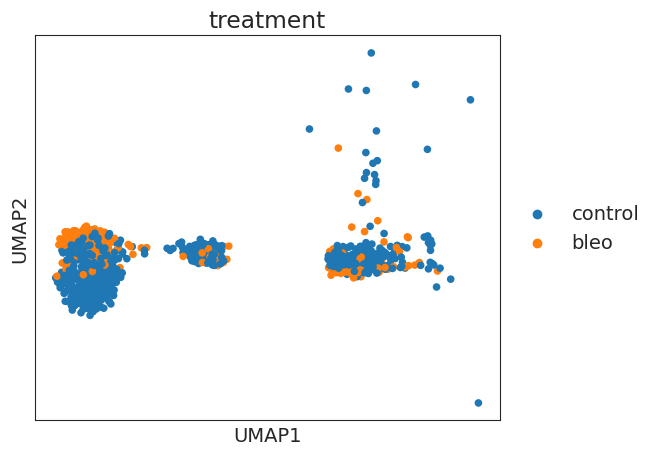

Started Diffxpy Calculation:	14-08-2024 16:48:48
training location model: True
training scale model: True
iter   0: ll=63235128.821955
caught 1 linalg singular matrix errors
iter   1: ll=62099729.792434, converged: 0.00% (loc: 24.30%, scale update: False), in 0.83sec
iter   2: ll=61623027.180020, converged: 0.00% (loc: 24.30%, scale update: False), in 0.61sec
iter   3: ll=61477619.412752, converged: 0.00% (loc: 24.30%, scale update: False), in 0.61sec
iter   4: ll=61445585.130318, converged: 0.00% (loc: 24.30%, scale update: False), in 0.62sec
iter   5: ll=61440649.957326, converged: 0.00% (loc: 24.30%, scale update: False), in 0.86sec
iter   6: ll=4195217.105083, converged: 0.00% (loc: 0.00%, scale update: True), in 11.06sec
caught 1 linalg singular matrix errors
iter   7: ll=4119078.969432, converged: 0.00% (loc: 0.04%, scale update: False), in 0.61sec
iter   8: ll=4105664.722460, converged: 0.00% (loc: 0.29%, scale update: False), in 0.61sec
iter   9: ll=4103743.069742, converged: 0

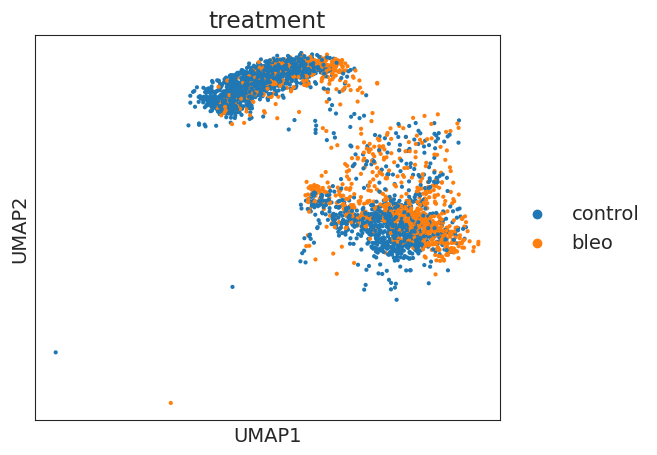

Started Diffxpy Calculation:	14-08-2024 16:50:38
training location model: True
training scale model: True
iter   0: ll=9600714.353602
iter   1: ll=8622984.405606, converged: 0.00% (loc: 0.04%, scale update: False), in 1.60sec
iter   2: ll=8394190.696866, converged: 0.00% (loc: 0.04%, scale update: False), in 1.63sec
iter   3: ll=8377033.695601, converged: 0.00% (loc: 0.04%, scale update: False), in 1.64sec
iter   4: ll=8376713.104433, converged: 0.00% (loc: 0.04%, scale update: False), in 1.75sec
iter   5: ll=8376709.505616, converged: 0.00% (loc: 0.37%, scale update: False), in 2.15sec
iter   6: ll=8278927.550267, converged: 0.00% (loc: 0.00%, scale update: True), in 22.55sec
iter   7: ll=8278170.638676, converged: 0.00% (loc: 0.00%, scale update: False), in 1.67sec
iter   8: ll=8278145.093316, converged: 0.00% (loc: 2.08%, scale update: False), in 1.61sec
iter   9: ll=8278144.098389, converged: 0.00% (loc: 12.37%, scale update: False), in 1.52sec
iter  10: ll=8278144.089241, converge

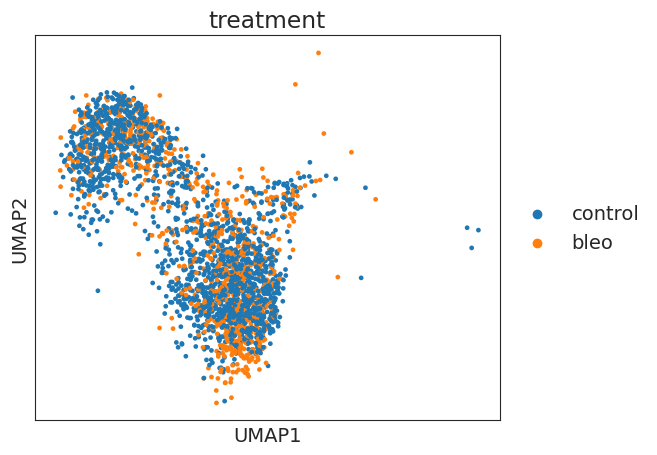

Started Diffxpy Calculation:	14-08-2024 16:52:43
training location model: True
training scale model: True
iter   0: ll=5712619.761998
iter   1: ll=5140028.527702, converged: 0.00% (loc: 0.00%, scale update: False), in 1.93sec
iter   2: ll=5023530.355640, converged: 0.00% (loc: 0.00%, scale update: False), in 1.76sec
iter   3: ll=5018186.777057, converged: 0.00% (loc: 0.00%, scale update: False), in 1.23sec
iter   4: ll=5018167.750018, converged: 0.00% (loc: 0.00%, scale update: False), in 1.28sec
iter   5: ll=5018167.735298, converged: 0.00% (loc: 26.77%, scale update: False), in 1.20sec
iter   6: ll=4936746.773224, converged: 0.00% (loc: 0.00%, scale update: True), in 13.51sec
iter   7: ll=4936588.853455, converged: 0.00% (loc: 0.00%, scale update: False), in 1.65sec
iter   8: ll=4936588.465564, converged: 0.00% (loc: 6.51%, scale update: False), in 1.30sec
iter   9: ll=4936588.464782, converged: 0.00% (loc: 73.10%, scale update: False), in 1.08sec
iter  10: ll=4936588.464780, converg

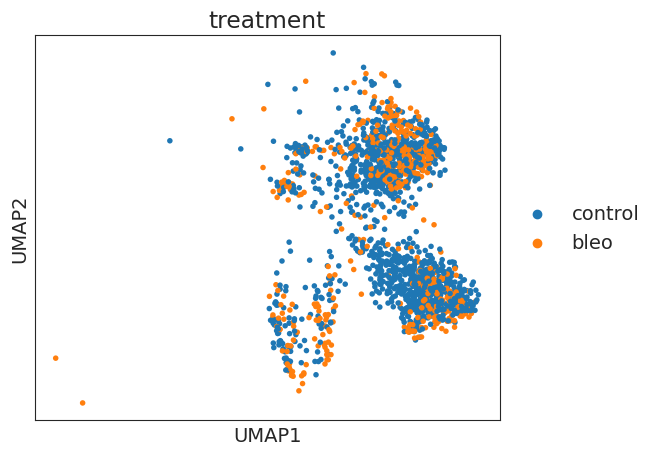

Started Diffxpy Calculation:	14-08-2024 16:53:54
training location model: True
training scale model: True
iter   0: ll=5436587.652031
iter   1: ll=4838195.383605, converged: 0.00% (loc: 0.10%, scale update: False), in 1.22sec
iter   2: ll=4704652.399732, converged: 0.00% (loc: 0.10%, scale update: False), in 1.25sec
iter   3: ll=4695383.424755, converged: 0.00% (loc: 0.10%, scale update: False), in 1.48sec
iter   4: ll=4695222.931130, converged: 0.00% (loc: 0.10%, scale update: False), in 1.25sec
iter   5: ll=4695221.022343, converged: 0.00% (loc: 0.66%, scale update: False), in 1.38sec
iter   6: ll=4580325.326982, converged: 0.00% (loc: 0.00%, scale update: True), in 11.52sec
iter   7: ll=4579909.036345, converged: 0.00% (loc: 0.10%, scale update: False), in 1.31sec
iter   8: ll=4579838.085364, converged: 0.00% (loc: 3.89%, scale update: False), in 1.18sec
iter   9: ll=4579837.763530, converged: 0.00% (loc: 26.01%, scale update: False), in 1.18sec
iter  10: ll=4579837.761867, converge

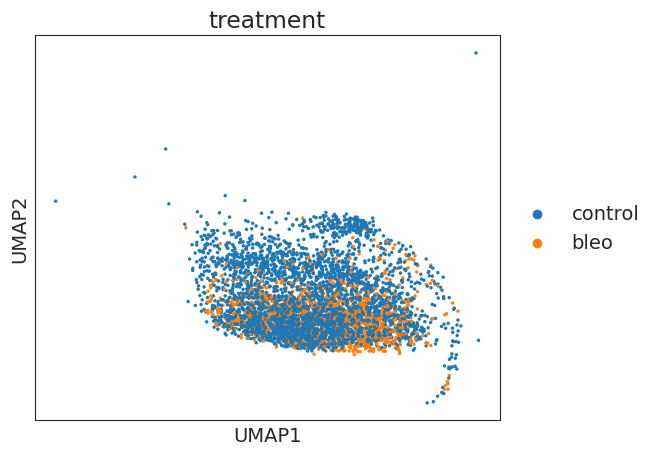

Started Diffxpy Calculation:	14-08-2024 16:55:10
training location model: True
training scale model: True
iter   0: ll=7973010.856368
iter   1: ll=7239839.144601, converged: 0.00% (loc: 0.00%, scale update: False), in 1.58sec
iter   2: ll=7065710.565832, converged: 0.00% (loc: 0.00%, scale update: False), in 1.50sec
iter   3: ll=7055397.090749, converged: 0.00% (loc: 0.00%, scale update: False), in 1.56sec
iter   4: ll=7055339.331622, converged: 0.00% (loc: 0.00%, scale update: False), in 1.40sec
iter   5: ll=7055339.272538, converged: 0.00% (loc: 13.56%, scale update: False), in 1.59sec
iter   6: ll=6917200.586401, converged: 0.00% (loc: 0.00%, scale update: True), in 15.19sec
iter   7: ll=6916840.692626, converged: 0.00% (loc: 0.00%, scale update: False), in 1.60sec
iter   8: ll=6916837.490849, converged: 0.00% (loc: 3.59%, scale update: False), in 1.48sec
iter   9: ll=6916837.446840, converged: 0.00% (loc: 44.35%, scale update: False), in 1.36sec
iter  10: ll=6916837.444225, converg

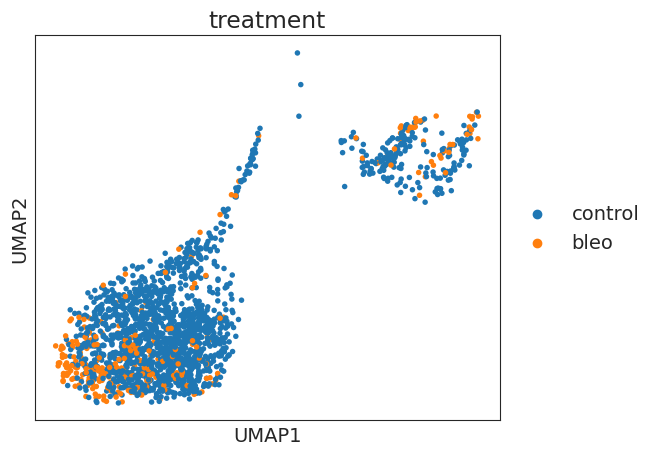

Started Diffxpy Calculation:	14-08-2024 16:56:35
training location model: True
training scale model: True
iter   0: ll=3444311.124224
caught 1 linalg singular matrix errors
iter   1: ll=3119802.447903, converged: 0.00% (loc: 1.60%, scale update: False), in 0.67sec
iter   2: ll=3036828.543980, converged: 0.00% (loc: 1.60%, scale update: False), in 0.68sec
iter   3: ll=3027863.925057, converged: 0.00% (loc: 1.60%, scale update: False), in 0.62sec
iter   4: ll=3027443.172034, converged: 0.00% (loc: 1.60%, scale update: False), in 0.64sec
iter   5: ll=3027428.475124, converged: 0.00% (loc: 2.04%, scale update: False), in 0.73sec
iter   6: ll=1836168.811638, converged: 0.00% (loc: 0.00%, scale update: True), in 4.88sec
caught 1 linalg singular matrix errors
iter   7: ll=1834379.109769, converged: 0.00% (loc: 0.17%, scale update: False), in 0.69sec
iter   8: ll=1834155.740476, converged: 0.00% (loc: 1.71%, scale update: False), in 0.67sec
iter   9: ll=1834139.027067, converged: 0.00% (loc: 9

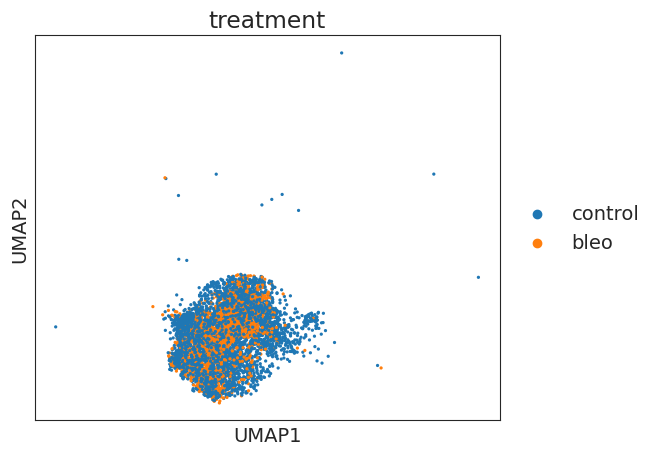

Started Diffxpy Calculation:	14-08-2024 16:57:13
training location model: True
training scale model: True
iter   0: ll=8899837.861559
iter   1: ll=8075326.227105, converged: 0.00% (loc: 0.00%, scale update: False), in 1.50sec
iter   2: ll=7895694.852835, converged: 0.00% (loc: 0.00%, scale update: False), in 1.75sec
iter   3: ll=7886948.902708, converged: 0.00% (loc: 0.00%, scale update: False), in 1.48sec
iter   4: ll=7886924.217880, converged: 0.00% (loc: 0.00%, scale update: False), in 1.59sec
iter   5: ll=7886924.214612, converged: 0.00% (loc: 40.53%, scale update: False), in 1.40sec
iter   6: ll=7748988.844637, converged: 0.00% (loc: 0.00%, scale update: True), in 17.64sec
iter   7: ll=7748870.480874, converged: 0.00% (loc: 0.03%, scale update: False), in 1.69sec
iter   8: ll=7748870.153502, converged: 0.00% (loc: 13.71%, scale update: False), in 1.59sec
iter   9: ll=7748870.152001, converged: 0.00% (loc: 92.96%, scale update: False), in 1.41sec
iter  10: ll=7748870.151981, conver

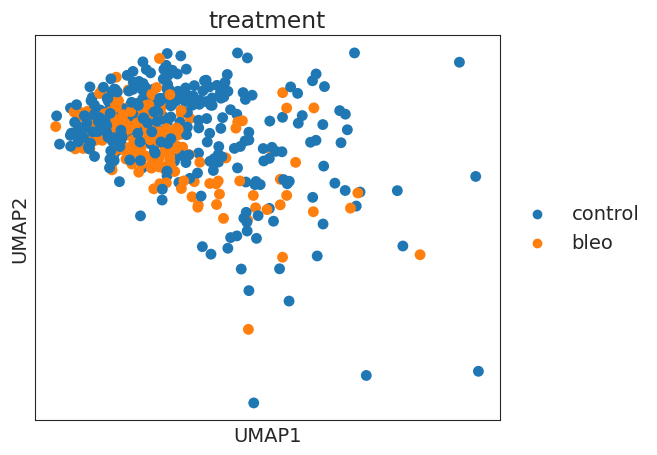

Started Diffxpy Calculation:	14-08-2024 16:58:39
training location model: True
training scale model: True
iter   0: ll=728307.325629
iter   1: ll=659466.827883, converged: 0.00% (loc: 0.00%, scale update: False), in 0.79sec
iter   2: ll=643959.468734, converged: 0.00% (loc: 0.00%, scale update: False), in 0.66sec
iter   3: ll=643139.282583, converged: 0.00% (loc: 0.00%, scale update: False), in 0.36sec
iter   4: ll=643136.112962, converged: 0.00% (loc: 0.00%, scale update: False), in 0.31sec
iter   5: ll=643136.111248, converged: 0.00% (loc: 24.51%, scale update: False), in 0.58sec
iter   6: ll=628529.721708, converged: 0.00% (loc: 0.00%, scale update: True), in 3.35sec
iter   7: ll=628497.744902, converged: 0.00% (loc: 0.20%, scale update: False), in 0.37sec
iter   8: ll=628497.648968, converged: 0.00% (loc: 7.86%, scale update: False), in 0.37sec
iter   9: ll=628497.648799, converged: 0.00% (loc: 79.71%, scale update: False), in 0.39sec
iter  10: ll=628497.648799, converged: 0.00% (l

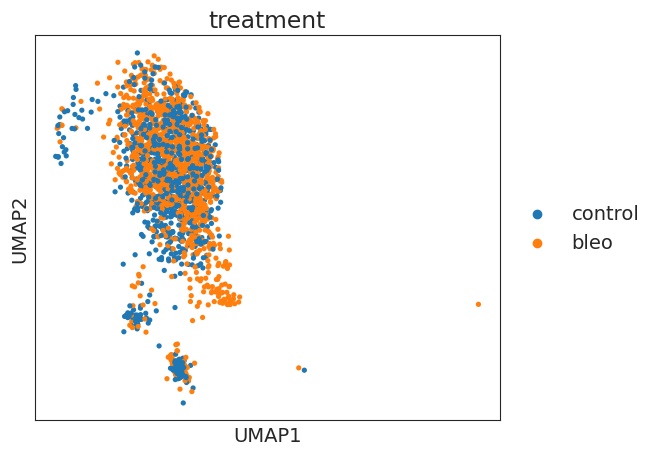

Started Diffxpy Calculation:	14-08-2024 16:59:01
training location model: True
training scale model: True
iter   0: ll=2020880.440465
iter   1: ll=1796227.011926, converged: 0.00% (loc: 0.00%, scale update: False), in 0.64sec
iter   2: ll=1732661.782333, converged: 0.00% (loc: 0.00%, scale update: False), in 0.69sec
iter   3: ll=1727732.229989, converged: 0.00% (loc: 0.00%, scale update: False), in 1.03sec
iter   4: ll=1727700.717867, converged: 0.00% (loc: 0.00%, scale update: False), in 0.88sec
iter   5: ll=1727700.716177, converged: 0.00% (loc: 18.35%, scale update: False), in 1.03sec
iter   6: ll=1689121.150148, converged: 0.00% (loc: 0.00%, scale update: True), in 6.67sec
iter   7: ll=1689108.090842, converged: 0.00% (loc: 0.00%, scale update: False), in 0.94sec
iter   8: ll=1689108.085087, converged: 0.00% (loc: 27.53%, scale update: False), in 0.78sec
iter   9: ll=1689108.085082, converged: 0.00% (loc: 98.45%, scale update: False), in 0.66sec
iter  10: ll=1689108.085082, converg

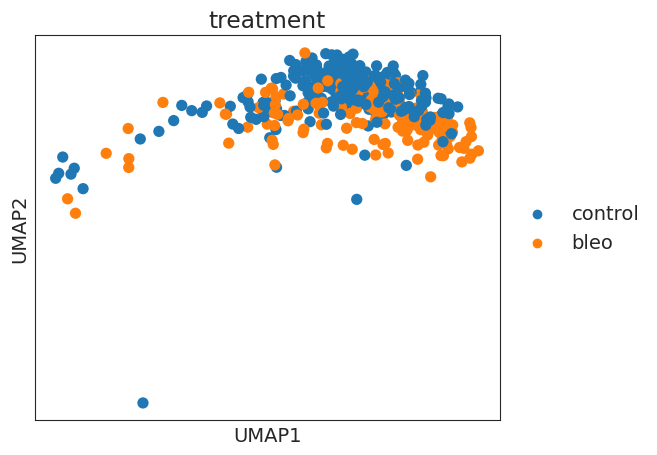

Started Diffxpy Calculation:	14-08-2024 16:59:29
training location model: True
training scale model: True
iter   0: ll=1652062.331790
caught 4 linalg singular matrix errors
iter   1: ll=1528651.706852, converged: 0.00% (loc: 1.14%, scale update: False), in 0.50sec
iter   2: ll=1498755.578927, converged: 0.00% (loc: 1.14%, scale update: False), in 0.69sec
iter   3: ll=1496251.030341, converged: 0.00% (loc: 1.14%, scale update: False), in 0.52sec
iter   4: ll=1496179.194783, converged: 0.00% (loc: 1.14%, scale update: False), in 0.50sec
iter   5: ll=1496177.510043, converged: 0.00% (loc: 1.63%, scale update: False), in 0.49sec
iter   6: ll=1131076.840807, converged: 0.00% (loc: 0.00%, scale update: True), in 6.80sec
caught 4 linalg singular matrix errors
iter   7: ll=1129966.851828, converged: 0.00% (loc: 0.20%, scale update: False), in 0.96sec
iter   8: ll=1129874.348177, converged: 0.00% (loc: 1.72%, scale update: False), in 0.75sec
iter   9: ll=1129869.736444, converged: 0.00% (loc: 9

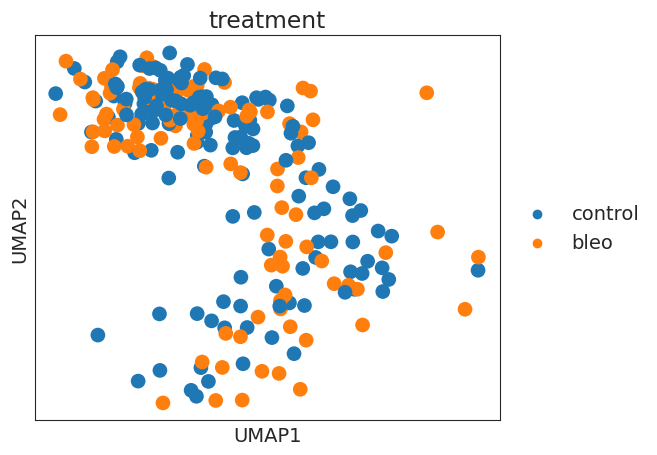

Started Diffxpy Calculation:	14-08-2024 17:00:31
training location model: True
training scale model: True
iter   0: ll=594716.457547
caught 18 linalg singular matrix errors
iter   1: ll=540631.625734, converged: 0.00% (loc: 0.39%, scale update: False), in 0.61sec
iter   2: ll=528971.343072, converged: 0.00% (loc: 0.39%, scale update: False), in 0.53sec
iter   3: ll=528309.549391, converged: 0.00% (loc: 0.39%, scale update: False), in 0.54sec
iter   4: ll=528303.189081, converged: 0.00% (loc: 0.39%, scale update: False), in 0.55sec
iter   5: ll=528303.132330, converged: 0.00% (loc: 10.22%, scale update: False), in 0.51sec
iter   6: ll=519457.389143, converged: 0.00% (loc: 0.00%, scale update: True), in 3.72sec
caught 18 linalg singular matrix errors
iter   7: ll=519385.409423, converged: 0.00% (loc: 0.42%, scale update: False), in 0.40sec
iter   8: ll=519383.892303, converged: 0.00% (loc: 3.76%, scale update: False), in 0.42sec
iter   9: ll=519383.857381, converged: 0.00% (loc: 33.40%, 

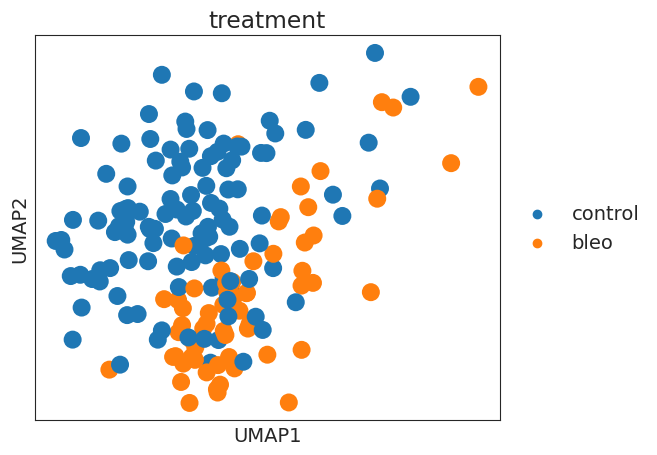

Started Diffxpy Calculation:	14-08-2024 17:01:19
training location model: True
training scale model: True
iter   0: ll=1077222.023080
caught 63 linalg singular matrix errors
iter   1: ll=1019170.478382, converged: 0.00% (loc: 5.26%, scale update: False), in 0.61sec
iter   2: ll=1006799.366812, converged: 0.00% (loc: 5.26%, scale update: False), in 0.54sec
iter   3: ll=1005990.166109, converged: 0.00% (loc: 5.26%, scale update: False), in 0.58sec
iter   4: ll=1005976.711944, converged: 0.00% (loc: 5.26%, scale update: False), in 0.55sec
iter   5: ll=1005976.534135, converged: 0.00% (loc: 7.14%, scale update: False), in 0.76sec
iter   6: ll=416733.107584, converged: 0.00% (loc: 0.00%, scale update: True), in 3.93sec
caught 63 linalg singular matrix errors
iter   7: ll=416169.125137, converged: 0.00% (loc: 3.21%, scale update: False), in 0.49sec
iter   8: ll=416109.289367, converged: 0.00% (loc: 6.85%, scale update: False), in 0.52sec
iter   9: ll=416107.338376, converged: 0.00% (loc: 30.

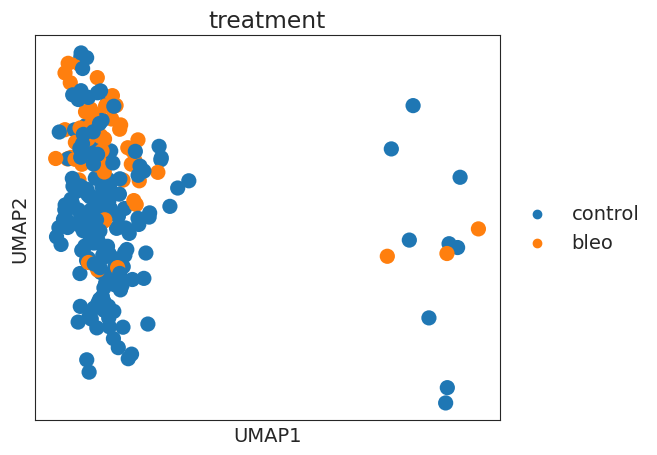

Started Diffxpy Calculation:	14-08-2024 17:02:02
training location model: True
training scale model: True
iter   0: ll=1708948.322031
caught 77 linalg singular matrix errors
iter   1: ll=1627076.844419, converged: 0.00% (loc: 5.91%, scale update: False), in 0.72sec
iter   2: ll=1606669.974285, converged: 0.00% (loc: 5.91%, scale update: False), in 0.61sec
iter   3: ll=1604675.979932, converged: 0.00% (loc: 5.91%, scale update: False), in 0.61sec
iter   4: ll=1604593.960412, converged: 0.00% (loc: 5.91%, scale update: False), in 0.67sec
iter   5: ll=1604590.850444, converged: 0.00% (loc: 6.00%, scale update: False), in 0.66sec
iter   6: ll=638757.102264, converged: 0.00% (loc: 0.00%, scale update: True), in 4.25sec
caught 77 linalg singular matrix errors
iter   7: ll=635618.327546, converged: 0.00% (loc: 1.77%, scale update: False), in 0.75sec
iter   8: ll=635085.190196, converged: 0.00% (loc: 2.89%, scale update: False), in 0.56sec
iter   9: ll=635000.733882, converged: 0.00% (loc: 11.

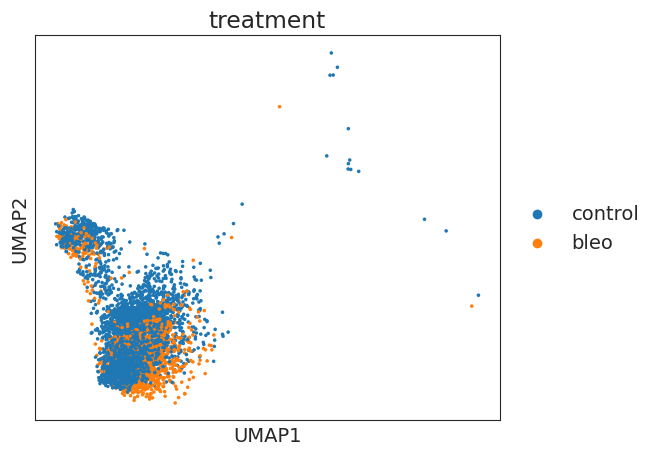

Started Diffxpy Calculation:	14-08-2024 17:03:08
training location model: True
training scale model: True
iter   0: ll=9331228.086101
iter   1: ll=8511111.755797, converged: 0.00% (loc: 0.00%, scale update: False), in 1.59sec
iter   2: ll=8327245.156762, converged: 0.00% (loc: 0.00%, scale update: False), in 1.72sec
iter   3: ll=8317351.099705, converged: 0.00% (loc: 0.00%, scale update: False), in 2.32sec
iter   4: ll=8317308.382793, converged: 0.00% (loc: 0.00%, scale update: False), in 2.43sec
iter   5: ll=8317308.365757, converged: 0.00% (loc: 8.61%, scale update: False), in 2.13sec
iter   6: ll=8137336.800061, converged: 0.00% (loc: 0.00%, scale update: True), in 21.13sec
iter   7: ll=8136879.778015, converged: 0.00% (loc: 0.03%, scale update: False), in 1.54sec
iter   8: ll=8136877.766293, converged: 0.00% (loc: 3.26%, scale update: False), in 1.69sec
iter   9: ll=8136877.759565, converged: 0.00% (loc: 36.52%, scale update: False), in 1.50sec
iter  10: ll=8136877.759540, converge

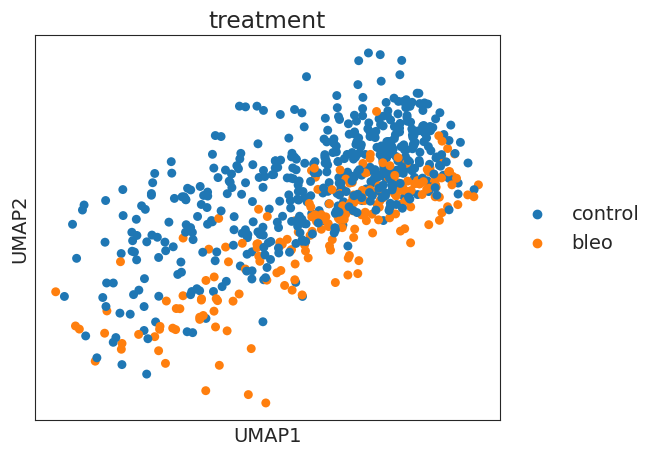

Started Diffxpy Calculation:	14-08-2024 17:04:54
training location model: True
training scale model: True
iter   0: ll=1900993.847639
iter   1: ll=1718595.497463, converged: 0.00% (loc: 0.02%, scale update: False), in 0.44sec
iter   2: ll=1677608.021279, converged: 0.00% (loc: 0.02%, scale update: False), in 0.43sec
iter   3: ll=1674939.659894, converged: 0.00% (loc: 0.02%, scale update: False), in 1.13sec
iter   4: ll=1674906.395749, converged: 0.00% (loc: 0.02%, scale update: False), in 0.44sec
iter   5: ll=1674906.159744, converged: 0.00% (loc: 0.89%, scale update: False), in 0.47sec
iter   6: ll=1653485.229248, converged: 0.00% (loc: 0.00%, scale update: True), in 5.44sec
iter   7: ll=1653313.820127, converged: 0.00% (loc: 0.04%, scale update: False), in 0.67sec
iter   8: ll=1653309.945419, converged: 0.00% (loc: 2.41%, scale update: False), in 0.48sec
iter   9: ll=1653309.852022, converged: 0.00% (loc: 17.37%, scale update: False), in 0.48sec
iter  10: ll=1653309.850374, converged

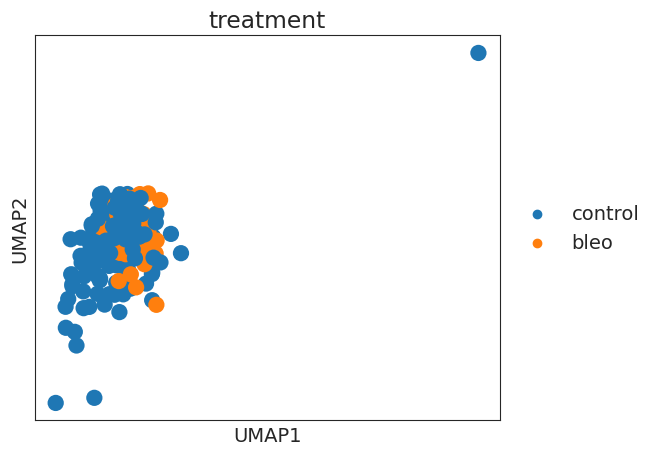

Started Diffxpy Calculation:	14-08-2024 17:05:33
training location model: True
training scale model: True
iter   0: ll=1902402.177729
caught 114 linalg singular matrix errors
iter   1: ll=1811432.932019, converged: 0.00% (loc: 6.40%, scale update: False), in 0.67sec
iter   2: ll=1787014.794279, converged: 0.00% (loc: 6.40%, scale update: False), in 0.87sec
iter   3: ll=1784131.093635, converged: 0.00% (loc: 6.40%, scale update: False), in 0.69sec
iter   4: ll=1783971.516856, converged: 0.00% (loc: 6.40%, scale update: False), in 0.64sec
iter   5: ll=1783964.629639, converged: 0.00% (loc: 6.40%, scale update: False), in 0.63sec
iter   6: ll=677651.963838, converged: 0.00% (loc: 0.00%, scale update: True), in 4.40sec
caught 114 linalg singular matrix errors
iter   7: ll=675520.868612, converged: 0.00% (loc: 2.68%, scale update: False), in 0.63sec
iter   8: ll=675082.067690, converged: 0.00% (loc: 3.29%, scale update: False), in 0.93sec
iter   9: ll=675049.876130, converged: 0.00% (loc: 8

In [18]:
out_folder = "/media/HDD_1/Janine/Aging_SingleCell/data/DGE_data/dge_meta_label_old/"

subset = ["control", "bleo"]
condition = "treatment"
ct_label = "meta_label"
min_cells = 10

time = "d3"
time_subset = adata[adata.obs.time_point.isin([time, "d0"])].copy()
sc.pl.umap(time_subset, color = ["day", "meta_label"], size = 10, wspace = 0.25)

for ct in cell_types:
    
    print("%s - %s" %(ct, time))
    dge(time_subset, ct = ct, ct_label = ct_label, condition = condition, ref = "control", pct_thresh = 0.05,
              subset = subset, min_cells = min_cells, do_return = False, suffix = "_old")
    

### day 10

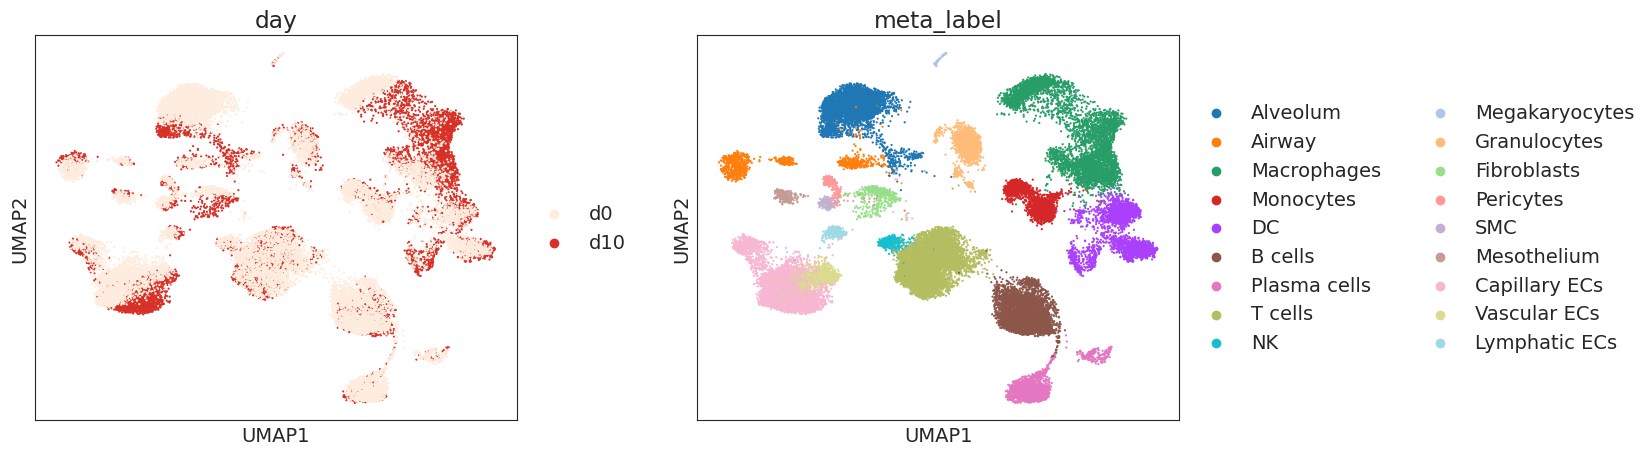

Alveolum - d10
(4571, 5254)


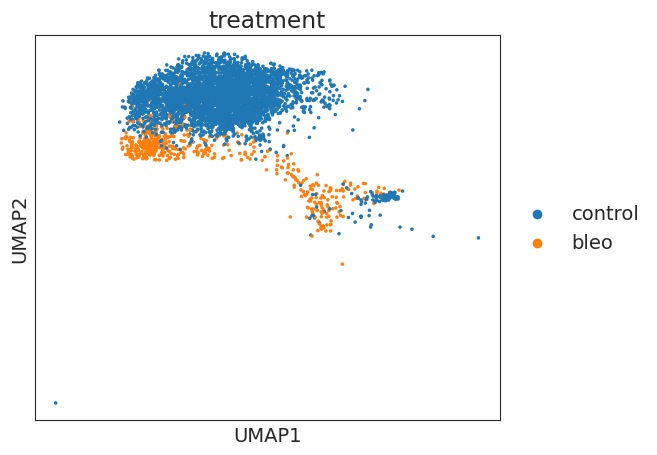

Started Diffxpy Calculation:	14-08-2024 17:06:49
training location model: True
training scale model: True
iter   0: ll=11765099.696565
iter   1: ll=10498711.297492, converged: 0.00% (loc: 0.48%, scale update: False), in 2.76sec
iter   2: ll=10208491.513272, converged: 0.00% (loc: 0.48%, scale update: False), in 1.99sec
iter   3: ll=10184810.788505, converged: 0.00% (loc: 0.48%, scale update: False), in 2.07sec
iter   4: ll=10183969.460559, converged: 0.00% (loc: 0.48%, scale update: False), in 2.07sec
iter   5: ll=10183937.747102, converged: 0.00% (loc: 0.55%, scale update: False), in 2.08sec
iter   6: ll=9325118.050042, converged: 0.00% (loc: 0.00%, scale update: True), in 25.47sec
iter   7: ll=9323181.717393, converged: 0.00% (loc: 0.04%, scale update: False), in 2.46sec
iter   8: ll=9323031.821963, converged: 0.00% (loc: 0.93%, scale update: False), in 2.70sec
iter   9: ll=9323022.688305, converged: 0.00% (loc: 5.63%, scale update: False), in 3.06sec
iter  10: ll=9323022.484092, con

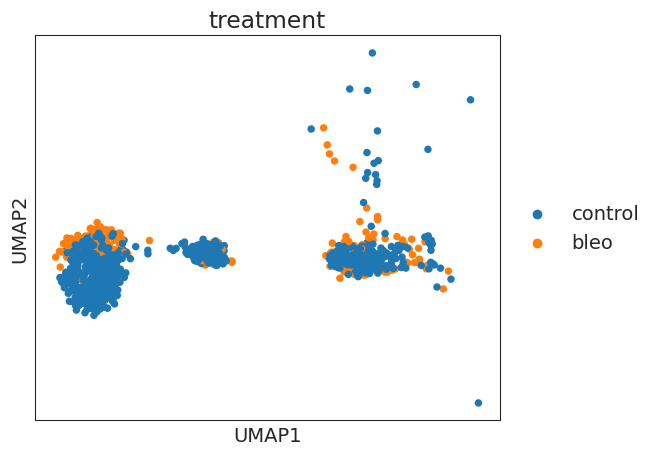

Started Diffxpy Calculation:	14-08-2024 17:09:49
training location model: True
training scale model: True
iter   0: ll=68443515.118111
iter   1: ll=67246919.293577, converged: 0.00% (loc: 25.25%, scale update: False), in 1.64sec
iter   2: ll=66736981.887838, converged: 0.00% (loc: 25.25%, scale update: False), in 0.58sec
iter   3: ll=66576221.354560, converged: 0.00% (loc: 25.25%, scale update: False), in 0.60sec
iter   4: ll=66538939.771033, converged: 0.00% (loc: 25.25%, scale update: False), in 0.58sec
iter   5: ll=66532791.725448, converged: 0.00% (loc: 25.25%, scale update: False), in 0.75sec
iter   6: ll=4298974.966908, converged: 0.00% (loc: 0.00%, scale update: True), in 11.92sec
iter   7: ll=4215754.403281, converged: 0.00% (loc: 0.03%, scale update: False), in 2.34sec
iter   8: ll=4201270.985692, converged: 0.00% (loc: 0.22%, scale update: False), in 2.23sec
iter   9: ll=4199180.475725, converged: 0.00% (loc: 0.84%, scale update: False), in 1.99sec
iter  10: ll=4199056.059354

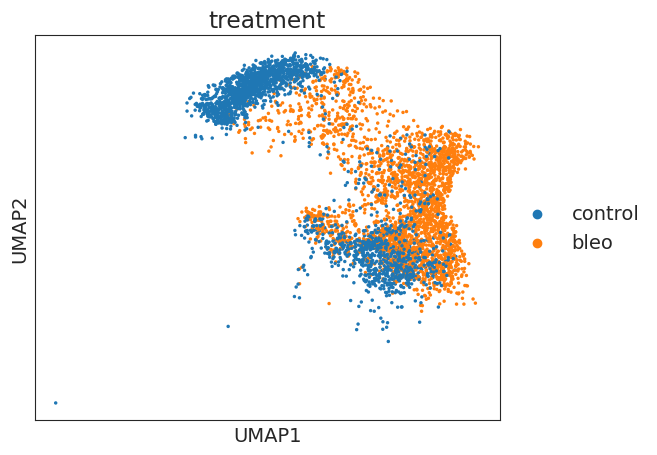

Started Diffxpy Calculation:	14-08-2024 17:11:52
training location model: True
training scale model: True
iter   0: ll=19192479.780067
caught 1 linalg singular matrix errors
iter   1: ll=17014698.717615, converged: 0.00% (loc: 0.40%, scale update: False), in 2.34sec
iter   2: ll=16391193.959869, converged: 0.00% (loc: 0.40%, scale update: False), in 2.50sec
iter   3: ll=16307890.756915, converged: 0.00% (loc: 0.40%, scale update: False), in 4.10sec
iter   4: ll=16302564.262810, converged: 0.00% (loc: 0.40%, scale update: False), in 4.70sec
iter   5: ll=16302329.730598, converged: 0.00% (loc: 0.46%, scale update: False), in 4.38sec
iter   6: ll=14446192.462922, converged: 0.00% (loc: 0.00%, scale update: True), in 33.92sec
caught 1 linalg singular matrix errors
iter   7: ll=14441889.264406, converged: 0.00% (loc: 0.05%, scale update: False), in 3.08sec
iter   8: ll=14441420.981317, converged: 0.00% (loc: 0.70%, scale update: False), in 3.54sec
iter   9: ll=14441374.608914, converged: 0.

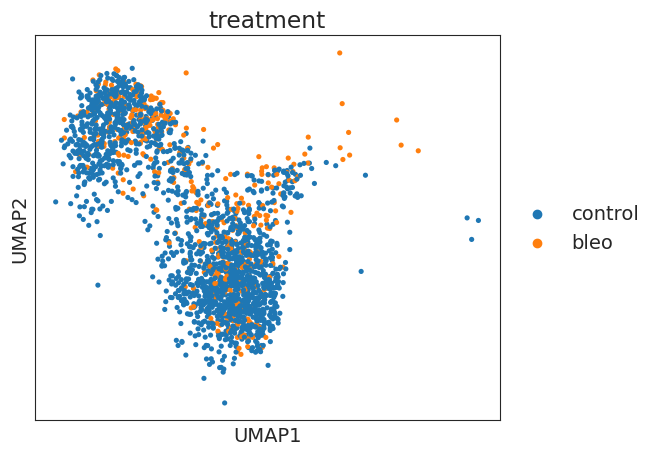

Started Diffxpy Calculation:	14-08-2024 17:15:52
training location model: True
training scale model: True
iter   0: ll=4690229.097079
iter   1: ll=4208735.302386, converged: 0.00% (loc: 0.00%, scale update: False), in 1.18sec
iter   2: ll=4113037.752018, converged: 0.00% (loc: 0.00%, scale update: False), in 1.10sec
iter   3: ll=4108852.804187, converged: 0.00% (loc: 0.00%, scale update: False), in 1.18sec
iter   4: ll=4108840.259165, converged: 0.00% (loc: 0.00%, scale update: False), in 1.08sec
iter   5: ll=4108840.253299, converged: 0.00% (loc: 33.99%, scale update: False), in 1.21sec
iter   6: ll=4051705.185503, converged: 0.00% (loc: 0.00%, scale update: True), in 10.66sec
iter   7: ll=4051622.358340, converged: 0.00% (loc: 0.05%, scale update: False), in 1.24sec
iter   8: ll=4051622.214967, converged: 0.00% (loc: 9.53%, scale update: False), in 1.19sec
iter   9: ll=4051622.214750, converged: 0.00% (loc: 84.42%, scale update: False), in 1.11sec
iter  10: ll=4051622.214750, converg

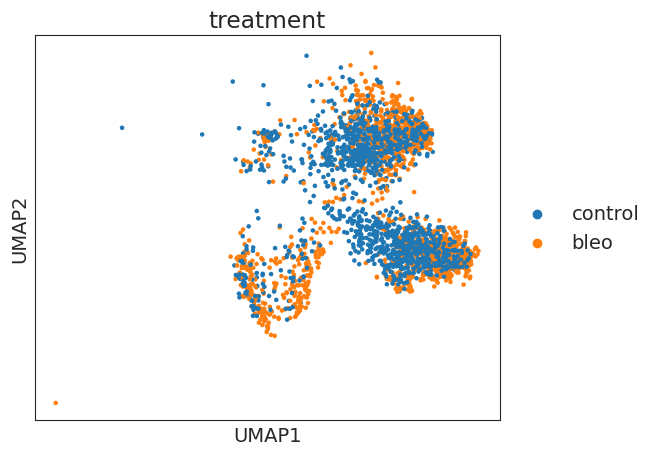

Started Diffxpy Calculation:	14-08-2024 17:17:00
training location model: True
training scale model: True
iter   0: ll=8041281.198945
iter   1: ll=7057294.563792, converged: 0.00% (loc: 0.00%, scale update: False), in 1.46sec
iter   2: ll=6835295.217478, converged: 0.00% (loc: 0.00%, scale update: False), in 1.41sec
iter   3: ll=6819448.266274, converged: 0.00% (loc: 0.00%, scale update: False), in 1.70sec
iter   4: ll=6819189.381808, converged: 0.00% (loc: 0.00%, scale update: False), in 1.35sec
iter   5: ll=6819187.320495, converged: 0.00% (loc: 0.26%, scale update: False), in 1.52sec
iter   6: ll=6803384.903303, converged: 0.00% (loc: 0.00%, scale update: True), in 15.89sec
iter   7: ll=6803159.048355, converged: 0.00% (loc: 0.04%, scale update: False), in 1.60sec
iter   8: ll=6803157.084557, converged: 0.00% (loc: 3.63%, scale update: False), in 1.80sec
iter   9: ll=6803157.065644, converged: 0.00% (loc: 33.55%, scale update: False), in 2.04sec
iter  10: ll=6803157.065440, converge

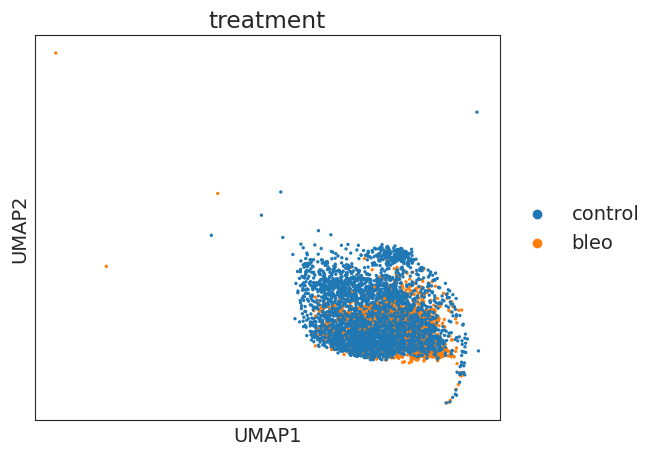

Started Diffxpy Calculation:	14-08-2024 17:18:38
training location model: True
training scale model: True
iter   0: ll=8423530.034230
iter   1: ll=7631720.360834, converged: 0.00% (loc: 0.00%, scale update: False), in 2.23sec
iter   2: ll=7447245.551417, converged: 0.00% (loc: 0.00%, scale update: False), in 2.55sec
iter   3: ll=7436595.544865, converged: 0.00% (loc: 0.00%, scale update: False), in 1.80sec
iter   4: ll=7436536.830223, converged: 0.00% (loc: 0.00%, scale update: False), in 1.89sec
iter   5: ll=7436536.766419, converged: 0.00% (loc: 16.08%, scale update: False), in 1.55sec
iter   6: ll=7300797.168132, converged: 0.00% (loc: 0.00%, scale update: True), in 16.72sec
iter   7: ll=7300433.511044, converged: 0.00% (loc: 0.00%, scale update: False), in 1.59sec
iter   8: ll=7300430.407995, converged: 0.00% (loc: 3.60%, scale update: False), in 1.47sec
iter   9: ll=7300430.369423, converged: 0.00% (loc: 43.61%, scale update: False), in 1.29sec
iter  10: ll=7300430.367639, converg

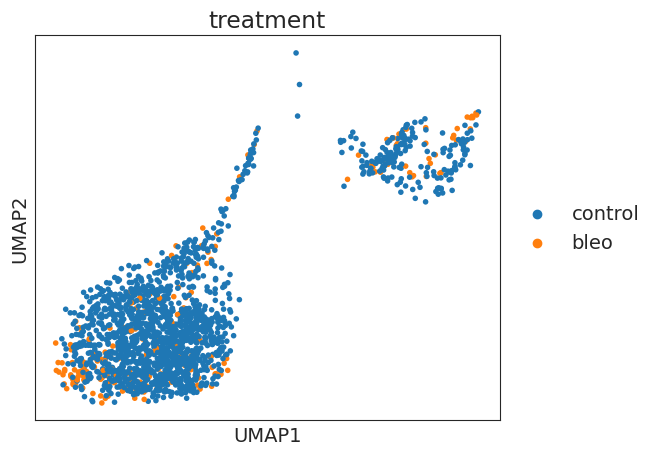

Started Diffxpy Calculation:	14-08-2024 17:20:22
training location model: True
training scale model: True
iter   0: ll=3983850.275081
caught 1 linalg singular matrix errors
iter   1: ll=3663447.944737, converged: 0.00% (loc: 2.71%, scale update: False), in 0.81sec
iter   2: ll=3582641.048590, converged: 0.00% (loc: 2.71%, scale update: False), in 0.73sec
iter   3: ll=3574294.380361, converged: 0.00% (loc: 2.71%, scale update: False), in 0.77sec
iter   4: ll=3573937.780306, converged: 0.00% (loc: 2.71%, scale update: False), in 0.72sec
iter   5: ll=3573925.876043, converged: 0.00% (loc: 3.14%, scale update: False), in 0.80sec
iter   6: ll=1891060.572461, converged: 0.00% (loc: 0.00%, scale update: True), in 5.51sec
caught 1 linalg singular matrix errors
iter   7: ll=1888752.547264, converged: 0.00% (loc: 0.24%, scale update: False), in 0.93sec
iter   8: ll=1888398.057366, converged: 0.00% (loc: 1.35%, scale update: False), in 0.85sec
iter   9: ll=1888377.302037, converged: 0.00% (loc: 1

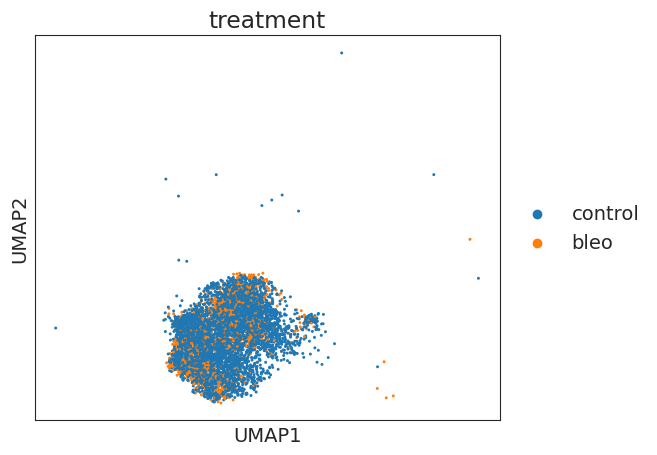

Started Diffxpy Calculation:	14-08-2024 17:21:08
training location model: True
training scale model: True
iter   0: ll=10786498.757191
iter   1: ll=9750825.076873, converged: 0.00% (loc: 0.00%, scale update: False), in 1.63sec
iter   2: ll=9528866.709284, converged: 0.00% (loc: 0.00%, scale update: False), in 1.56sec
iter   3: ll=9518208.533328, converged: 0.00% (loc: 0.00%, scale update: False), in 2.06sec
iter   4: ll=9518177.431158, converged: 0.00% (loc: 0.00%, scale update: False), in 2.39sec
iter   5: ll=9518177.426516, converged: 0.00% (loc: 38.17%, scale update: False), in 2.16sec
iter   6: ll=9369901.137536, converged: 0.00% (loc: 0.00%, scale update: True), in 21.58sec
iter   7: ll=9369762.801902, converged: 0.00% (loc: 0.07%, scale update: False), in 2.74sec
iter   8: ll=9369762.362631, converged: 0.00% (loc: 14.55%, scale update: False), in 1.96sec
iter   9: ll=9369762.359713, converged: 0.00% (loc: 93.46%, scale update: False), in 2.10sec
iter  10: ll=9369762.359659, conve

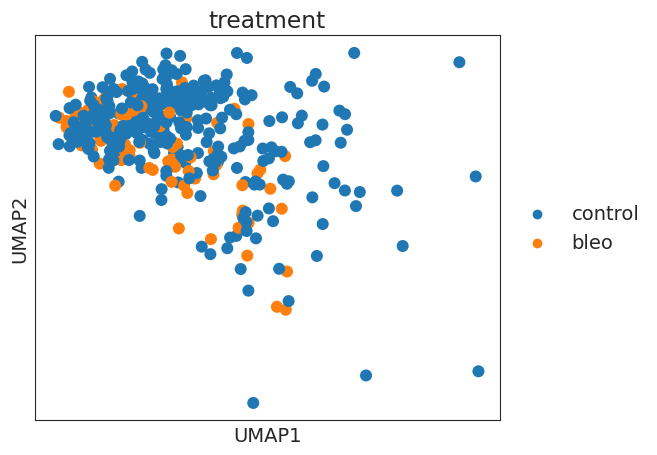

Started Diffxpy Calculation:	14-08-2024 17:22:58
training location model: True
training scale model: True
iter   0: ll=612630.786357
caught 9 linalg singular matrix errors
iter   1: ll=554296.357719, converged: 0.00% (loc: 0.30%, scale update: False), in 0.42sec
iter   2: ll=541485.036510, converged: 0.00% (loc: 0.30%, scale update: False), in 0.36sec
iter   3: ll=540832.242475, converged: 0.00% (loc: 0.30%, scale update: False), in 0.67sec
iter   4: ll=540829.793308, converged: 0.00% (loc: 0.30%, scale update: False), in 0.39sec
iter   5: ll=540829.792027, converged: 0.00% (loc: 30.55%, scale update: False), in 0.32sec
iter   6: ll=528788.718793, converged: 0.00% (loc: 0.00%, scale update: True), in 3.11sec
caught 9 linalg singular matrix errors
iter   7: ll=528761.620332, converged: 0.00% (loc: 0.60%, scale update: False), in 0.41sec
iter   8: ll=528761.500530, converged: 0.00% (loc: 9.87%, scale update: False), in 0.30sec
iter   9: ll=528761.500339, converged: 0.00% (loc: 81.25%, sc

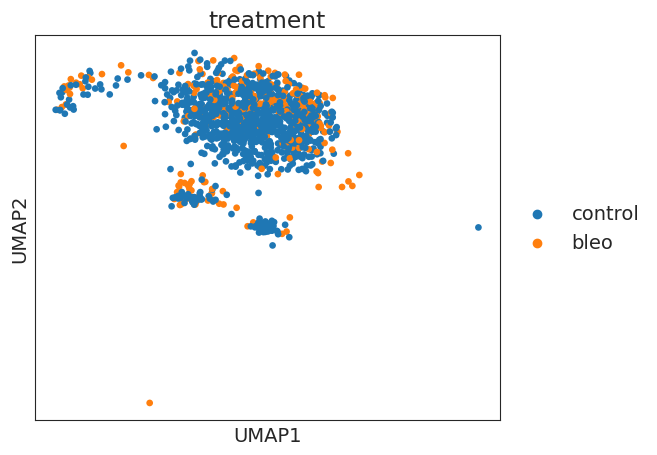

Started Diffxpy Calculation:	14-08-2024 17:23:21
training location model: True
training scale model: True
iter   0: ll=1341768.148609
iter   1: ll=1199616.354958, converged: 0.00% (loc: 0.00%, scale update: False), in 1.08sec
iter   2: ll=1161794.392064, converged: 0.00% (loc: 0.00%, scale update: False), in 0.92sec
iter   3: ll=1159150.076096, converged: 0.00% (loc: 0.00%, scale update: False), in 0.93sec
iter   4: ll=1159135.640688, converged: 0.00% (loc: 0.00%, scale update: False), in 0.82sec
iter   5: ll=1159135.639457, converged: 0.00% (loc: 20.43%, scale update: False), in 0.92sec
iter   6: ll=1134728.105059, converged: 0.00% (loc: 0.00%, scale update: True), in 5.85sec
iter   7: ll=1134715.843031, converged: 0.00% (loc: 0.05%, scale update: False), in 0.79sec
iter   8: ll=1134715.826556, converged: 0.00% (loc: 17.97%, scale update: False), in 0.76sec
iter   9: ll=1134715.826527, converged: 0.00% (loc: 94.98%, scale update: False), in 0.54sec
iter  10: ll=1134715.826527, converg

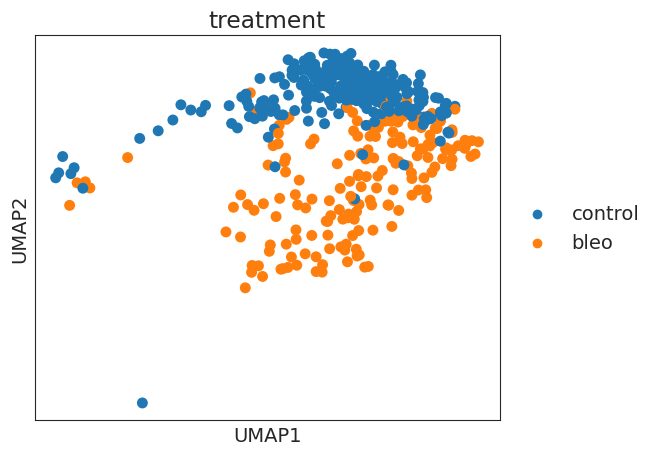

Started Diffxpy Calculation:	14-08-2024 17:23:48
training location model: True
training scale model: True
iter   0: ll=3866915.661306
caught 26 linalg singular matrix errors
iter   1: ll=3683351.522242, converged: 0.00% (loc: 4.59%, scale update: False), in 0.55sec
iter   2: ll=3629242.006234, converged: 0.00% (loc: 4.59%, scale update: False), in 0.57sec
iter   3: ll=3620662.622983, converged: 0.00% (loc: 4.59%, scale update: False), in 0.79sec
iter   4: ll=3619685.568957, converged: 0.00% (loc: 4.59%, scale update: False), in 0.56sec
iter   5: ll=3619578.405646, converged: 0.00% (loc: 4.63%, scale update: False), in 0.62sec
iter   6: ll=1480524.465271, converged: 0.00% (loc: 0.00%, scale update: True), in 7.61sec
caught 24 linalg singular matrix errors
iter   7: ll=1474751.228584, converged: 0.00% (loc: 0.45%, scale update: False), in 0.58sec
iter   8: ll=1473933.111130, converged: 0.00% (loc: 1.04%, scale update: False), in 1.21sec
iter   9: ll=1473814.712693, converged: 0.00% (loc:

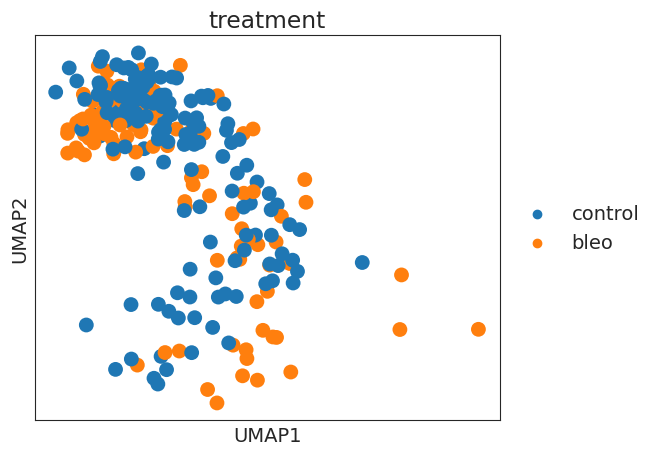

Started Diffxpy Calculation:	14-08-2024 17:25:15
training location model: True
training scale model: True
iter   0: ll=636983.187277
caught 19 linalg singular matrix errors
iter   1: ll=577821.987865, converged: 0.00% (loc: 0.50%, scale update: False), in 0.52sec
iter   2: ll=565415.443717, converged: 0.00% (loc: 0.50%, scale update: False), in 0.71sec
iter   3: ll=564729.189680, converged: 0.00% (loc: 0.50%, scale update: False), in 0.46sec
iter   4: ll=564722.665879, converged: 0.00% (loc: 0.50%, scale update: False), in 0.44sec
iter   5: ll=564722.618434, converged: 0.00% (loc: 8.40%, scale update: False), in 0.42sec
iter   6: ll=541087.167801, converged: 0.00% (loc: 0.00%, scale update: True), in 4.23sec
caught 19 linalg singular matrix errors
iter   7: ll=540943.766274, converged: 0.00% (loc: 0.94%, scale update: False), in 0.46sec
iter   8: ll=540939.767533, converged: 0.00% (loc: 3.75%, scale update: False), in 0.48sec
iter   9: ll=540939.457650, converged: 0.00% (loc: 27.62%, s

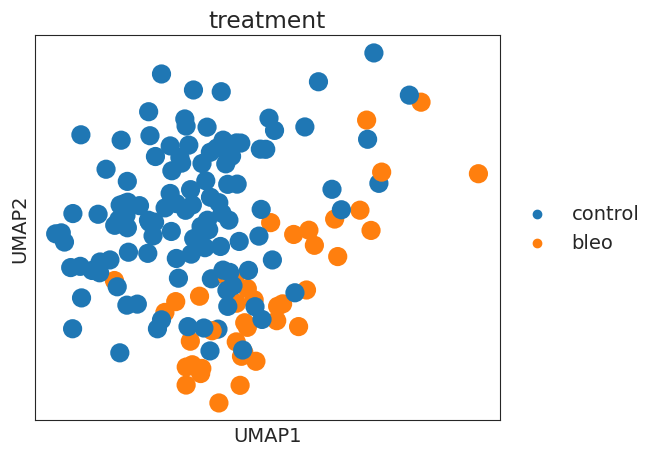

Started Diffxpy Calculation:	14-08-2024 17:26:02
training location model: True
training scale model: True
iter   0: ll=883900.687250
caught 142 linalg singular matrix errors
iter   1: ll=833328.634938, converged: 0.00% (loc: 6.44%, scale update: False), in 0.48sec
iter   2: ll=822348.936665, converged: 0.00% (loc: 6.44%, scale update: False), in 0.51sec
iter   3: ll=821594.296947, converged: 0.00% (loc: 6.44%, scale update: False), in 0.53sec
iter   4: ll=821580.224806, converged: 0.00% (loc: 6.44%, scale update: False), in 0.70sec
iter   5: ll=821580.004856, converged: 0.00% (loc: 7.93%, scale update: False), in 0.48sec
iter   6: ll=362961.098650, converged: 0.00% (loc: 0.00%, scale update: True), in 4.21sec
caught 142 linalg singular matrix errors
iter   7: ll=362421.522645, converged: 0.00% (loc: 4.62%, scale update: False), in 0.57sec
iter   8: ll=362362.428585, converged: 0.00% (loc: 7.41%, scale update: False), in 0.54sec
iter   9: ll=362360.187548, converged: 0.00% (loc: 25.91%,

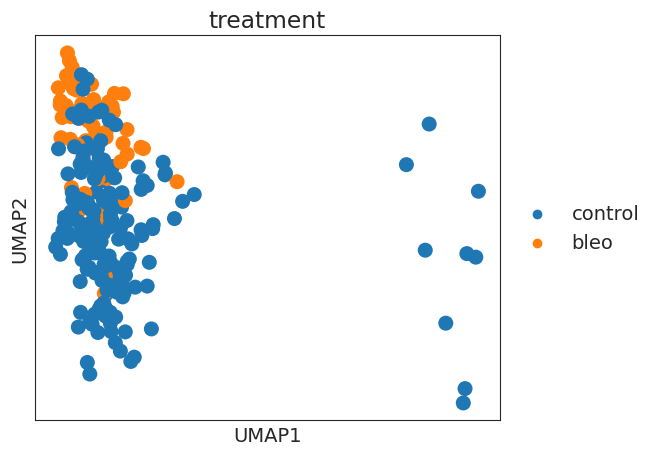

Started Diffxpy Calculation:	14-08-2024 17:26:57
training location model: True
training scale model: True
iter   0: ll=2424495.906132
caught 38 linalg singular matrix errors
iter   1: ll=2322360.678442, converged: 0.00% (loc: 6.95%, scale update: False), in 0.52sec
iter   2: ll=2295586.259287, converged: 0.00% (loc: 6.95%, scale update: False), in 0.59sec
iter   3: ll=2292395.173983, converged: 0.00% (loc: 6.95%, scale update: False), in 0.78sec
iter   4: ll=2292189.888403, converged: 0.00% (loc: 6.95%, scale update: False), in 0.54sec
iter   5: ll=2292178.018995, converged: 0.00% (loc: 6.97%, scale update: False), in 0.57sec
iter   6: ll=697864.816064, converged: 0.00% (loc: 0.00%, scale update: True), in 4.31sec
caught 38 linalg singular matrix errors
iter   7: ll=690986.531024, converged: 0.00% (loc: 1.02%, scale update: False), in 0.56sec
iter   8: ll=689483.958334, converged: 0.00% (loc: 1.78%, scale update: False), in 1.53sec
iter   9: ll=689273.704708, converged: 0.00% (loc: 6.7

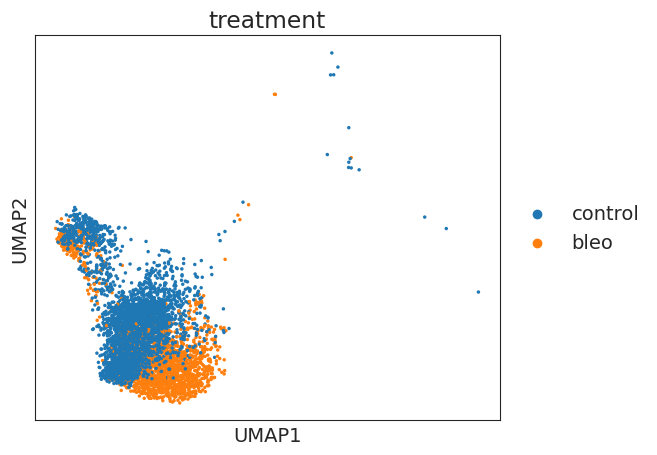

Started Diffxpy Calculation:	14-08-2024 17:28:06
training location model: True
training scale model: True
iter   0: ll=10859157.034298
iter   1: ll=9878540.503196, converged: 0.00% (loc: 0.00%, scale update: False), in 3.06sec
iter   2: ll=9662152.896858, converged: 0.00% (loc: 0.00%, scale update: False), in 2.68sec
iter   3: ll=9650287.922558, converged: 0.00% (loc: 0.00%, scale update: False), in 3.34sec
iter   4: ll=9650224.288584, converged: 0.00% (loc: 0.00%, scale update: False), in 2.46sec
iter   5: ll=9650224.233240, converged: 0.00% (loc: 2.33%, scale update: False), in 3.17sec
iter   6: ll=9480827.292406, converged: 0.00% (loc: 0.00%, scale update: True), in 21.86sec
iter   7: ll=9480030.335250, converged: 0.00% (loc: 0.00%, scale update: False), in 3.13sec
iter   8: ll=9480025.384662, converged: 0.00% (loc: 1.68%, scale update: False), in 3.12sec
iter   9: ll=9480025.360333, converged: 0.00% (loc: 17.11%, scale update: False), in 3.15sec
iter  10: ll=9480025.360192, converg

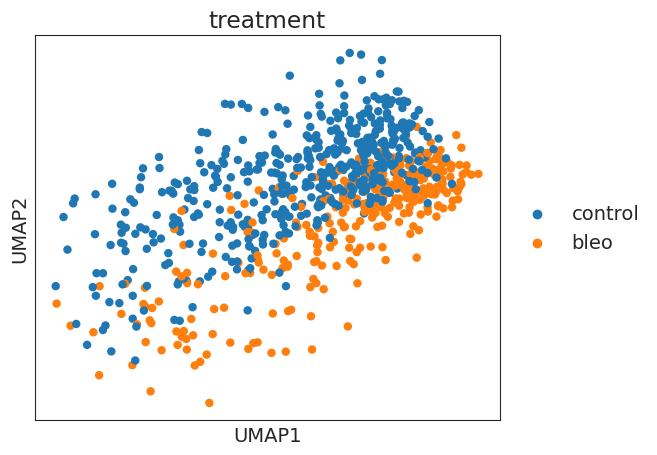

Started Diffxpy Calculation:	14-08-2024 17:30:24
training location model: True
training scale model: True
iter   0: ll=2367221.221081
caught 1 linalg singular matrix errors
iter   1: ll=2128423.724934, converged: 0.00% (loc: 0.12%, scale update: False), in 0.45sec
iter   2: ll=2074344.584477, converged: 0.00% (loc: 0.12%, scale update: False), in 0.46sec
iter   3: ll=2070549.688387, converged: 0.00% (loc: 0.12%, scale update: False), in 0.44sec
iter   4: ll=2070488.718696, converged: 0.00% (loc: 0.12%, scale update: False), in 0.61sec
iter   5: ll=2070488.129192, converged: 0.00% (loc: 0.57%, scale update: False), in 0.44sec
iter   6: ll=2002142.638983, converged: 0.00% (loc: 0.00%, scale update: True), in 7.60sec
caught 1 linalg singular matrix errors
iter   7: ll=2001785.096481, converged: 0.00% (loc: 0.04%, scale update: False), in 0.49sec
iter   8: ll=2001754.234376, converged: 0.00% (loc: 1.97%, scale update: False), in 0.52sec
iter   9: ll=2001746.236489, converged: 0.00% (loc: 1

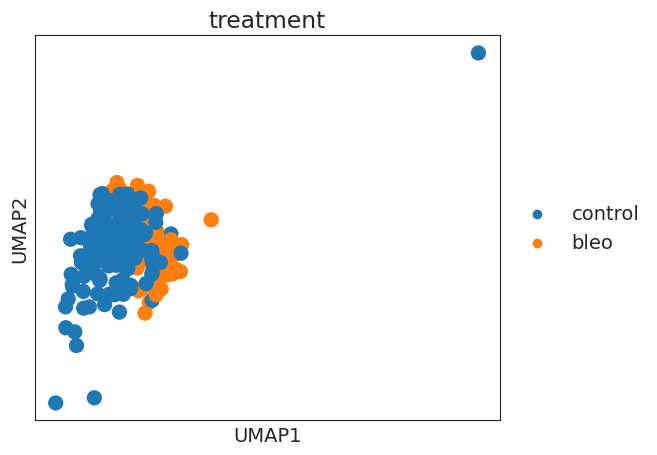

Started Diffxpy Calculation:	14-08-2024 17:31:15
training location model: True
training scale model: True
iter   0: ll=3272222.475574
caught 42 linalg singular matrix errors
iter   1: ll=3143707.427621, converged: 0.00% (loc: 7.59%, scale update: False), in 0.65sec
iter   2: ll=3105491.075218, converged: 0.00% (loc: 7.59%, scale update: False), in 0.69sec
iter   3: ll=3099586.106319, converged: 0.00% (loc: 7.59%, scale update: False), in 0.94sec
iter   4: ll=3099025.198180, converged: 0.00% (loc: 7.59%, scale update: False), in 0.55sec
iter   5: ll=3098975.031534, converged: 0.00% (loc: 7.60%, scale update: False), in 0.84sec
iter   6: ll=875056.274651, converged: 0.00% (loc: 0.00%, scale update: True), in 5.36sec
caught 41 linalg singular matrix errors
iter   7: ll=868075.926717, converged: 0.00% (loc: 1.31%, scale update: False), in 0.76sec
iter   8: ll=866603.045599, converged: 0.00% (loc: 1.85%, scale update: False), in 1.74sec
iter   9: ll=866382.437231, converged: 0.00% (loc: 3.9

iter  87: ll=828329.951090, converged: 99.89% (loc: 99.98%, scale update: False), in 0.12sec
iter  88: ll=828329.951090, converged: 99.89% (loc: 99.98%, scale update: False), in 0.11sec
iter  89: ll=828329.951090, converged: 99.89% (loc: 100.00%, scale update: False), in 0.08sec
iter  90: ll=828329.951081, converged: 99.94% (loc: 99.94%, scale update: True), in 0.97sec
iter  91: ll=828329.951076, converged: 99.94% (loc: 99.95%, scale update: False), in 0.13sec
iter  92: ll=828329.951076, converged: 99.94% (loc: 99.97%, scale update: False), in 0.13sec
iter  93: ll=828329.951076, converged: 99.94% (loc: 99.98%, scale update: False), in 0.12sec
iter  94: ll=828329.951076, converged: 99.94% (loc: 100.00%, scale update: False), in 0.11sec
iter  95: ll=828329.951073, converged: 99.95% (loc: 99.95%, scale update: True), in 0.91sec
iter  96: ll=828329.951071, converged: 99.95% (loc: 99.95%, scale update: False), in 0.14sec
iter  97: ll=828329.951071, converged: 99.95% (loc: 99.98%, scale upda

In [19]:
subset = ["control", "bleo"]
condition = "treatment"
ct_label = "meta_label"
min_cells = 10

time = "d10"
time_subset = adata[adata.obs.time_point.isin([time, "d0"])].copy()
sc.pl.umap(time_subset, color = ["day", "meta_label"], size = 10, wspace = 0.25)

for ct in cell_types:
    
    print("%s - %s" %(ct, time))
    dge(time_subset, ct = ct, ct_label = ct_label, condition = condition, ref = "control", pct_thresh = 0.05,
              subset = subset, min_cells = min_cells, do_return = False, suffix = "_old")
    
    

 ## day 20

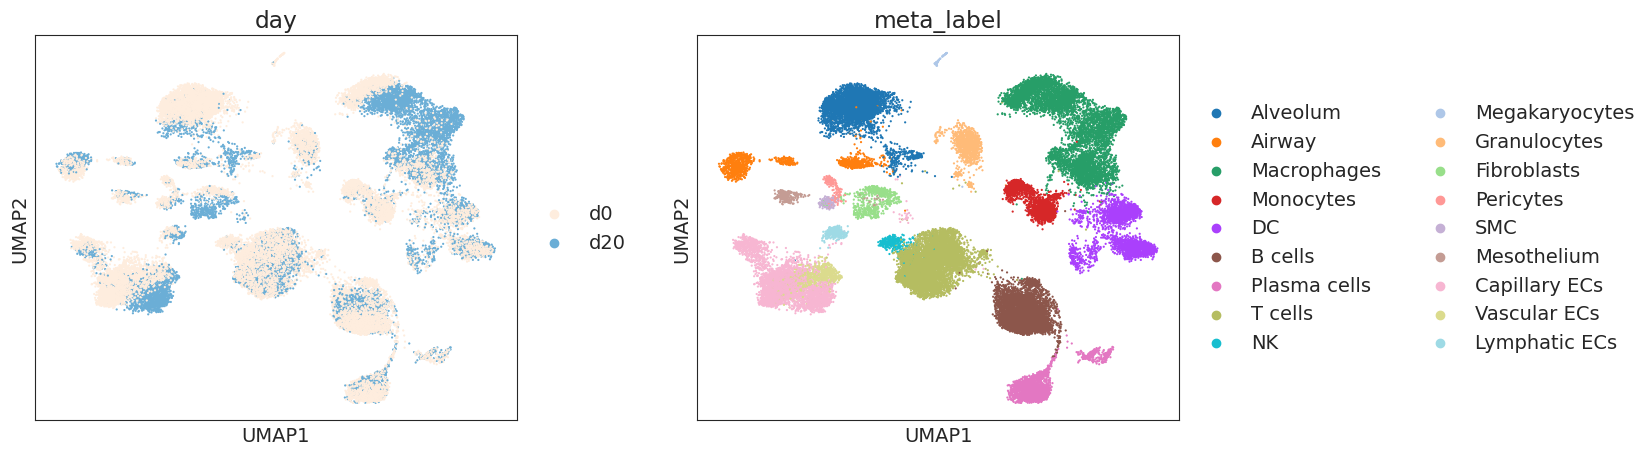

Alveolum - d20
(4524, 4453)


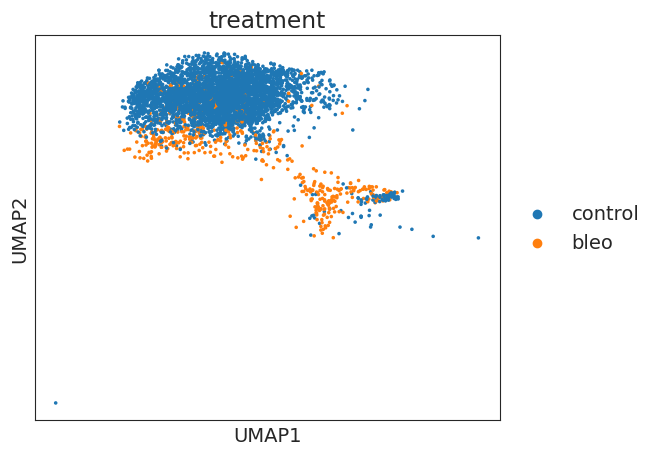

Started Diffxpy Calculation:	14-08-2024 17:32:29
training location model: True
training scale model: True
iter   0: ll=9812597.512963
iter   1: ll=8720664.449503, converged: 0.00% (loc: 0.02%, scale update: False), in 1.78sec
iter   2: ll=8486480.906119, converged: 0.00% (loc: 0.02%, scale update: False), in 2.04sec
iter   3: ll=8472072.084776, converged: 0.00% (loc: 0.02%, scale update: False), in 2.04sec
iter   4: ll=8471903.995981, converged: 0.00% (loc: 0.02%, scale update: False), in 1.94sec
iter   5: ll=8471902.621446, converged: 0.00% (loc: 1.10%, scale update: False), in 1.98sec
iter   6: ll=8356781.780659, converged: 0.00% (loc: 0.00%, scale update: True), in 20.83sec
iter   7: ll=8356241.481275, converged: 0.00% (loc: 0.02%, scale update: False), in 1.79sec
iter   8: ll=8356235.325979, converged: 0.00% (loc: 2.36%, scale update: False), in 1.78sec
iter   9: ll=8356235.227426, converged: 0.00% (loc: 14.73%, scale update: False), in 1.93sec
iter  10: ll=8356235.225337, converge

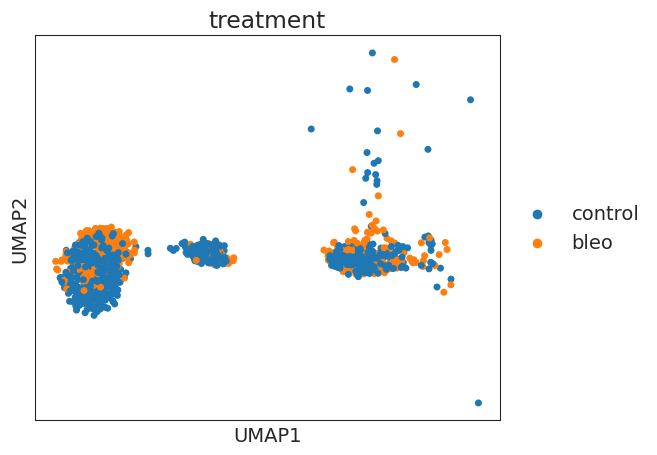

Started Diffxpy Calculation:	14-08-2024 17:34:28
training location model: True
training scale model: True
iter   0: ll=23025211.909440
iter   1: ll=22069415.271861, converged: 0.00% (loc: 8.26%, scale update: False), in 1.47sec
iter   2: ll=21710670.576827, converged: 0.00% (loc: 8.26%, scale update: False), in 1.60sec
iter   3: ll=21622041.202771, converged: 0.00% (loc: 8.26%, scale update: False), in 1.55sec
iter   4: ll=21607134.134047, converged: 0.00% (loc: 8.26%, scale update: False), in 1.18sec
iter   5: ll=21605338.657557, converged: 0.00% (loc: 8.26%, scale update: False), in 1.08sec
iter   6: ll=4342529.525282, converged: 0.00% (loc: 0.00%, scale update: True), in 10.90sec
iter   7: ll=4302461.825211, converged: 0.00% (loc: 0.03%, scale update: False), in 1.26sec
iter   8: ll=4297805.950028, converged: 0.00% (loc: 0.35%, scale update: False), in 1.10sec
iter   9: ll=4297306.389334, converged: 0.00% (loc: 1.22%, scale update: False), in 1.31sec
iter  10: ll=4297282.605822, con

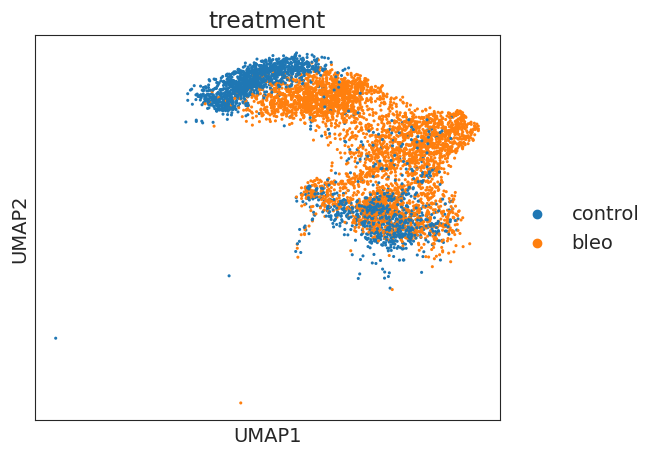

Started Diffxpy Calculation:	14-08-2024 17:36:23
training location model: True
training scale model: True
iter   0: ll=15998177.058232
caught 1 linalg singular matrix errors
iter   1: ll=14332221.367718, converged: 0.00% (loc: 0.02%, scale update: False), in 2.11sec
iter   2: ll=13951457.146165, converged: 0.00% (loc: 0.02%, scale update: False), in 2.26sec
iter   3: ll=13925127.773725, converged: 0.00% (loc: 0.02%, scale update: False), in 2.25sec
iter   4: ll=13924767.140374, converged: 0.00% (loc: 0.02%, scale update: False), in 2.34sec
iter   5: ll=13924764.994353, converged: 0.00% (loc: 0.59%, scale update: False), in 2.12sec
iter   6: ll=13850845.191576, converged: 0.00% (loc: 0.00%, scale update: True), in 29.94sec
caught 1 linalg singular matrix errors
iter   7: ll=13849697.745660, converged: 0.00% (loc: 0.02%, scale update: False), in 3.32sec
iter   8: ll=13849683.387123, converged: 0.00% (loc: 2.50%, scale update: False), in 3.20sec
iter   9: ll=13849683.218977, converged: 0.

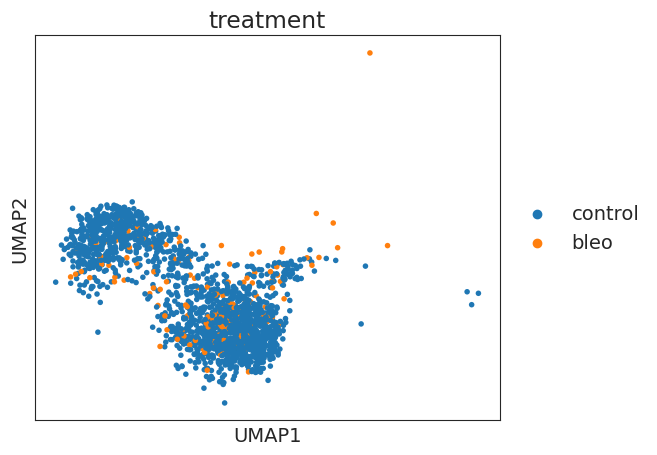

Started Diffxpy Calculation:	14-08-2024 17:39:22
training location model: True
training scale model: True
iter   0: ll=4030289.779330
caught 2 linalg singular matrix errors
iter   1: ll=3618941.028450, converged: 0.00% (loc: 0.06%, scale update: False), in 1.05sec
iter   2: ll=3536492.338304, converged: 0.00% (loc: 0.06%, scale update: False), in 1.22sec
iter   3: ll=3532845.647434, converged: 0.00% (loc: 0.06%, scale update: False), in 0.94sec
iter   4: ll=3532834.641106, converged: 0.00% (loc: 0.06%, scale update: False), in 0.98sec
iter   5: ll=3532834.636216, converged: 0.00% (loc: 37.65%, scale update: False), in 1.02sec
iter   6: ll=3478143.519492, converged: 0.00% (loc: 0.00%, scale update: True), in 10.67sec
caught 2 linalg singular matrix errors
iter   7: ll=3478066.388025, converged: 0.00% (loc: 0.06%, scale update: False), in 1.44sec
iter   8: ll=3478066.267808, converged: 0.00% (loc: 11.13%, scale update: False), in 1.81sec
iter   9: ll=3478066.267667, converged: 0.00% (loc

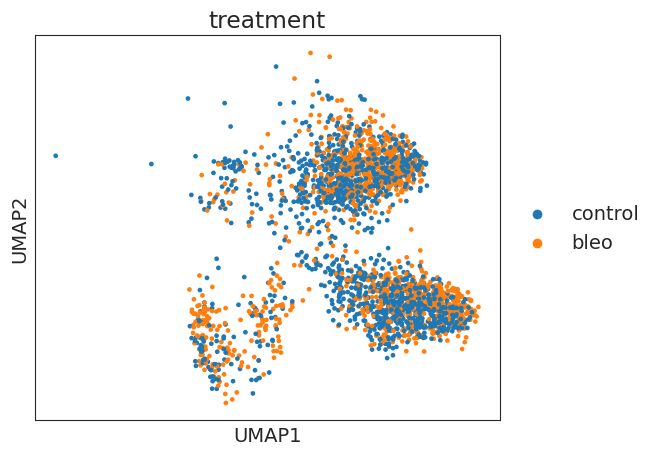

Started Diffxpy Calculation:	14-08-2024 17:40:14
training location model: True
training scale model: True
iter   0: ll=6240992.787572
iter   1: ll=5564087.314280, converged: 0.00% (loc: 0.00%, scale update: False), in 1.19sec
iter   2: ll=5422830.564767, converged: 0.00% (loc: 0.00%, scale update: False), in 1.83sec
iter   3: ll=5415274.350987, converged: 0.00% (loc: 0.00%, scale update: False), in 2.11sec
iter   4: ll=5415223.804880, converged: 0.00% (loc: 0.00%, scale update: False), in 1.84sec
iter   5: ll=5415223.702398, converged: 0.00% (loc: 1.28%, scale update: False), in 1.97sec
iter   6: ll=5381176.425667, converged: 0.00% (loc: 0.00%, scale update: True), in 13.05sec
iter   7: ll=5380905.775115, converged: 0.00% (loc: 0.07%, scale update: False), in 1.83sec
iter   8: ll=5380903.974806, converged: 0.00% (loc: 2.95%, scale update: False), in 1.53sec
iter   9: ll=5380903.964821, converged: 0.00% (loc: 23.38%, scale update: False), in 1.28sec
iter  10: ll=5380903.964760, converge

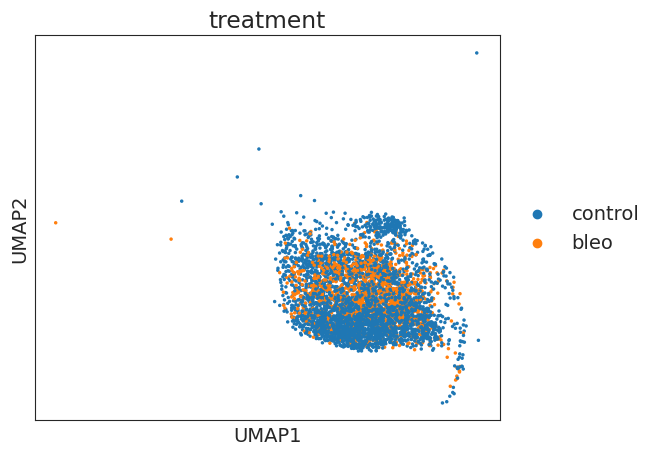

Started Diffxpy Calculation:	14-08-2024 17:41:40
training location model: True
training scale model: True
iter   0: ll=7523832.364084
iter   1: ll=6817357.774549, converged: 0.00% (loc: 0.00%, scale update: False), in 1.38sec
iter   2: ll=6647840.415933, converged: 0.00% (loc: 0.00%, scale update: False), in 1.37sec
iter   3: ll=6637680.311701, converged: 0.00% (loc: 0.00%, scale update: False), in 1.44sec
iter   4: ll=6637625.750817, converged: 0.00% (loc: 0.00%, scale update: False), in 1.34sec
iter   5: ll=6637625.705726, converged: 0.00% (loc: 12.04%, scale update: False), in 1.40sec
iter   6: ll=6499799.837617, converged: 0.00% (loc: 0.00%, scale update: True), in 16.26sec
iter   7: ll=6499442.822488, converged: 0.00% (loc: 0.00%, scale update: False), in 1.47sec
iter   8: ll=6499440.362239, converged: 0.00% (loc: 2.68%, scale update: False), in 1.30sec
iter   9: ll=6499440.341596, converged: 0.00% (loc: 42.83%, scale update: False), in 1.23sec
iter  10: ll=6499440.341040, converg

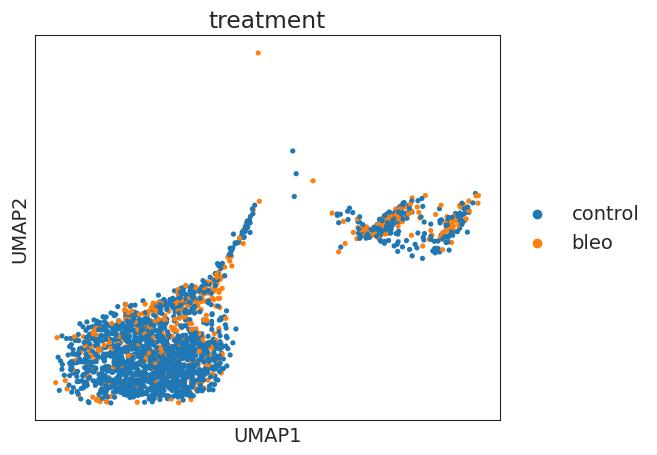

Started Diffxpy Calculation:	14-08-2024 17:43:05
training location model: True
training scale model: True
iter   0: ll=2505800.334810
iter   1: ll=2206292.218666, converged: 0.00% (loc: 0.11%, scale update: False), in 0.79sec
iter   2: ll=2136325.364477, converged: 0.00% (loc: 0.11%, scale update: False), in 0.77sec
iter   3: ll=2130781.999151, converged: 0.00% (loc: 0.11%, scale update: False), in 0.71sec
iter   4: ll=2130669.897212, converged: 0.00% (loc: 0.11%, scale update: False), in 0.77sec
iter   5: ll=2130668.780942, converged: 0.00% (loc: 1.33%, scale update: False), in 0.79sec
iter   6: ll=2014564.801924, converged: 0.00% (loc: 0.00%, scale update: True), in 5.58sec
iter   7: ll=2014335.071501, converged: 0.00% (loc: 0.17%, scale update: False), in 0.91sec
iter   8: ll=2014314.742233, converged: 0.00% (loc: 3.55%, scale update: False), in 0.67sec
iter   9: ll=2014313.581309, converged: 0.00% (loc: 29.53%, scale update: False), in 0.77sec
iter  10: ll=2014313.570819, converged

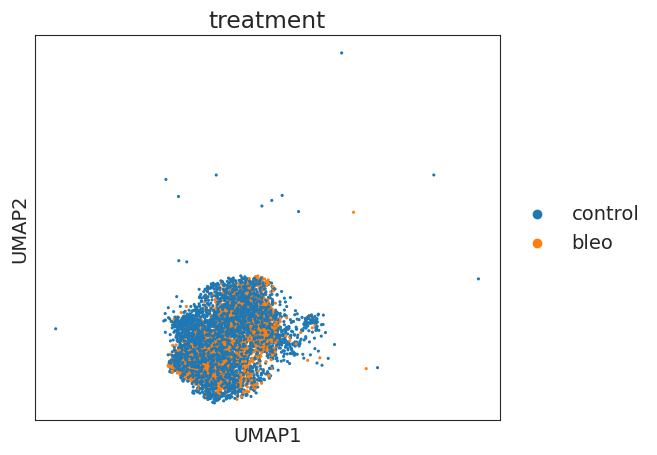

Started Diffxpy Calculation:	14-08-2024 17:43:41
training location model: True
training scale model: True
iter   0: ll=8870320.820291
iter   1: ll=8014986.810247, converged: 0.00% (loc: 0.00%, scale update: False), in 1.73sec
iter   2: ll=7819616.360177, converged: 0.00% (loc: 0.00%, scale update: False), in 1.54sec
iter   3: ll=7809073.981608, converged: 0.00% (loc: 0.00%, scale update: False), in 1.66sec
iter   4: ll=7809037.022925, converged: 0.00% (loc: 0.00%, scale update: False), in 1.61sec
iter   5: ll=7809037.019653, converged: 0.00% (loc: 32.28%, scale update: False), in 1.60sec
iter   6: ll=7650163.485548, converged: 0.00% (loc: 0.00%, scale update: True), in 18.76sec
iter   7: ll=7650031.866794, converged: 0.00% (loc: 0.03%, scale update: False), in 1.57sec
iter   8: ll=7650031.522070, converged: 0.00% (loc: 13.75%, scale update: False), in 2.10sec
iter   9: ll=7650031.520967, converged: 0.00% (loc: 92.03%, scale update: False), in 1.59sec
iter  10: ll=7650031.520960, conver

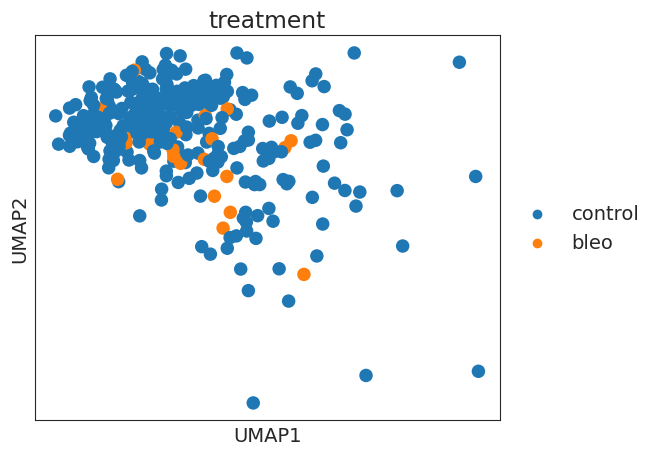

Started Diffxpy Calculation:	14-08-2024 17:45:08
training location model: True
training scale model: True
iter   0: ll=490416.088244
caught 495 linalg singular matrix errors
iter   1: ll=447983.600831, converged: 0.00% (loc: 16.29%, scale update: False), in 0.35sec
iter   2: ll=438495.477201, converged: 0.00% (loc: 16.29%, scale update: False), in 0.37sec
iter   3: ll=437988.036586, converged: 0.00% (loc: 16.29%, scale update: False), in 0.37sec
iter   4: ll=437985.230580, converged: 0.00% (loc: 16.29%, scale update: False), in 0.41sec
iter   5: ll=437985.222259, converged: 0.00% (loc: 30.28%, scale update: False), in 0.41sec
iter   6: ll=428590.878418, converged: 0.00% (loc: 0.00%, scale update: True), in 2.99sec
caught 495 linalg singular matrix errors
iter   7: ll=428556.762878, converged: 0.00% (loc: 16.95%, scale update: False), in 0.35sec
iter   8: ll=428556.450881, converged: 0.00% (loc: 21.56%, scale update: False), in 0.40sec
iter   9: ll=428556.448711, converged: 0.00% (loc: 

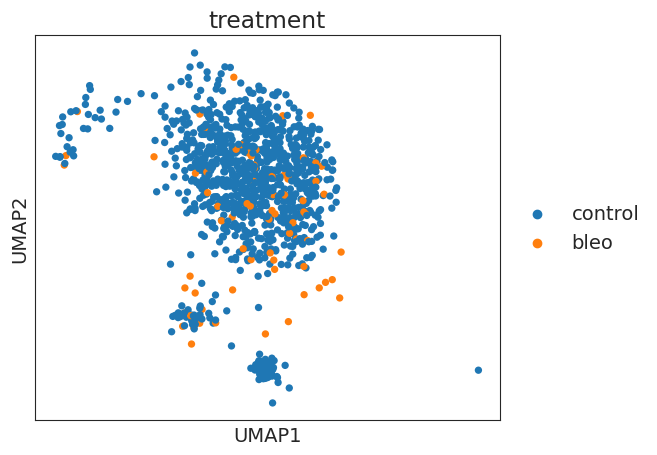

Started Diffxpy Calculation:	14-08-2024 17:45:30
training location model: True
training scale model: True
iter   0: ll=1112879.175418
caught 19 linalg singular matrix errors
iter   1: ll=994913.012291, converged: 0.00% (loc: 0.98%, scale update: False), in 0.56sec
iter   2: ll=962442.661139, converged: 0.00% (loc: 0.98%, scale update: False), in 0.65sec
iter   3: ll=960020.296298, converged: 0.00% (loc: 0.98%, scale update: False), in 0.79sec
iter   4: ll=960004.176056, converged: 0.00% (loc: 0.98%, scale update: False), in 0.69sec
iter   5: ll=960004.167666, converged: 0.00% (loc: 8.70%, scale update: False), in 0.53sec
iter   6: ll=939249.795805, converged: 0.00% (loc: 0.00%, scale update: True), in 3.90sec
caught 19 linalg singular matrix errors
iter   7: ll=939232.573076, converged: 0.00% (loc: 1.04%, scale update: False), in 0.64sec
iter   8: ll=939232.265656, converged: 0.00% (loc: 9.58%, scale update: False), in 0.46sec
iter   9: ll=939232.259083, converged: 0.00% (loc: 70.43%, 

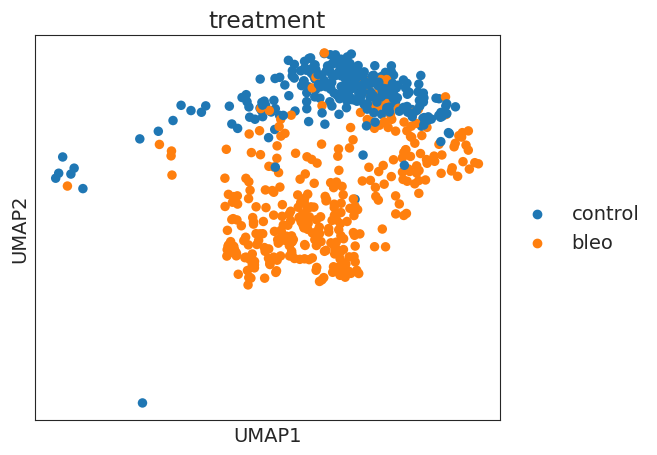

Started Diffxpy Calculation:	14-08-2024 17:45:59
training location model: True
training scale model: True
iter   0: ll=4178581.038487
caught 49 linalg singular matrix errors
iter   1: ll=3938980.459050, converged: 0.00% (loc: 3.32%, scale update: False), in 0.61sec
iter   2: ll=3870760.996299, converged: 0.00% (loc: 3.32%, scale update: False), in 0.75sec
iter   3: ll=3861664.572281, converged: 0.00% (loc: 3.32%, scale update: False), in 0.59sec
iter   4: ll=3861027.718662, converged: 0.00% (loc: 3.32%, scale update: False), in 0.57sec
iter   5: ll=3860992.356898, converged: 0.00% (loc: 3.37%, scale update: False), in 0.61sec
iter   6: ll=1909551.308500, converged: 0.00% (loc: 0.00%, scale update: True), in 6.60sec
caught 48 linalg singular matrix errors
iter   7: ll=1903605.097149, converged: 0.00% (loc: 0.84%, scale update: False), in 0.54sec
iter   8: ll=1902720.891719, converged: 0.00% (loc: 1.81%, scale update: False), in 0.72sec
iter   9: ll=1902616.730950, converged: 0.00% (loc:

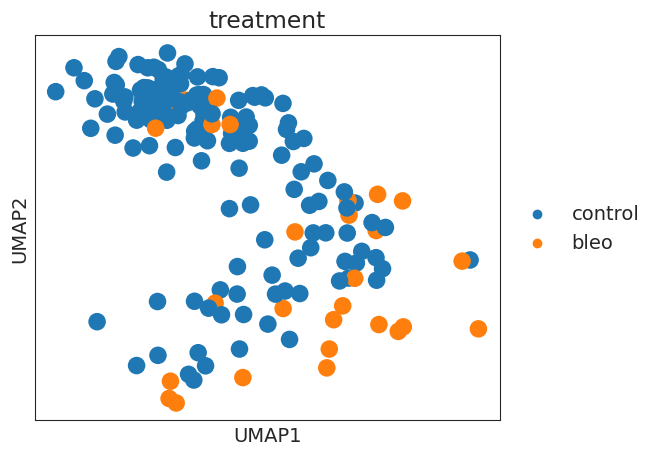

Started Diffxpy Calculation:	14-08-2024 17:47:12
training location model: True
training scale model: True
iter   0: ll=425239.833995
caught 349 linalg singular matrix errors
iter   1: ll=387831.087805, converged: 0.00% (loc: 7.49%, scale update: False), in 0.37sec
iter   2: ll=380202.876021, converged: 0.00% (loc: 7.49%, scale update: False), in 0.38sec
iter   3: ll=379813.742900, converged: 0.00% (loc: 7.49%, scale update: False), in 0.38sec
iter   4: ll=379810.749048, converged: 0.00% (loc: 7.52%, scale update: False), in 0.41sec
iter   5: ll=379810.730552, converged: 0.00% (loc: 24.80%, scale update: False), in 0.47sec
iter   6: ll=357552.806689, converged: 0.02% (loc: 0.02%, scale update: True), in 4.74sec
caught 348 linalg singular matrix errors
iter   7: ll=357488.150215, converged: 0.02% (loc: 9.71%, scale update: False), in 0.49sec
iter   8: ll=357487.636654, converged: 0.02% (loc: 14.65%, scale update: False), in 0.70sec
iter   9: ll=357487.633576, converged: 0.02% (loc: 56.95

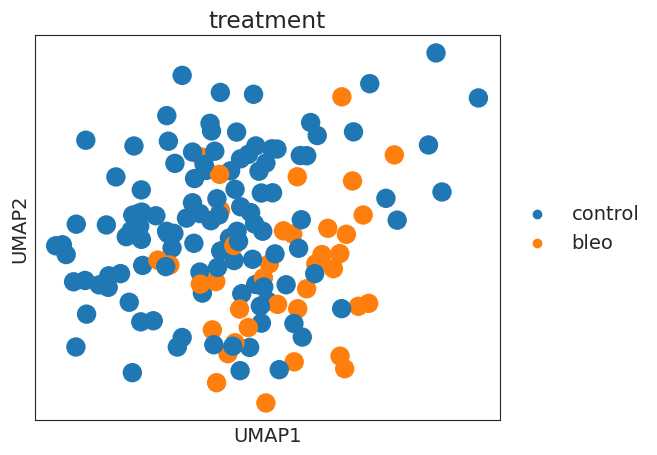

Started Diffxpy Calculation:	14-08-2024 17:47:50
training location model: True
training scale model: True
iter   0: ll=731425.545888
caught 242 linalg singular matrix errors
iter   1: ll=684455.568443, converged: 0.00% (loc: 7.24%, scale update: False), in 0.62sec
iter   2: ll=674141.359272, converged: 0.00% (loc: 7.24%, scale update: False), in 1.10sec
iter   3: ll=673432.409209, converged: 0.00% (loc: 7.24%, scale update: False), in 0.47sec
iter   4: ll=673419.436758, converged: 0.00% (loc: 7.24%, scale update: False), in 0.95sec
iter   5: ll=673419.242281, converged: 0.00% (loc: 9.03%, scale update: False), in 0.63sec
iter   6: ll=350230.396416, converged: 0.00% (loc: 0.00%, scale update: True), in 4.40sec
caught 242 linalg singular matrix errors
iter   7: ll=349788.301167, converged: 0.00% (loc: 6.73%, scale update: False), in 0.75sec
iter   8: ll=349745.089138, converged: 0.00% (loc: 8.81%, scale update: False), in 0.53sec
iter   9: ll=349742.964624, converged: 0.00% (loc: 25.53%,

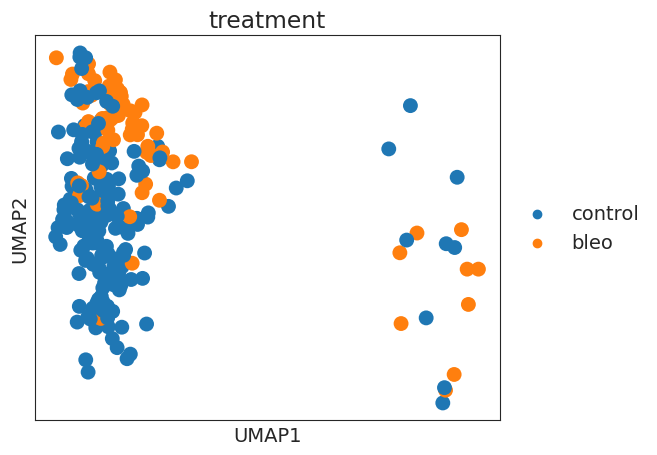

Started Diffxpy Calculation:	14-08-2024 17:48:39
training location model: True
training scale model: True
iter   0: ll=1176376.643978
caught 81 linalg singular matrix errors
iter   1: ll=1093993.002259, converged: 0.00% (loc: 3.36%, scale update: False), in 0.41sec
iter   2: ll=1074127.276596, converged: 0.00% (loc: 3.36%, scale update: False), in 0.42sec
iter   3: ll=1072296.958666, converged: 0.00% (loc: 3.36%, scale update: False), in 0.42sec
iter   4: ll=1072228.587940, converged: 0.00% (loc: 3.36%, scale update: False), in 0.42sec
iter   5: ll=1072226.312851, converged: 0.00% (loc: 3.57%, scale update: False), in 0.42sec
iter   6: ll=634825.938395, converged: 0.00% (loc: 0.00%, scale update: True), in 4.04sec
caught 80 linalg singular matrix errors
iter   7: ll=633379.331053, converged: 0.00% (loc: 1.70%, scale update: False), in 0.48sec
iter   8: ll=633070.719419, converged: 0.00% (loc: 2.92%, scale update: False), in 0.68sec
iter   9: ll=633029.115913, converged: 0.00% (loc: 12.

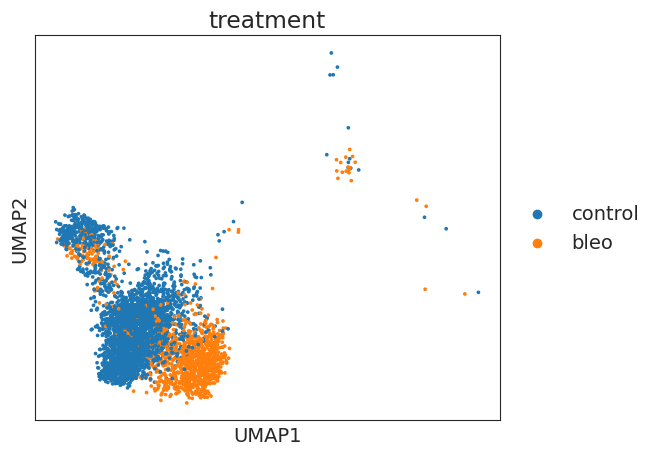

Started Diffxpy Calculation:	14-08-2024 17:49:41
training location model: True
training scale model: True
iter   0: ll=8759528.246414
iter   1: ll=7989121.495947, converged: 0.00% (loc: 0.00%, scale update: False), in 1.76sec
iter   2: ll=7816709.856432, converged: 0.00% (loc: 0.00%, scale update: False), in 1.52sec
iter   3: ll=7807300.131438, converged: 0.00% (loc: 0.00%, scale update: False), in 1.50sec
iter   4: ll=7807255.376437, converged: 0.00% (loc: 0.00%, scale update: False), in 1.57sec
iter   5: ll=7807255.348514, converged: 0.00% (loc: 4.55%, scale update: False), in 1.55sec
iter   6: ll=7637214.782388, converged: 0.00% (loc: 0.00%, scale update: True), in 16.78sec
iter   7: ll=7636638.035265, converged: 0.00% (loc: 0.03%, scale update: False), in 1.50sec
iter   8: ll=7636634.718318, converged: 0.00% (loc: 2.03%, scale update: False), in 1.55sec
iter   9: ll=7636634.701237, converged: 0.00% (loc: 24.58%, scale update: False), in 1.64sec
iter  10: ll=7636634.701111, converge

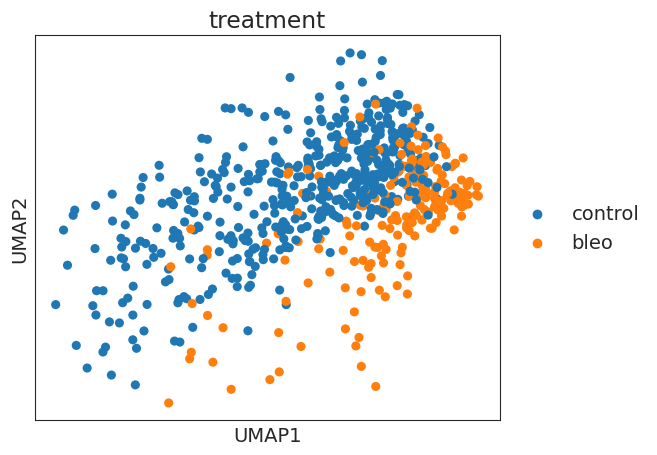

Started Diffxpy Calculation:	14-08-2024 17:51:21
training location model: True
training scale model: True
iter   0: ll=1807474.433107
caught 3 linalg singular matrix errors
iter   1: ll=1632683.859359, converged: 0.00% (loc: 0.11%, scale update: False), in 0.42sec
iter   2: ll=1594164.924028, converged: 0.00% (loc: 0.11%, scale update: False), in 0.42sec
iter   3: ll=1591744.031195, converged: 0.00% (loc: 0.11%, scale update: False), in 0.41sec
iter   4: ll=1591716.194325, converged: 0.00% (loc: 0.11%, scale update: False), in 0.42sec
iter   5: ll=1591716.017589, converged: 0.00% (loc: 1.03%, scale update: False), in 0.42sec
iter   6: ll=1554990.191952, converged: 0.00% (loc: 0.00%, scale update: True), in 5.40sec
caught 3 linalg singular matrix errors
iter   7: ll=1554805.704982, converged: 0.00% (loc: 0.13%, scale update: False), in 0.42sec
iter   8: ll=1554799.932937, converged: 0.00% (loc: 2.08%, scale update: False), in 0.63sec
iter   9: ll=1554799.798837, converged: 0.00% (loc: 1

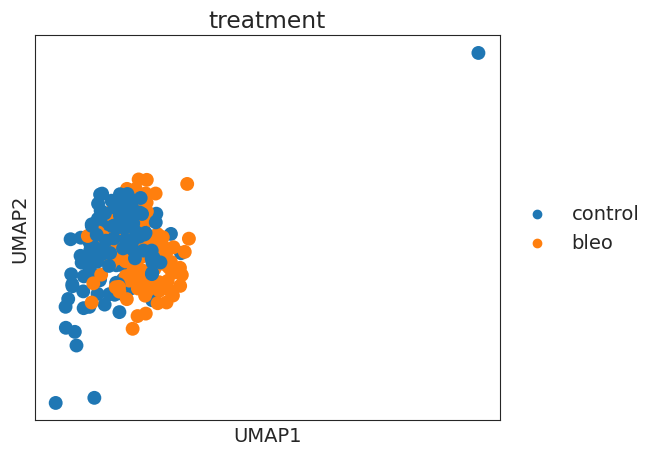

Started Diffxpy Calculation:	14-08-2024 17:52:04
training location model: True
training scale model: True
iter   0: ll=1265152.932057
caught 18 linalg singular matrix errors
iter   1: ll=1153759.984158, converged: 0.00% (loc: 1.18%, scale update: False), in 0.58sec
iter   2: ll=1125186.156770, converged: 0.00% (loc: 1.18%, scale update: False), in 0.60sec
iter   3: ll=1122274.880827, converged: 0.00% (loc: 1.18%, scale update: False), in 0.80sec
iter   4: ll=1122156.276394, converged: 0.00% (loc: 1.18%, scale update: False), in 0.65sec
iter   5: ll=1122152.263261, converged: 0.00% (loc: 1.20%, scale update: False), in 0.62sec
iter   6: ll=855503.752511, converged: 0.00% (loc: 0.00%, scale update: True), in 4.59sec
caught 17 linalg singular matrix errors
iter   7: ll=854670.675749, converged: 0.00% (loc: 0.50%, scale update: False), in 0.64sec
iter   8: ll=854550.422268, converged: 0.00% (loc: 1.13%, scale update: False), in 0.65sec
iter   9: ll=854546.121598, converged: 0.00% (loc: 7.1

iter  87: ll=850565.121264, converged: 99.96% (loc: 99.98%, scale update: False), in 0.10sec
iter  88: ll=850565.121264, converged: 99.96% (loc: 100.00%, scale update: False), in 0.09sec
iter  89: ll=850565.121260, converged: 99.98% (loc: 99.98%, scale update: True), in 0.11sec
iter  90: ll=850565.121257, converged: 99.98% (loc: 99.98%, scale update: False), in 0.09sec
iter  91: ll=850565.121257, converged: 99.98% (loc: 99.98%, scale update: False), in 0.10sec
iter  92: ll=850565.121257, converged: 99.98% (loc: 100.00%, scale update: False), in 0.10sec
iter  93: ll=850565.121254, converged: 99.98% (loc: 99.98%, scale update: True), in 0.09sec
iter  94: ll=850565.121252, converged: 99.98% (loc: 99.98%, scale update: False), in 0.10sec
iter  95: ll=850565.121252, converged: 99.98% (loc: 100.00%, scale update: False), in 0.10sec
iter  96: ll=850565.121251, converged: 99.98% (loc: 99.98%, scale update: True), in 0.10sec
iter  97: ll=850565.121250, converged: 99.98% (loc: 99.98%, scale upda

In [20]:
subset = ["control", "bleo"]
condition = "treatment"
ct_label = "meta_label"
min_cells = 10

time = "d20"
time_subset = adata[adata.obs.time_point.isin([time, "d0"])].copy()
sc.pl.umap(time_subset, color = ["day", "meta_label"], size = 10, wspace = 0.25)

for ct in cell_types:
    
    print("%s - %s" %(ct, time))
    dge(time_subset, ct = ct, ct_label = ct_label, condition = condition, ref = "control", pct_thresh = 0.05,
              subset = subset, min_cells = min_cells, do_return = False, suffix = "_old")

## d30

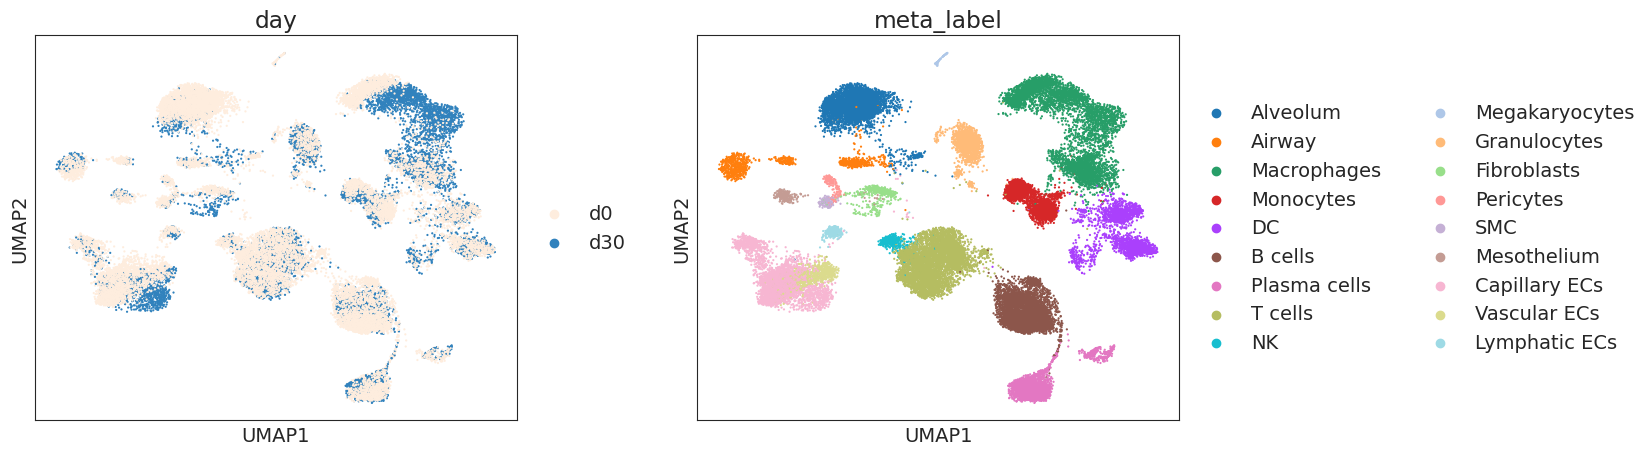

Alveolum - d30
(4323, 4399)


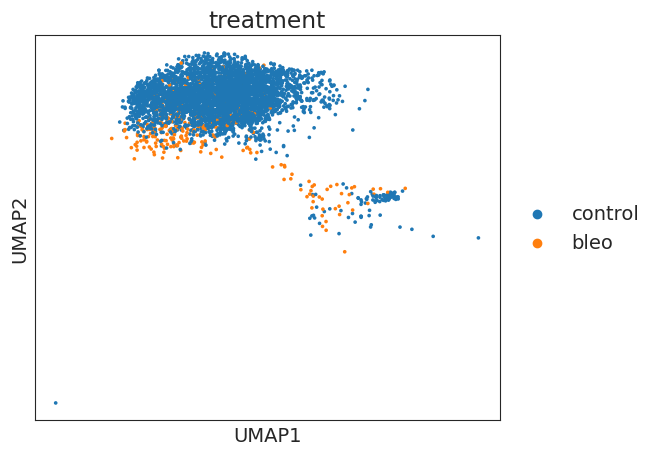

Started Diffxpy Calculation:	14-08-2024 17:53:10
training location model: True
training scale model: True
iter   0: ll=9621140.261825
iter   1: ll=8534517.786078, converged: 0.00% (loc: 0.20%, scale update: False), in 2.36sec
iter   2: ll=8296893.359038, converged: 0.00% (loc: 0.20%, scale update: False), in 2.34sec
iter   3: ll=8280438.690375, converged: 0.00% (loc: 0.20%, scale update: False), in 1.72sec
iter   4: ll=8280001.256283, converged: 0.00% (loc: 0.20%, scale update: False), in 2.07sec
iter   5: ll=8279981.492649, converged: 0.00% (loc: 0.64%, scale update: False), in 1.78sec
iter   6: ll=7953185.213975, converged: 0.00% (loc: 0.00%, scale update: True), in 21.08sec
iter   7: ll=7952314.976611, converged: 0.00% (loc: 0.02%, scale update: False), in 1.81sec
iter   8: ll=7952233.523913, converged: 0.00% (loc: 1.00%, scale update: False), in 1.89sec
iter   9: ll=7952228.908762, converged: 0.00% (loc: 7.21%, scale update: False), in 2.20sec
iter  10: ll=7952228.764582, converged

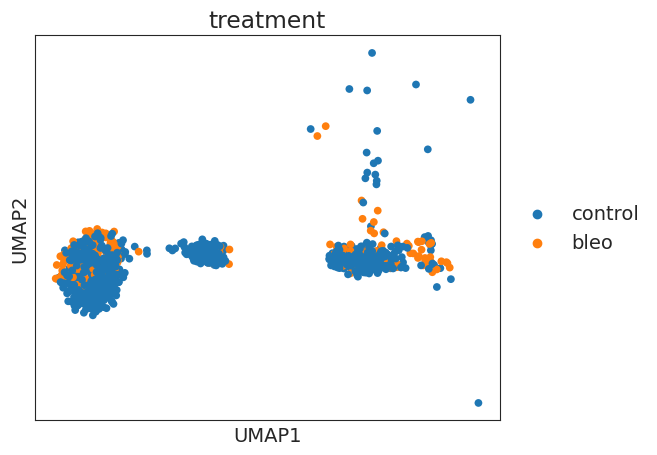

Started Diffxpy Calculation:	14-08-2024 17:55:21
training location model: True
training scale model: True
iter   0: ll=48234108.522947
iter   1: ll=47210806.216388, converged: 0.00% (loc: 20.55%, scale update: False), in 0.66sec
iter   2: ll=46786755.724415, converged: 0.00% (loc: 20.55%, scale update: False), in 0.64sec
iter   3: ll=46659715.242222, converged: 0.00% (loc: 20.55%, scale update: False), in 0.64sec
iter   4: ll=46632430.125414, converged: 0.00% (loc: 20.55%, scale update: False), in 0.79sec
iter   5: ll=46628376.669261, converged: 0.00% (loc: 20.55%, scale update: False), in 0.62sec
iter   6: ll=3922281.892190, converged: 0.00% (loc: 0.00%, scale update: True), in 9.40sec
iter   7: ll=3857026.815437, converged: 0.00% (loc: 0.09%, scale update: False), in 0.62sec
iter   8: ll=3847120.371024, converged: 0.00% (loc: 0.47%, scale update: False), in 0.62sec
iter   9: ll=3845728.210751, converged: 0.00% (loc: 1.03%, scale update: False), in 0.80sec
iter  10: ll=3845644.529976,

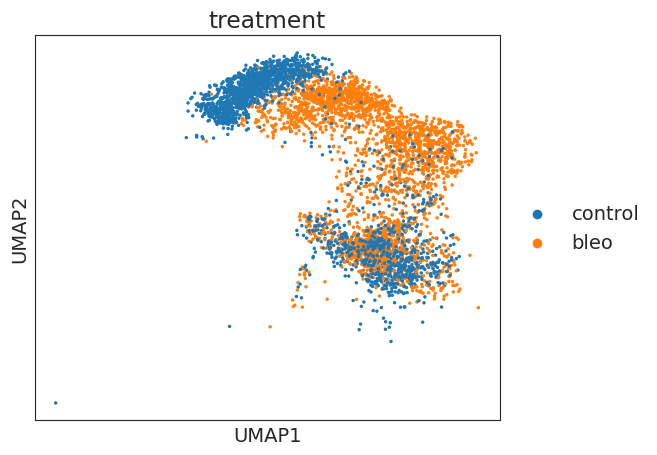

Started Diffxpy Calculation:	14-08-2024 17:57:00
training location model: True
training scale model: True
iter   0: ll=15628328.049079
caught 1 linalg singular matrix errors
iter   1: ll=13848186.168068, converged: 0.00% (loc: 0.06%, scale update: False), in 3.82sec
iter   2: ll=13353001.455455, converged: 0.00% (loc: 0.06%, scale update: False), in 3.73sec
iter   3: ll=13290624.684814, converged: 0.00% (loc: 0.06%, scale update: False), in 3.45sec
iter   4: ll=13286849.357558, converged: 0.00% (loc: 0.06%, scale update: False), in 2.85sec
iter   5: ll=13286689.445771, converged: 0.00% (loc: 0.08%, scale update: False), in 2.06sec
iter   6: ll=13118154.504602, converged: 0.00% (loc: 0.00%, scale update: True), in 24.73sec
caught 1 linalg singular matrix errors
iter   7: ll=13116943.398038, converged: 0.00% (loc: 0.04%, scale update: False), in 2.20sec
iter   8: ll=13116884.856707, converged: 0.00% (loc: 0.87%, scale update: False), in 2.21sec
iter   9: ll=13116880.405175, converged: 0.

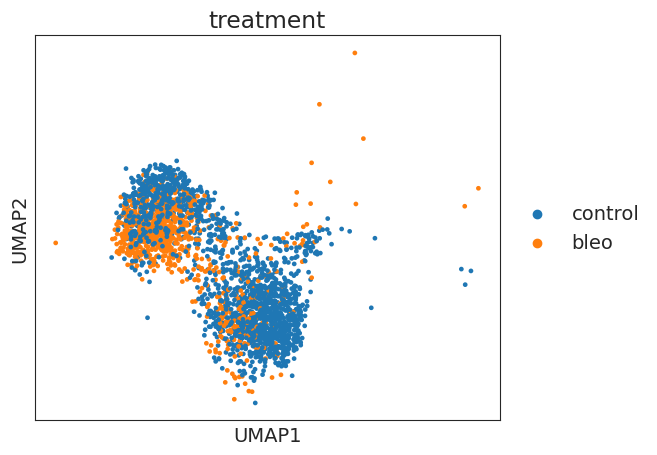

Started Diffxpy Calculation:	14-08-2024 18:00:12
training location model: True
training scale model: True
iter   0: ll=5834069.843905
iter   1: ll=5256477.618027, converged: 0.00% (loc: 0.00%, scale update: False), in 1.94sec
iter   2: ll=5137118.564775, converged: 0.00% (loc: 0.00%, scale update: False), in 1.20sec
iter   3: ll=5131357.660289, converged: 0.00% (loc: 0.00%, scale update: False), in 1.25sec
iter   4: ll=5131332.443799, converged: 0.00% (loc: 0.00%, scale update: False), in 1.38sec
iter   5: ll=5131332.414501, converged: 0.00% (loc: 7.99%, scale update: False), in 1.25sec
iter   6: ll=5055898.921954, converged: 0.00% (loc: 0.00%, scale update: True), in 12.86sec
iter   7: ll=5055621.551044, converged: 0.00% (loc: 0.00%, scale update: False), in 1.68sec
iter   8: ll=5055619.796862, converged: 0.00% (loc: 1.85%, scale update: False), in 1.21sec
iter   9: ll=5055619.787555, converged: 0.00% (loc: 35.12%, scale update: False), in 1.20sec
iter  10: ll=5055619.787500, converge

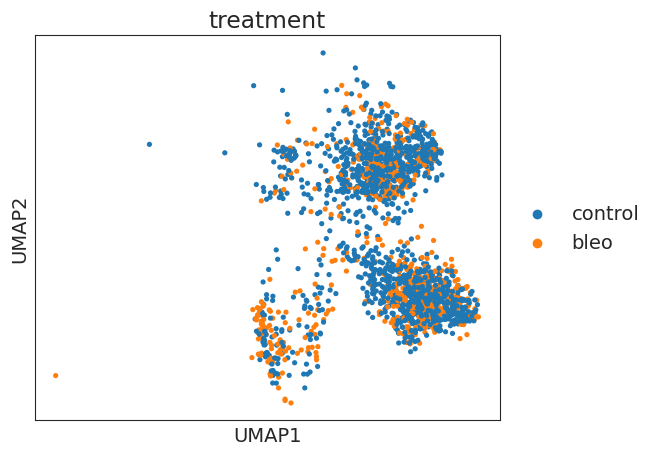

Started Diffxpy Calculation:	14-08-2024 18:01:26
training location model: True
training scale model: True
iter   0: ll=5736327.283680
iter   1: ll=5071599.422934, converged: 0.00% (loc: 0.02%, scale update: False), in 2.07sec
iter   2: ll=4926333.006056, converged: 0.00% (loc: 0.02%, scale update: False), in 1.99sec
iter   3: ll=4916872.812612, converged: 0.00% (loc: 0.02%, scale update: False), in 2.16sec
iter   4: ll=4916746.253678, converged: 0.00% (loc: 0.02%, scale update: False), in 2.12sec
iter   5: ll=4916745.386708, converged: 0.00% (loc: 0.47%, scale update: False), in 2.09sec
iter   6: ll=4873963.607763, converged: 0.00% (loc: 0.00%, scale update: True), in 19.19sec
iter   7: ll=4873718.519800, converged: 0.00% (loc: 0.14%, scale update: False), in 2.25sec
iter   8: ll=4873717.136608, converged: 0.00% (loc: 4.26%, scale update: False), in 2.08sec
iter   9: ll=4873717.122983, converged: 0.00% (loc: 36.09%, scale update: False), in 1.56sec
iter  10: ll=4873717.122827, converge

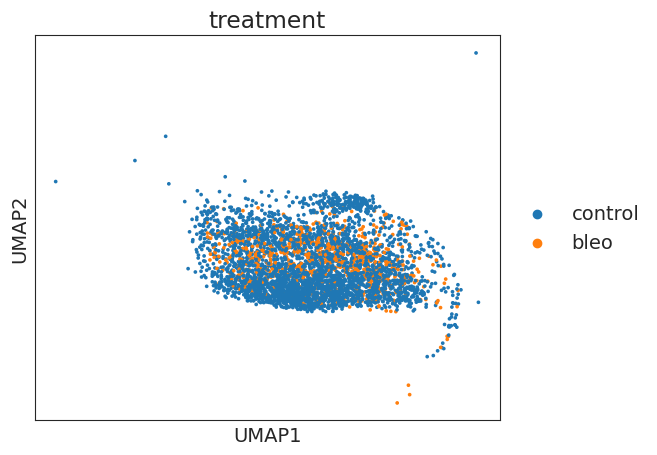

Started Diffxpy Calculation:	14-08-2024 18:02:49
training location model: True
training scale model: True
iter   0: ll=7173295.729271
iter   1: ll=6516936.227821, converged: 0.00% (loc: 0.00%, scale update: False), in 1.31sec
iter   2: ll=6362139.970556, converged: 0.00% (loc: 0.00%, scale update: False), in 1.32sec
iter   3: ll=6352964.730113, converged: 0.00% (loc: 0.00%, scale update: False), in 1.40sec
iter   4: ll=6352910.470362, converged: 0.00% (loc: 0.00%, scale update: False), in 1.32sec
iter   5: ll=6352910.413134, converged: 0.00% (loc: 11.24%, scale update: False), in 1.54sec
iter   6: ll=6240362.577503, converged: 0.00% (loc: 0.00%, scale update: True), in 13.30sec
iter   7: ll=6240059.999467, converged: 0.00% (loc: 0.03%, scale update: False), in 1.55sec
iter   8: ll=6240058.046666, converged: 0.00% (loc: 3.77%, scale update: False), in 1.29sec
iter   9: ll=6240058.031320, converged: 0.00% (loc: 39.66%, scale update: False), in 1.23sec
iter  10: ll=6240058.030947, converg

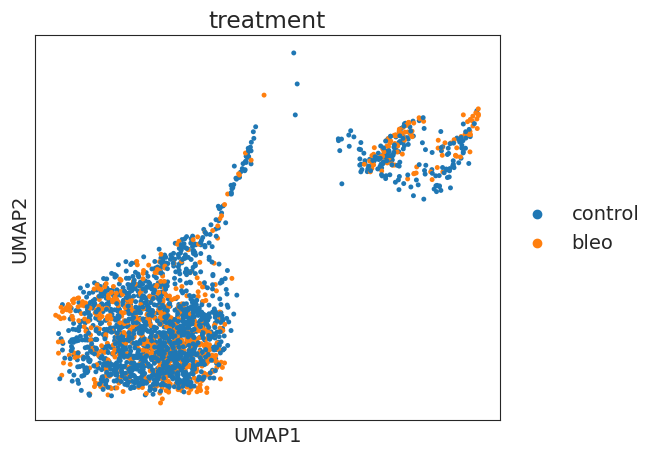

Started Diffxpy Calculation:	14-08-2024 18:04:03
training location model: True
training scale model: True
iter   0: ll=2763157.241917
iter   1: ll=2419816.445225, converged: 0.00% (loc: 0.17%, scale update: False), in 0.74sec
iter   2: ll=2335879.103174, converged: 0.00% (loc: 0.17%, scale update: False), in 0.71sec
iter   3: ll=2328159.689652, converged: 0.00% (loc: 0.17%, scale update: False), in 0.69sec
iter   4: ll=2327922.592801, converged: 0.00% (loc: 0.17%, scale update: False), in 0.69sec
iter   5: ll=2327917.898210, converged: 0.00% (loc: 1.09%, scale update: False), in 0.64sec
iter   6: ll=2154855.913215, converged: 0.00% (loc: 0.00%, scale update: True), in 5.24sec
iter   7: ll=2154358.910636, converged: 0.00% (loc: 0.00%, scale update: False), in 0.74sec
iter   8: ll=2154325.717664, converged: 0.00% (loc: 1.95%, scale update: False), in 0.77sec
iter   9: ll=2154323.562812, converged: 0.00% (loc: 12.39%, scale update: False), in 0.69sec
iter  10: ll=2154323.531751, converged

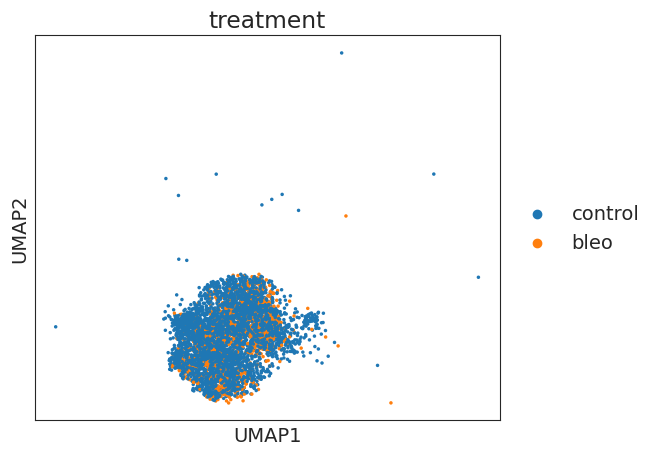

Started Diffxpy Calculation:	14-08-2024 18:04:41
training location model: True
training scale model: True
iter   0: ll=7833666.750550
iter   1: ll=7105326.493234, converged: 0.00% (loc: 0.00%, scale update: False), in 1.58sec
iter   2: ll=6949432.635301, converged: 0.00% (loc: 0.00%, scale update: False), in 1.38sec
iter   3: ll=6942032.074918, converged: 0.00% (loc: 0.00%, scale update: False), in 1.24sec
iter   4: ll=6942011.120234, converged: 0.00% (loc: 0.00%, scale update: False), in 1.35sec
iter   5: ll=6942011.116919, converged: 0.00% (loc: 41.83%, scale update: False), in 1.30sec
iter   6: ll=6831973.806182, converged: 0.00% (loc: 0.00%, scale update: True), in 14.77sec
iter   7: ll=6831879.722698, converged: 0.00% (loc: 0.00%, scale update: False), in 1.41sec
iter   8: ll=6831879.527296, converged: 0.00% (loc: 15.44%, scale update: False), in 1.30sec
iter   9: ll=6831879.526751, converged: 0.00% (loc: 93.24%, scale update: False), in 1.10sec
iter  10: ll=6831879.526748, conver

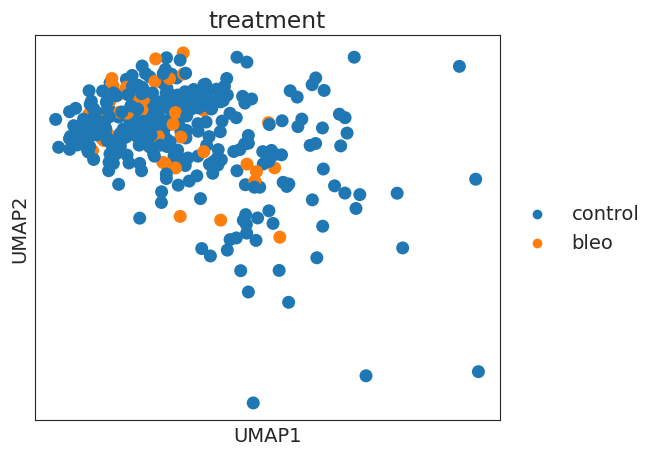

Started Diffxpy Calculation:	14-08-2024 18:05:53
training location model: True
training scale model: True
iter   0: ll=539917.066152
caught 86 linalg singular matrix errors
iter   1: ll=490308.250006, converged: 0.00% (loc: 2.72%, scale update: False), in 0.34sec
iter   2: ll=479427.285580, converged: 0.00% (loc: 2.72%, scale update: False), in 0.37sec
iter   3: ll=478868.568514, converged: 0.00% (loc: 2.72%, scale update: False), in 0.42sec
iter   4: ll=478866.071267, converged: 0.00% (loc: 2.72%, scale update: False), in 0.46sec
iter   5: ll=478866.065468, converged: 0.00% (loc: 25.68%, scale update: False), in 0.44sec
iter   6: ll=468130.182921, converged: 0.00% (loc: 0.00%, scale update: True), in 3.13sec
caught 86 linalg singular matrix errors
iter   7: ll=468097.712048, converged: 0.00% (loc: 3.26%, scale update: False), in 0.44sec
iter   8: ll=468097.421579, converged: 0.00% (loc: 9.49%, scale update: False), in 0.47sec
iter   9: ll=468097.420200, converged: 0.00% (loc: 66.19%, 

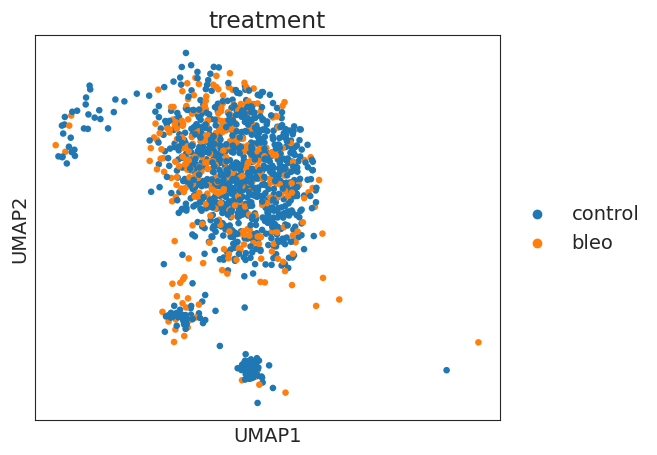

Started Diffxpy Calculation:	14-08-2024 18:06:19
training location model: True
training scale model: True
iter   0: ll=1338934.980229
iter   1: ll=1194638.411504, converged: 0.00% (loc: 0.00%, scale update: False), in 0.56sec
iter   2: ll=1155551.103841, converged: 0.00% (loc: 0.00%, scale update: False), in 0.53sec
iter   3: ll=1152752.911113, converged: 0.00% (loc: 0.00%, scale update: False), in 0.54sec
iter   4: ll=1152737.275637, converged: 0.00% (loc: 0.00%, scale update: False), in 0.58sec
iter   5: ll=1152737.274147, converged: 0.00% (loc: 17.67%, scale update: False), in 0.60sec
iter   6: ll=1127684.558529, converged: 0.00% (loc: 0.00%, scale update: True), in 3.84sec
iter   7: ll=1127673.781185, converged: 0.00% (loc: 0.00%, scale update: False), in 0.60sec
iter   8: ll=1127673.772897, converged: 0.00% (loc: 20.80%, scale update: False), in 0.60sec
iter   9: ll=1127673.772879, converged: 0.00% (loc: 98.23%, scale update: False), in 0.51sec
iter  10: ll=1127673.772879, converg

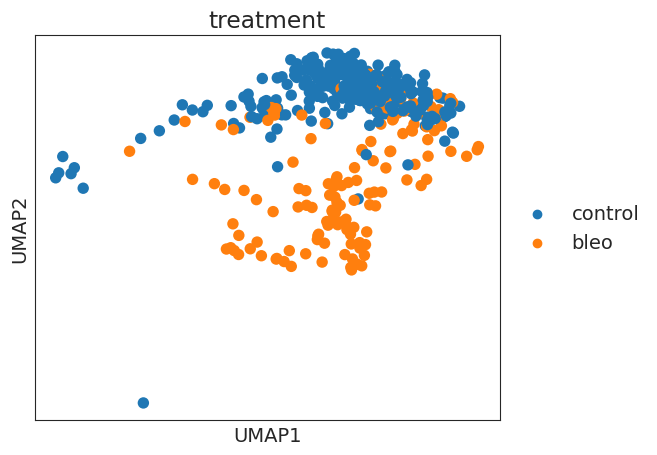

Started Diffxpy Calculation:	14-08-2024 18:06:40
training location model: True
training scale model: True
iter   0: ll=2836945.972484
caught 41 linalg singular matrix errors
iter   1: ll=2683914.365463, converged: 0.00% (loc: 3.79%, scale update: False), in 0.87sec
iter   2: ll=2638889.785233, converged: 0.00% (loc: 3.79%, scale update: False), in 0.74sec
iter   3: ll=2631257.366912, converged: 0.00% (loc: 3.79%, scale update: False), in 0.70sec
iter   4: ll=2630186.269864, converged: 0.00% (loc: 3.79%, scale update: False), in 0.73sec
iter   5: ll=2630039.803394, converged: 0.00% (loc: 3.83%, scale update: False), in 0.74sec
iter   6: ll=1312073.356116, converged: 0.00% (loc: 0.00%, scale update: True), in 5.76sec
caught 36 linalg singular matrix errors
iter   7: ll=1309309.762251, converged: 0.00% (loc: 0.81%, scale update: False), in 0.71sec
iter   8: ll=1308667.257416, converged: 0.00% (loc: 1.32%, scale update: False), in 0.72sec
iter   9: ll=1308561.588580, converged: 0.00% (loc:

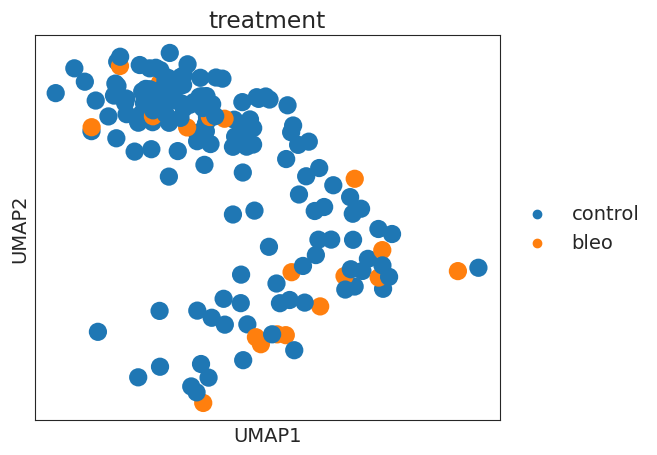

Started Diffxpy Calculation:	14-08-2024 18:08:27
training location model: True
training scale model: True
iter   0: ll=423706.999676
caught 619 linalg singular matrix errors
iter   1: ll=389185.413567, converged: 0.00% (loc: 12.61%, scale update: False), in 0.43sec
iter   2: ll=382164.150323, converged: 0.00% (loc: 12.61%, scale update: False), in 0.49sec
iter   3: ll=381806.561718, converged: 0.00% (loc: 12.61%, scale update: False), in 0.49sec
iter   4: ll=381803.796994, converged: 0.00% (loc: 12.65%, scale update: False), in 0.49sec
iter   5: ll=381803.779397, converged: 0.00% (loc: 24.85%, scale update: False), in 0.47sec
iter   6: ll=344487.054653, converged: 0.00% (loc: 0.00%, scale update: True), in 4.35sec
caught 619 linalg singular matrix errors
iter   7: ll=344395.519679, converged: 0.00% (loc: 14.63%, scale update: False), in 0.43sec
iter   8: ll=344392.357541, converged: 0.00% (loc: 18.17%, scale update: False), in 0.44sec
iter   9: ll=344392.317089, converged: 0.00% (loc: 

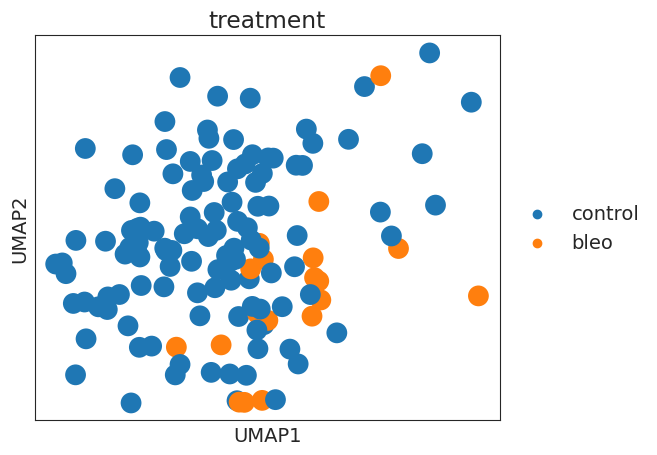

Started Diffxpy Calculation:	14-08-2024 18:09:06
training location model: True
training scale model: True
iter   0: ll=683848.736104
caught 774 linalg singular matrix errors
iter   1: ll=645144.075233, converged: 0.00% (loc: 18.33%, scale update: False), in 0.89sec
iter   2: ll=636840.754187, converged: 0.00% (loc: 18.33%, scale update: False), in 0.64sec
iter   3: ll=636295.982389, converged: 0.00% (loc: 18.33%, scale update: False), in 0.74sec
iter   4: ll=636287.384465, converged: 0.00% (loc: 18.33%, scale update: False), in 0.94sec
iter   5: ll=636287.294657, converged: 0.00% (loc: 21.02%, scale update: False), in 0.65sec
iter   6: ll=314352.829125, converged: 0.00% (loc: 0.00%, scale update: True), in 5.14sec
caught 774 linalg singular matrix errors
iter   7: ll=314046.452569, converged: 0.00% (loc: 17.58%, scale update: False), in 0.49sec
iter   8: ll=314017.617543, converged: 0.00% (loc: 20.54%, scale update: False), in 0.59sec
iter   9: ll=314016.715306, converged: 0.00% (loc: 

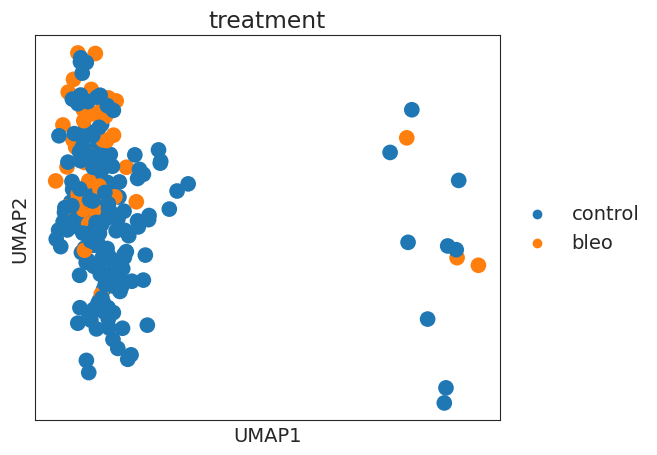

Started Diffxpy Calculation:	14-08-2024 18:09:53
training location model: True
training scale model: True
iter   0: ll=2615660.411887
caught 82 linalg singular matrix errors
iter   1: ll=2523348.153093, converged: 0.00% (loc: 9.29%, scale update: False), in 1.00sec
iter   2: ll=2498767.175537, converged: 0.00% (loc: 9.29%, scale update: False), in 1.74sec
iter   3: ll=2495768.391849, converged: 0.00% (loc: 9.29%, scale update: False), in 1.44sec
iter   4: ll=2495573.821698, converged: 0.00% (loc: 9.29%, scale update: False), in 0.94sec
iter   5: ll=2495562.562745, converged: 0.00% (loc: 9.35%, scale update: False), in 1.15sec
iter   6: ll=659677.001828, converged: 0.00% (loc: 0.00%, scale update: True), in 5.41sec
caught 82 linalg singular matrix errors
iter   7: ll=653105.123006, converged: 0.00% (loc: 2.30%, scale update: False), in 0.50sec
iter   8: ll=651714.137333, converged: 0.00% (loc: 3.10%, scale update: False), in 0.53sec
iter   9: ll=651540.842119, converged: 0.00% (loc: 7.4

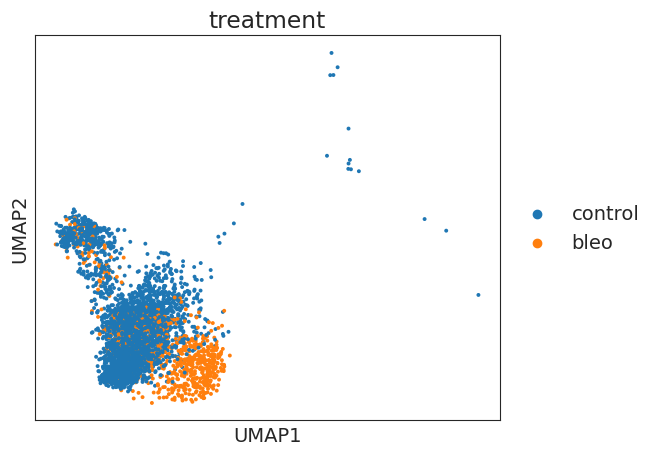

Started Diffxpy Calculation:	14-08-2024 18:11:07
training location model: True
training scale model: True
iter   0: ll=8658083.444310
iter   1: ll=7904100.851616, converged: 0.00% (loc: 0.00%, scale update: False), in 1.66sec
iter   2: ll=7734285.926889, converged: 0.00% (loc: 0.00%, scale update: False), in 2.28sec
iter   3: ll=7724654.805022, converged: 0.00% (loc: 0.00%, scale update: False), in 2.35sec
iter   4: ll=7724596.057873, converged: 0.00% (loc: 0.00%, scale update: False), in 1.59sec
iter   5: ll=7724595.949150, converged: 0.00% (loc: 1.61%, scale update: False), in 2.48sec
iter   6: ll=7580147.942775, converged: 0.00% (loc: 0.00%, scale update: True), in 26.89sec
iter   7: ll=7579357.259409, converged: 0.00% (loc: 0.02%, scale update: False), in 2.72sec
iter   8: ll=7579347.631151, converged: 0.00% (loc: 1.41%, scale update: False), in 3.39sec
iter   9: ll=7579347.506343, converged: 0.00% (loc: 10.22%, scale update: False), in 2.58sec
iter  10: ll=7579347.504358, converge

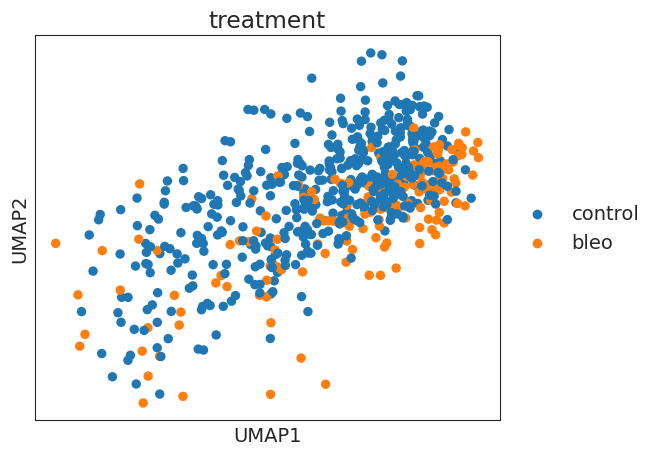

Started Diffxpy Calculation:	14-08-2024 18:13:16
training location model: True
training scale model: True
iter   0: ll=1847322.863137
caught 2 linalg singular matrix errors
iter   1: ll=1666658.811884, converged: 0.00% (loc: 0.20%, scale update: False), in 1.00sec
iter   2: ll=1625698.851655, converged: 0.00% (loc: 0.20%, scale update: False), in 0.46sec
iter   3: ll=1622826.031509, converged: 0.00% (loc: 0.20%, scale update: False), in 0.47sec
iter   4: ll=1622775.838151, converged: 0.00% (loc: 0.20%, scale update: False), in 0.57sec
iter   5: ll=1622775.094861, converged: 0.00% (loc: 0.83%, scale update: False), in 0.56sec
iter   6: ll=1559161.496559, converged: 0.00% (loc: 0.00%, scale update: True), in 9.27sec
caught 2 linalg singular matrix errors
iter   7: ll=1558789.579586, converged: 0.00% (loc: 0.14%, scale update: False), in 1.21sec
iter   8: ll=1558739.467705, converged: 0.00% (loc: 2.24%, scale update: False), in 1.38sec
iter   9: ll=1558733.726839, converged: 0.00% (loc: 1

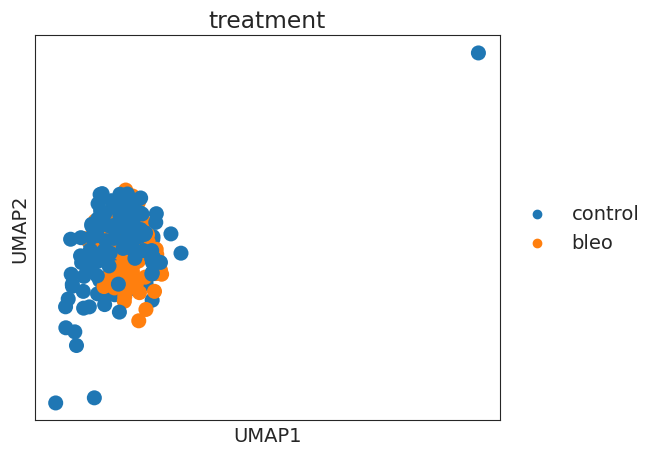

Started Diffxpy Calculation:	14-08-2024 18:14:16
training location model: True
training scale model: True
iter   0: ll=1603006.717598
caught 37 linalg singular matrix errors
iter   1: ll=1496283.457411, converged: 0.00% (loc: 3.09%, scale update: False), in 0.51sec
iter   2: ll=1468288.202166, converged: 0.00% (loc: 3.09%, scale update: False), in 1.21sec
iter   3: ll=1465112.809565, converged: 0.00% (loc: 3.09%, scale update: False), in 1.21sec
iter   4: ll=1464945.429722, converged: 0.00% (loc: 3.09%, scale update: False), in 1.11sec
iter   5: ll=1464938.232651, converged: 0.00% (loc: 3.12%, scale update: False), in 1.24sec
iter   6: ll=764725.980132, converged: 0.00% (loc: 0.00%, scale update: True), in 6.73sec
caught 37 linalg singular matrix errors
iter   7: ll=762919.611347, converged: 0.00% (loc: 1.06%, scale update: False), in 0.73sec
iter   8: ll=762618.844885, converged: 0.00% (loc: 1.69%, scale update: False), in 0.98sec
iter   9: ll=762573.838263, converged: 0.00% (loc: 7.2

iter  86: ll=757355.999040, converged: 99.97% (loc: 99.97%, scale update: True), in 1.03sec
iter  87: ll=757355.999038, converged: 99.97% (loc: 99.97%, scale update: False), in 0.12sec
iter  88: ll=757355.999038, converged: 99.97% (loc: 99.98%, scale update: False), in 0.12sec
iter  89: ll=757355.999038, converged: 99.97% (loc: 100.00%, scale update: False), in 0.11sec
iter  90: ll=757355.999037, converged: 99.97% (loc: 99.97%, scale update: True), in 0.09sec
iter  91: ll=757355.999037, converged: 99.97% (loc: 99.98%, scale update: False), in 0.10sec
iter  92: ll=757355.999037, converged: 99.97% (loc: 100.00%, scale update: False), in 0.09sec
iter  93: ll=757355.999036, converged: 99.98% (loc: 99.98%, scale update: True), in 0.10sec
iter  94: ll=757355.999036, converged: 99.98% (loc: 99.98%, scale update: False), in 0.09sec
iter  95: ll=757355.999036, converged: 99.98% (loc: 100.00%, scale update: False), in 0.09sec
iter  96: ll=757355.999036, converged: 99.98% (loc: 99.98%, scale upda

In [21]:
subset = ["control", "bleo"]
condition = "treatment"
ct_label = "meta_label"
min_cells = 10

time = "d30"
time_subset = adata[adata.obs.time_point.isin([time, "d0"])].copy()
sc.pl.umap(time_subset, color = ["day", "meta_label"], size = 10, wspace = 0.25)

for ct in cell_types:
    
    print("%s - %s" %(ct, time))
    dge(time_subset, ct = ct, ct_label = ct_label, condition = condition, ref = "control", pct_thresh = 0.05,
              subset = subset, min_cells = min_cells, do_return = False, suffix = "_old")

## d37

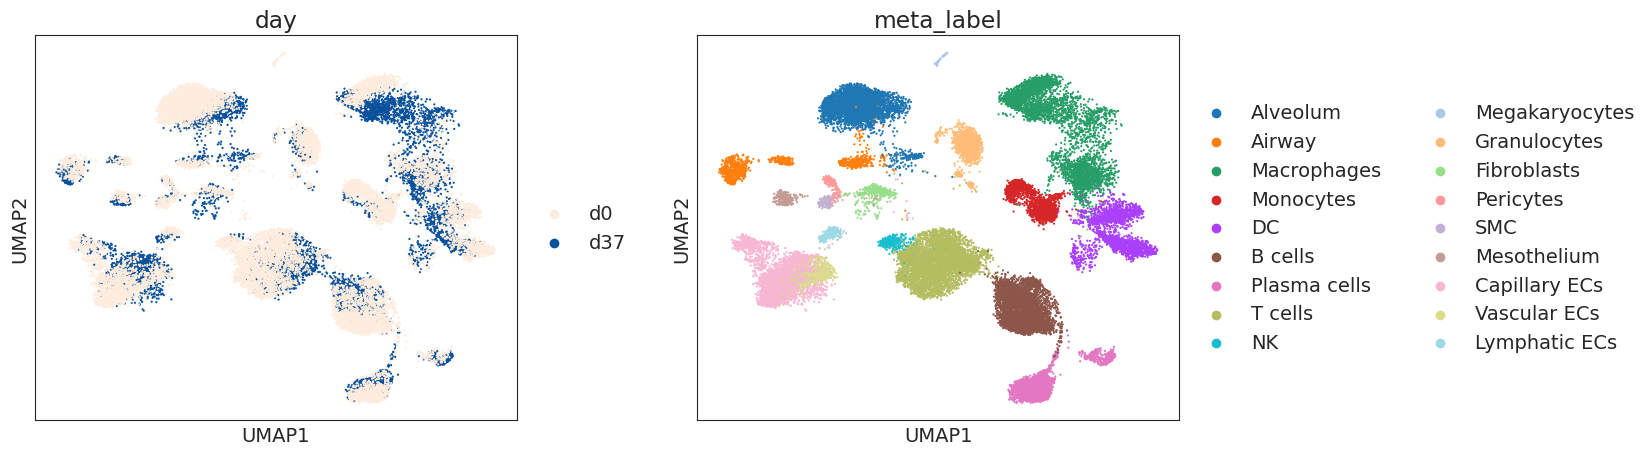

Alveolum - d37
(4579, 3924)


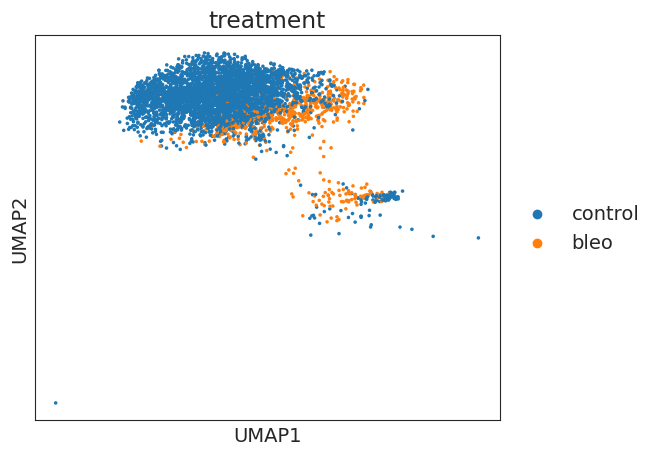

Started Diffxpy Calculation:	14-08-2024 18:15:30
training location model: True
training scale model: True
iter   0: ll=9713225.904645
iter   1: ll=8576080.066906, converged: 0.00% (loc: 0.10%, scale update: False), in 1.81sec
iter   2: ll=8321836.256737, converged: 0.00% (loc: 0.10%, scale update: False), in 1.83sec
iter   3: ll=8303100.031197, converged: 0.00% (loc: 0.10%, scale update: False), in 1.67sec
iter   4: ll=8302579.112940, converged: 0.00% (loc: 0.10%, scale update: False), in 1.72sec
iter   5: ll=8302561.018709, converged: 0.00% (loc: 0.33%, scale update: False), in 1.70sec
iter   6: ll=8156276.245365, converged: 0.00% (loc: 0.00%, scale update: True), in 23.92sec
iter   7: ll=8155617.899867, converged: 0.00% (loc: 0.03%, scale update: False), in 2.77sec
iter   8: ll=8155584.422662, converged: 0.00% (loc: 1.25%, scale update: False), in 2.05sec
iter   9: ll=8155582.384742, converged: 0.00% (loc: 10.04%, scale update: False), in 2.72sec
iter  10: ll=8155582.319757, converge

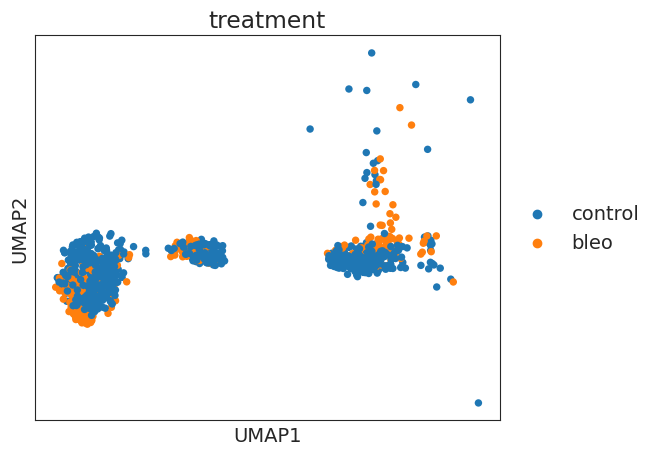

Started Diffxpy Calculation:	14-08-2024 18:17:54
training location model: True
training scale model: True
iter   0: ll=56476958.339220
iter   1: ll=55389457.326182, converged: 0.00% (loc: 22.05%, scale update: False), in 3.16sec
iter   2: ll=54948278.383057, converged: 0.00% (loc: 22.05%, scale update: False), in 1.47sec
iter   3: ll=54820740.661589, converged: 0.00% (loc: 22.05%, scale update: False), in 0.62sec
iter   4: ll=54794444.802788, converged: 0.00% (loc: 22.05%, scale update: False), in 1.13sec
iter   5: ll=54790673.601220, converged: 0.00% (loc: 22.05%, scale update: False), in 0.80sec
iter   6: ll=4158887.511849, converged: 0.00% (loc: 0.00%, scale update: True), in 12.49sec
iter   7: ll=4084267.809316, converged: 0.00% (loc: 0.06%, scale update: False), in 2.38sec
iter   8: ll=4072161.061159, converged: 0.00% (loc: 0.40%, scale update: False), in 1.70sec
iter   9: ll=4070502.635459, converged: 0.00% (loc: 1.21%, scale update: False), in 1.98sec
iter  10: ll=4070402.794803

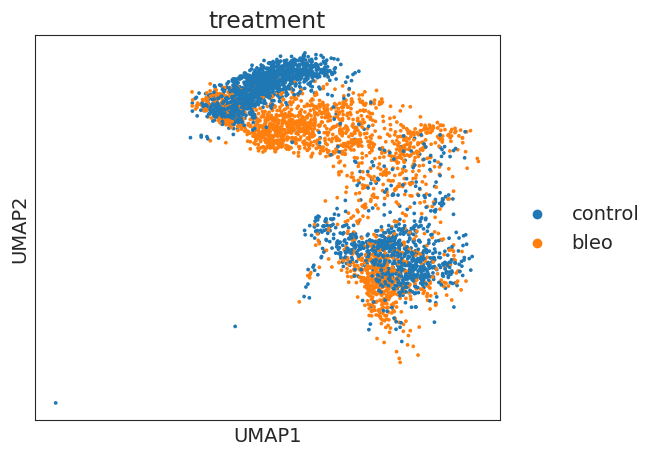

Started Diffxpy Calculation:	14-08-2024 18:20:01
training location model: True
training scale model: True
iter   0: ll=10484719.502829
caught 1 linalg singular matrix errors
iter   1: ll=9398028.458665, converged: 0.00% (loc: 0.02%, scale update: False), in 1.75sec
iter   2: ll=9153070.014263, converged: 0.00% (loc: 0.02%, scale update: False), in 2.19sec
iter   3: ll=9136060.466548, converged: 0.00% (loc: 0.02%, scale update: False), in 2.30sec
iter   4: ll=9135790.579412, converged: 0.00% (loc: 0.02%, scale update: False), in 2.12sec
iter   5: ll=9135788.011438, converged: 0.00% (loc: 0.56%, scale update: False), in 1.71sec
iter   6: ll=9110425.491887, converged: 0.00% (loc: 0.00%, scale update: True), in 23.14sec
caught 1 linalg singular matrix errors
iter   7: ll=9110055.994074, converged: 0.00% (loc: 0.12%, scale update: False), in 2.02sec
iter   8: ll=9110049.564164, converged: 0.00% (loc: 3.42%, scale update: False), in 1.67sec
iter   9: ll=9110049.438487, converged: 0.00% (loc:

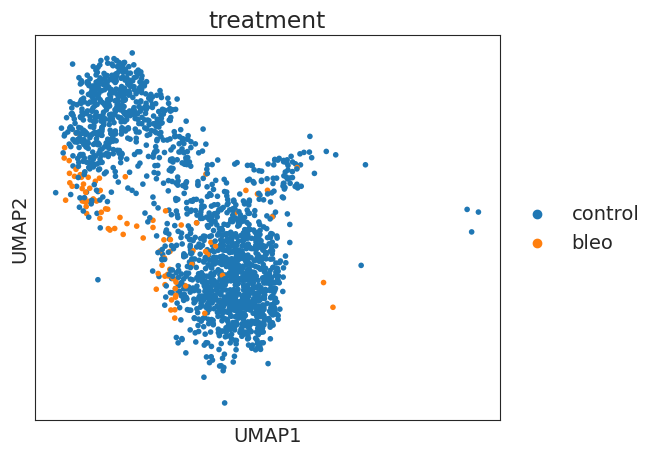

Started Diffxpy Calculation:	14-08-2024 18:22:21
training location model: True
training scale model: True
iter   0: ll=4051238.612172
caught 24 linalg singular matrix errors
iter   1: ll=3641111.982378, converged: 0.00% (loc: 0.62%, scale update: False), in 1.81sec
iter   2: ll=3559524.955502, converged: 0.00% (loc: 0.62%, scale update: False), in 1.73sec
iter   3: ll=3555936.256566, converged: 0.00% (loc: 0.62%, scale update: False), in 1.74sec
iter   4: ll=3555924.735353, converged: 0.00% (loc: 0.62%, scale update: False), in 2.05sec
iter   5: ll=3555924.722487, converged: 0.00% (loc: 22.42%, scale update: False), in 1.72sec
iter   6: ll=3506334.609359, converged: 0.00% (loc: 0.00%, scale update: True), in 15.87sec
caught 24 linalg singular matrix errors
iter   7: ll=3506240.871228, converged: 0.00% (loc: 0.67%, scale update: False), in 1.69sec
iter   8: ll=3506239.722156, converged: 0.00% (loc: 5.44%, scale update: False), in 1.76sec
iter   9: ll=3506239.711097, converged: 0.00% (lo

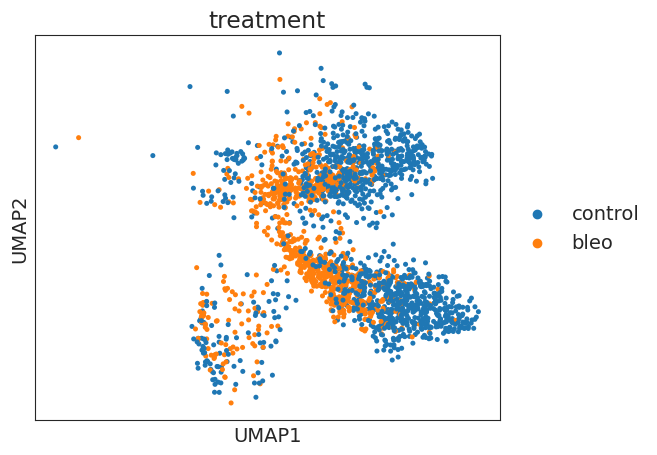

Started Diffxpy Calculation:	14-08-2024 18:23:44
training location model: True
training scale model: True
iter   0: ll=6068588.062832
iter   1: ll=5370781.823052, converged: 0.00% (loc: 0.02%, scale update: False), in 1.47sec
iter   2: ll=5218143.742313, converged: 0.00% (loc: 0.02%, scale update: False), in 1.48sec
iter   3: ll=5208072.105316, converged: 0.00% (loc: 0.02%, scale update: False), in 1.38sec
iter   4: ll=5207926.816669, converged: 0.00% (loc: 0.02%, scale update: False), in 1.45sec
iter   5: ll=5207925.609995, converged: 0.00% (loc: 0.56%, scale update: False), in 1.24sec
iter   6: ll=5164609.508737, converged: 0.00% (loc: 0.00%, scale update: True), in 14.12sec
iter   7: ll=5164480.705029, converged: 0.00% (loc: 0.16%, scale update: False), in 1.61sec
iter   8: ll=5164479.517072, converged: 0.00% (loc: 4.20%, scale update: False), in 1.44sec
iter   9: ll=5164479.502636, converged: 0.00% (loc: 37.23%, scale update: False), in 1.43sec
iter  10: ll=5164479.502418, converge

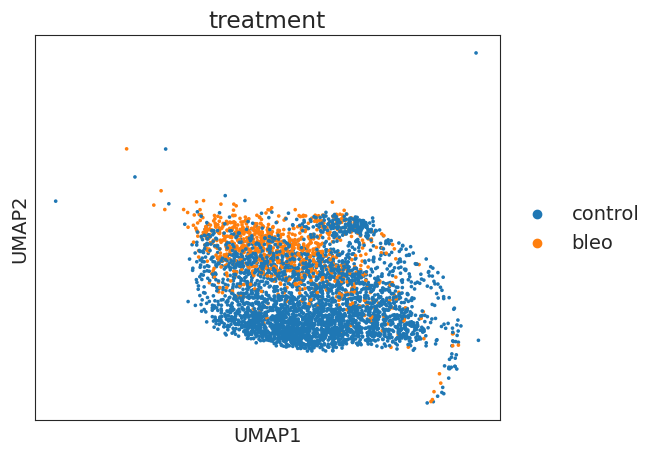

Started Diffxpy Calculation:	14-08-2024 18:25:06
training location model: True
training scale model: True
iter   0: ll=7891196.792920
iter   1: ll=7189474.480335, converged: 0.00% (loc: 0.00%, scale update: False), in 1.65sec
iter   2: ll=7024897.180655, converged: 0.00% (loc: 0.00%, scale update: False), in 1.52sec
iter   3: ll=7015070.615661, converged: 0.00% (loc: 0.00%, scale update: False), in 1.46sec
iter   4: ll=7015007.030555, converged: 0.00% (loc: 0.00%, scale update: False), in 1.45sec
iter   5: ll=7015006.929249, converged: 0.00% (loc: 2.97%, scale update: False), in 1.48sec
iter   6: ll=6902404.769596, converged: 0.00% (loc: 0.00%, scale update: True), in 15.70sec
iter   7: ll=6901911.368025, converged: 0.00% (loc: 0.00%, scale update: False), in 1.69sec
iter   8: ll=6901904.367627, converged: 0.00% (loc: 1.64%, scale update: False), in 1.56sec
iter   9: ll=6901904.258336, converged: 0.00% (loc: 18.85%, scale update: False), in 1.49sec
iter  10: ll=6901904.255717, converge

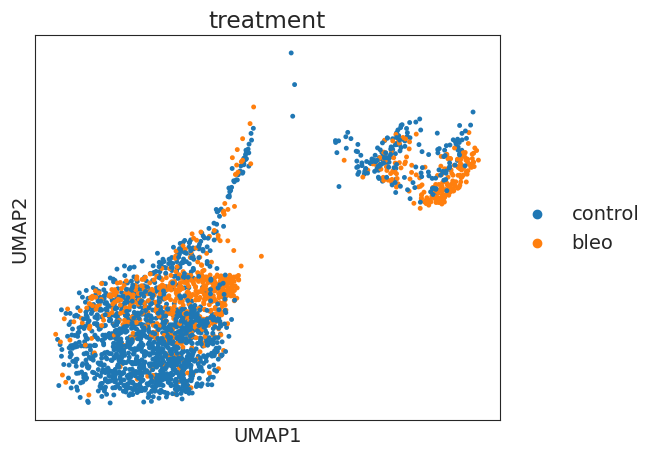

Started Diffxpy Calculation:	14-08-2024 18:26:43
training location model: True
training scale model: True
iter   0: ll=3169923.251201
iter   1: ll=2801557.612803, converged: 0.00% (loc: 0.27%, scale update: False), in 0.85sec
iter   2: ll=2708797.533178, converged: 0.00% (loc: 0.27%, scale update: False), in 0.75sec
iter   3: ll=2699405.457715, converged: 0.00% (loc: 0.27%, scale update: False), in 0.85sec
iter   4: ll=2698999.592971, converged: 0.00% (loc: 0.27%, scale update: False), in 0.73sec
iter   5: ll=2698984.170601, converged: 0.00% (loc: 0.98%, scale update: False), in 0.79sec
iter   6: ll=2388962.048276, converged: 0.00% (loc: 0.00%, scale update: True), in 5.94sec
iter   7: ll=2388034.985048, converged: 0.00% (loc: 0.05%, scale update: False), in 0.88sec
iter   8: ll=2387973.803128, converged: 0.00% (loc: 1.36%, scale update: False), in 0.83sec
iter   9: ll=2387969.837694, converged: 0.00% (loc: 7.43%, scale update: False), in 0.92sec
iter  10: ll=2387969.778734, converged:

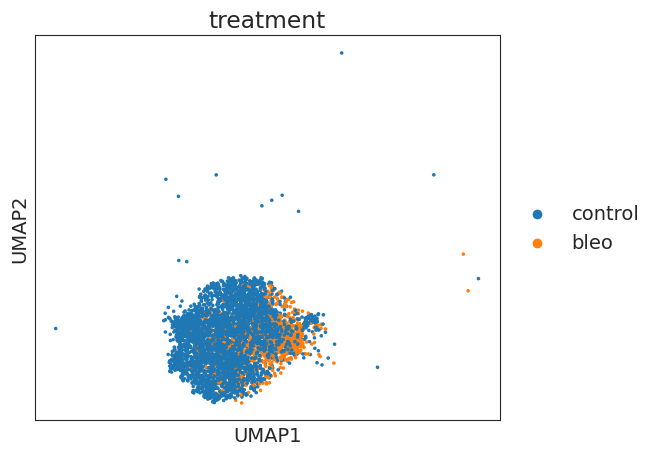

Started Diffxpy Calculation:	14-08-2024 18:27:30
training location model: True
training scale model: True
iter   0: ll=7569950.565313
iter   1: ll=6882735.168843, converged: 0.00% (loc: 0.00%, scale update: False), in 1.59sec
iter   2: ll=6736642.865493, converged: 0.00% (loc: 0.00%, scale update: False), in 1.60sec
iter   3: ll=6729709.221048, converged: 0.00% (loc: 0.00%, scale update: False), in 2.05sec
iter   4: ll=6729687.810103, converged: 0.00% (loc: 0.00%, scale update: False), in 1.61sec
iter   5: ll=6729687.803547, converged: 0.00% (loc: 27.11%, scale update: False), in 2.00sec
iter   6: ll=6634148.010580, converged: 0.00% (loc: 0.00%, scale update: True), in 17.19sec
iter   7: ll=6634016.309417, converged: 0.00% (loc: 0.06%, scale update: False), in 1.66sec
iter   8: ll=6634015.778010, converged: 0.00% (loc: 7.31%, scale update: False), in 1.44sec
iter   9: ll=6634015.775461, converged: 0.00% (loc: 69.46%, scale update: False), in 1.41sec
iter  10: ll=6634015.775441, converg

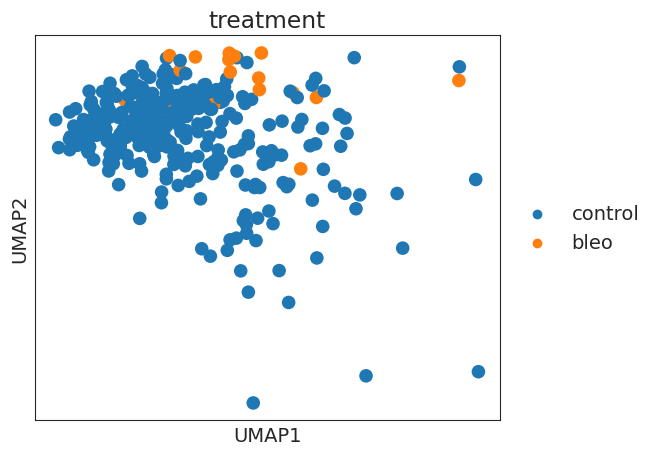

Started Diffxpy Calculation:	14-08-2024 18:28:59
training location model: True
training scale model: True
iter   0: ll=521647.187169
caught 659 linalg singular matrix errors
iter   1: ll=479187.009344, converged: 0.00% (loc: 17.70%, scale update: False), in 0.88sec
iter   2: ll=469892.697140, converged: 0.00% (loc: 17.70%, scale update: False), in 0.41sec
iter   3: ll=469418.694001, converged: 0.00% (loc: 17.70%, scale update: False), in 0.68sec
iter   4: ll=469416.742163, converged: 0.00% (loc: 17.70%, scale update: False), in 0.52sec
iter   5: ll=469416.739708, converged: 0.00% (loc: 32.88%, scale update: False), in 0.67sec
iter   6: ll=460516.380016, converged: 0.00% (loc: 0.00%, scale update: True), in 5.21sec
caught 659 linalg singular matrix errors
iter   7: ll=460478.761654, converged: 0.00% (loc: 18.35%, scale update: False), in 0.43sec
iter   8: ll=460476.165438, converged: 0.00% (loc: 23.05%, scale update: False), in 0.37sec
iter   9: ll=460476.140200, converged: 0.00% (loc: 

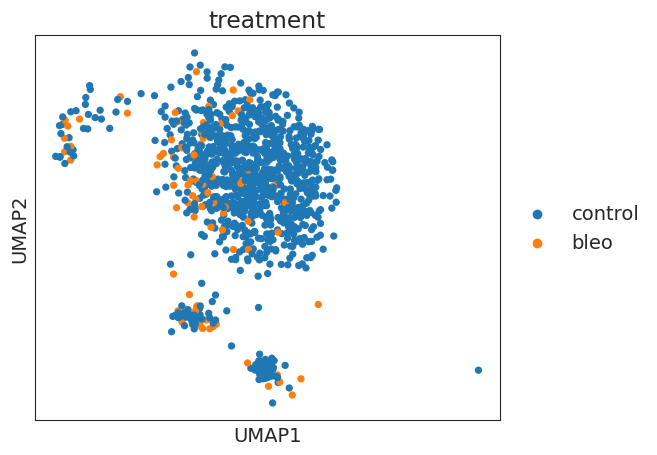

Started Diffxpy Calculation:	14-08-2024 18:29:29
training location model: True
training scale model: True
iter   0: ll=1154604.385022
caught 2 linalg singular matrix errors
iter   1: ll=1035124.206287, converged: 0.00% (loc: 0.10%, scale update: False), in 1.03sec
iter   2: ll=1003115.731139, converged: 0.00% (loc: 0.10%, scale update: False), in 0.69sec
iter   3: ll=1000851.435803, converged: 0.00% (loc: 0.10%, scale update: False), in 0.77sec
iter   4: ll=1000838.889483, converged: 0.00% (loc: 0.10%, scale update: False), in 0.88sec
iter   5: ll=1000838.888263, converged: 0.00% (loc: 22.60%, scale update: False), in 0.82sec
iter   6: ll=979566.898314, converged: 0.00% (loc: 0.00%, scale update: True), in 5.24sec
caught 2 linalg singular matrix errors
iter   7: ll=979550.152997, converged: 0.00% (loc: 0.10%, scale update: False), in 0.77sec
iter   8: ll=979550.091710, converged: 0.00% (loc: 11.15%, scale update: False), in 0.53sec
iter   9: ll=979550.091428, converged: 0.00% (loc: 84.

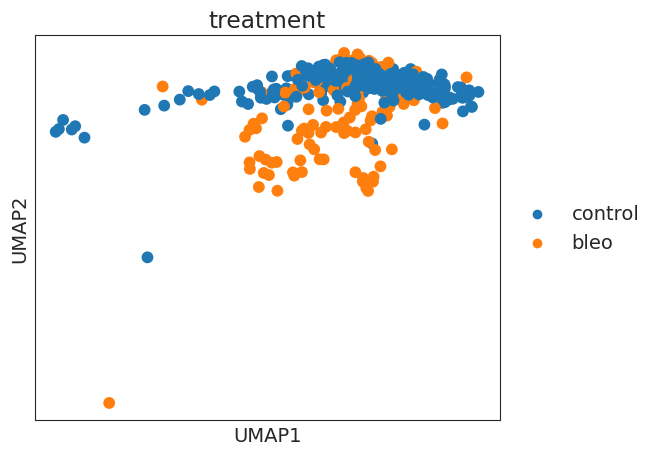

Started Diffxpy Calculation:	14-08-2024 18:29:55
training location model: True
training scale model: True
iter   0: ll=1819415.914252
caught 56 linalg singular matrix errors
iter   1: ll=1701206.052839, converged: 0.00% (loc: 2.81%, scale update: False), in 0.48sec
iter   2: ll=1671161.670846, converged: 0.00% (loc: 2.81%, scale update: False), in 0.48sec
iter   3: ll=1667695.928394, converged: 0.00% (loc: 2.81%, scale update: False), in 0.49sec
iter   4: ll=1667366.638253, converged: 0.00% (loc: 2.81%, scale update: False), in 0.53sec
iter   5: ll=1667324.759195, converged: 0.00% (loc: 2.84%, scale update: False), in 0.53sec
iter   6: ll=1085894.953200, converged: 0.00% (loc: 0.00%, scale update: True), in 6.68sec
caught 51 linalg singular matrix errors
iter   7: ll=1084168.241544, converged: 0.00% (loc: 1.08%, scale update: False), in 0.60sec
iter   8: ll=1083782.066079, converged: 0.00% (loc: 1.85%, scale update: False), in 0.55sec
iter   9: ll=1083684.790905, converged: 0.00% (loc:

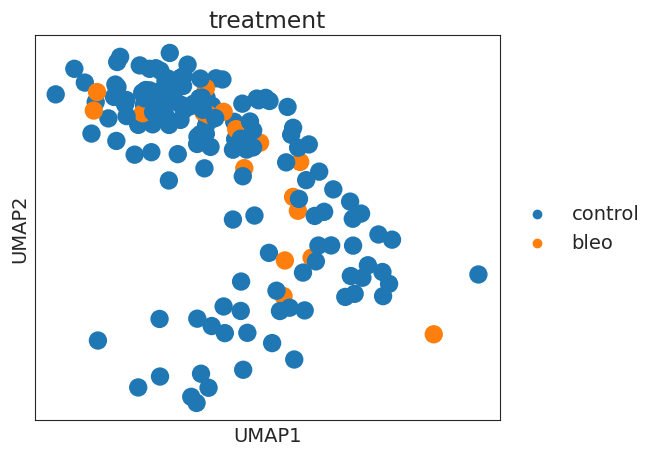

Started Diffxpy Calculation:	14-08-2024 18:31:24
training location model: True
training scale model: True
iter   0: ll=389554.886211
caught 992 linalg singular matrix errors
iter   1: ll=358681.269028, converged: 0.00% (loc: 21.69%, scale update: False), in 0.82sec
iter   2: ll=352385.792923, converged: 0.00% (loc: 21.69%, scale update: False), in 0.74sec
iter   3: ll=352071.816525, converged: 0.00% (loc: 21.69%, scale update: False), in 0.70sec
iter   4: ll=352069.843594, converged: 0.00% (loc: 21.69%, scale update: False), in 0.68sec
iter   5: ll=352069.836652, converged: 0.00% (loc: 31.80%, scale update: False), in 1.00sec
iter   6: ll=328629.027135, converged: 0.00% (loc: 0.00%, scale update: True), in 5.24sec
caught 992 linalg singular matrix errors
iter   7: ll=328567.846136, converged: 0.00% (loc: 23.13%, scale update: False), in 0.37sec
iter   8: ll=328565.135197, converged: 0.00% (loc: 27.43%, scale update: False), in 0.37sec
iter   9: ll=328565.104737, converged: 0.00% (loc: 

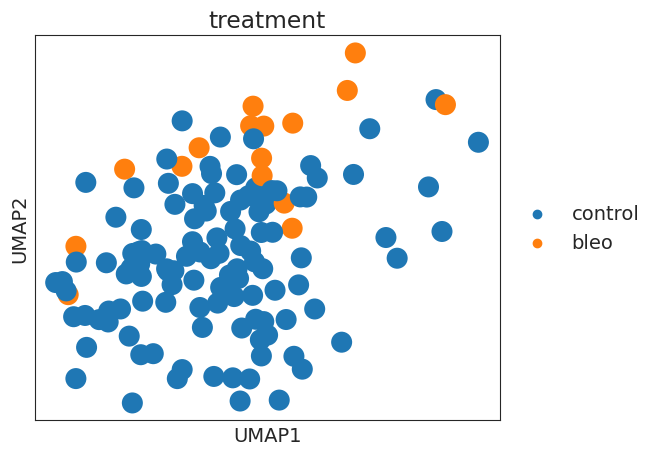

Started Diffxpy Calculation:	14-08-2024 18:32:03
training location model: True
training scale model: True
iter   0: ll=629296.619626
caught 1151 linalg singular matrix errors
iter   1: ll=594678.443231, converged: 0.00% (loc: 26.65%, scale update: False), in 0.42sec
iter   2: ll=587250.000746, converged: 0.00% (loc: 26.65%, scale update: False), in 0.69sec
iter   3: ll=586771.190374, converged: 0.00% (loc: 26.65%, scale update: False), in 0.86sec
iter   4: ll=586764.211173, converged: 0.00% (loc: 26.65%, scale update: False), in 0.59sec
iter   5: ll=586764.146154, converged: 0.00% (loc: 29.09%, scale update: False), in 0.53sec
iter   6: ll=286761.874713, converged: 0.00% (loc: 0.00%, scale update: True), in 4.59sec
caught 1151 linalg singular matrix errors
iter   7: ll=286553.117734, converged: 0.00% (loc: 26.45%, scale update: False), in 0.45sec
iter   8: ll=286528.723647, converged: 0.00% (loc: 29.69%, scale update: False), in 0.42sec
iter   9: ll=286527.329871, converged: 0.00% (loc

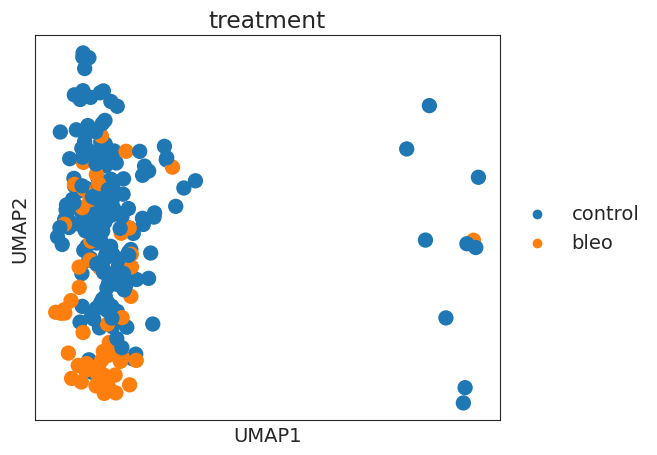

Started Diffxpy Calculation:	14-08-2024 18:32:49
training location model: True
training scale model: True
iter   0: ll=2245203.774905
caught 165 linalg singular matrix errors
iter   1: ll=2152819.880026, converged: 0.00% (loc: 9.02%, scale update: False), in 1.02sec
iter   2: ll=2128957.278492, converged: 0.00% (loc: 9.02%, scale update: False), in 0.71sec
iter   3: ll=2126266.583371, converged: 0.00% (loc: 9.02%, scale update: False), in 0.50sec
iter   4: ll=2126113.169187, converged: 0.00% (loc: 9.02%, scale update: False), in 0.53sec
iter   5: ll=2126105.441784, converged: 0.00% (loc: 9.08%, scale update: False), in 0.52sec
iter   6: ll=637897.502844, converged: 0.00% (loc: 0.00%, scale update: True), in 4.28sec
caught 165 linalg singular matrix errors
iter   7: ll=633216.474259, converged: 0.00% (loc: 3.38%, scale update: False), in 0.48sec
iter   8: ll=632353.252656, converged: 0.00% (loc: 4.37%, scale update: False), in 0.49sec
iter   9: ll=632268.614210, converged: 0.00% (loc: 1

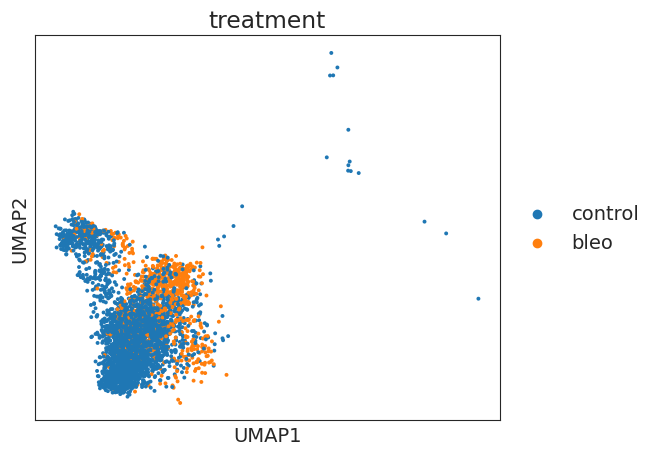

Started Diffxpy Calculation:	14-08-2024 18:33:51
training location model: True
training scale model: True
iter   0: ll=7983291.397422
iter   1: ll=7281859.056002, converged: 0.00% (loc: 0.00%, scale update: False), in 1.39sec
iter   2: ll=7126209.196695, converged: 0.00% (loc: 0.00%, scale update: False), in 1.30sec
iter   3: ll=7117780.371885, converged: 0.00% (loc: 0.00%, scale update: False), in 1.53sec
iter   4: ll=7117738.935822, converged: 0.00% (loc: 0.00%, scale update: False), in 1.41sec
iter   5: ll=7117738.902736, converged: 0.00% (loc: 2.74%, scale update: False), in 1.55sec
iter   6: ll=6986856.202204, converged: 0.00% (loc: 0.00%, scale update: True), in 15.29sec
iter   7: ll=6986377.859005, converged: 0.00% (loc: 0.05%, scale update: False), in 1.48sec
iter   8: ll=6986375.043857, converged: 0.00% (loc: 1.95%, scale update: False), in 1.34sec
iter   9: ll=6986375.028011, converged: 0.00% (loc: 23.40%, scale update: False), in 1.39sec
iter  10: ll=6986375.027881, converge

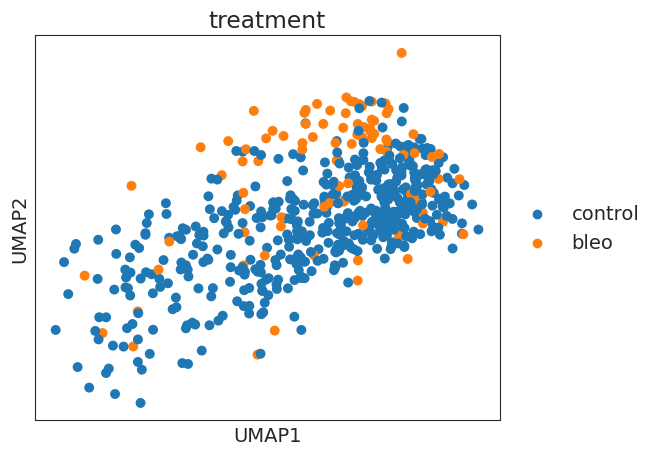

Started Diffxpy Calculation:	14-08-2024 18:35:30
training location model: True
training scale model: True
iter   0: ll=1671106.655716
caught 15 linalg singular matrix errors
iter   1: ll=1514739.246459, converged: 0.00% (loc: 0.70%, scale update: False), in 0.82sec
iter   2: ll=1479267.642453, converged: 0.00% (loc: 0.70%, scale update: False), in 0.52sec
iter   3: ll=1476732.651397, converged: 0.00% (loc: 0.70%, scale update: False), in 0.71sec
iter   4: ll=1476676.188043, converged: 0.00% (loc: 0.70%, scale update: False), in 0.51sec
iter   5: ll=1476674.304026, converged: 0.00% (loc: 1.05%, scale update: False), in 0.53sec
iter   6: ll=1361638.271173, converged: 0.00% (loc: 0.00%, scale update: True), in 5.08sec
caught 15 linalg singular matrix errors
iter   7: ll=1361072.841746, converged: 0.00% (loc: 0.39%, scale update: False), in 0.49sec
iter   8: ll=1360948.524959, converged: 0.00% (loc: 2.26%, scale update: False), in 0.53sec
iter   9: ll=1360943.789635, converged: 0.00% (loc:

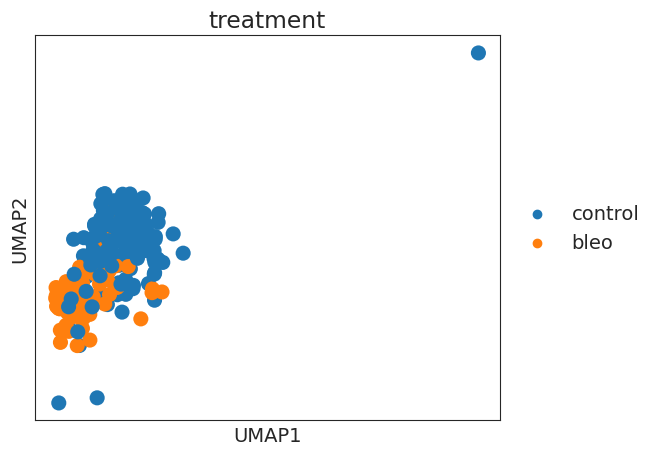

Started Diffxpy Calculation:	14-08-2024 18:36:18
training location model: True
training scale model: True
iter   0: ll=2473057.308504
caught 72 linalg singular matrix errors
iter   1: ll=2364025.471674, converged: 0.00% (loc: 6.52%, scale update: False), in 0.62sec
iter   2: ll=2334825.395608, converged: 0.00% (loc: 6.52%, scale update: False), in 0.74sec
iter   3: ll=2331300.673485, converged: 0.00% (loc: 6.52%, scale update: False), in 0.62sec
iter   4: ll=2331096.387713, converged: 0.00% (loc: 6.52%, scale update: False), in 0.59sec
iter   5: ll=2331087.322110, converged: 0.00% (loc: 6.57%, scale update: False), in 0.57sec
iter   6: ll=754394.476251, converged: 0.00% (loc: 0.00%, scale update: True), in 4.29sec
caught 72 linalg singular matrix errors
iter   7: ll=750835.762683, converged: 0.00% (loc: 2.24%, scale update: False), in 0.61sec
iter   8: ll=750179.619176, converged: 0.00% (loc: 2.91%, scale update: False), in 0.61sec
iter   9: ll=750137.625796, converged: 0.00% (loc: 7.7

iter  86: ll=738850.861272, converged: 99.91% (loc: 99.91%, scale update: True), in 1.12sec
iter  87: ll=738850.861272, converged: 99.91% (loc: 99.91%, scale update: False), in 0.13sec
iter  88: ll=738850.861272, converged: 99.91% (loc: 100.00%, scale update: False), in 0.14sec
iter  89: ll=738850.861271, converged: 99.91% (loc: 99.91%, scale update: True), in 1.06sec
iter  90: ll=738850.861271, converged: 99.91% (loc: 99.96%, scale update: False), in 0.13sec
iter  91: ll=738850.861271, converged: 99.91% (loc: 100.00%, scale update: False), in 0.11sec
iter  92: ll=738850.861271, converged: 99.96% (loc: 99.96%, scale update: True), in 1.08sec
iter  93: ll=738850.861271, converged: 99.96% (loc: 99.96%, scale update: False), in 0.11sec
iter  94: ll=738850.861271, converged: 99.96% (loc: 100.00%, scale update: False), in 0.12sec
iter  95: ll=738850.861271, converged: 99.96% (loc: 99.96%, scale update: True), in 0.11sec
iter  96: ll=738850.861271, converged: 99.96% (loc: 99.96%, scale updat

In [22]:
subset = ["control", "bleo"]
condition = "treatment"
ct_label = "meta_label"
min_cells = 10

time = "d37"
time_subset = adata[adata.obs.time_point.isin([time, "d0"])].copy()
sc.pl.umap(time_subset, color = ["day", "meta_label"], size = 10, wspace = 0.25)

for ct in cell_types:
    
    print("%s - %s" %(ct, time))
    dge(time_subset, ct = ct, ct_label = ct_label, condition = condition, ref = "control", pct_thresh = 0.05,
              subset = subset, min_cells = min_cells, do_return = False, suffix = "_old")